## 1. Introduction

The objective of this notebook is to build a model based on deep learning that predicts whether a stock goes up or down in the next day based on today's data. The steps involved in the entire process is given below:
   1. Choosing the stock for prediction
   2. Data Extraction
   3. Feature Engineering & EDA
   4. Model Building
   5. Evaluating the model on test data
   6. Backtesting the best model

## 2. Choosing the stock for prediction

For the purpose of this project, we choose the stock "TVS motors". This stock is chosen based on three factors:
   1. Stock listed in NSE India
   2. Part of Nifty Midcap Index
   3. Part of automotive industry

The criteria for choosing the stock is entirely based on personal preference and expertise. 

In [1]:
ticker = 'TVSMOTOR.NS'

## 3. Data Extraction

### 3.1 Types of Features Used

The features used for the price trend prediction are categorized into the following types:
1. Basic Information (Price, Volume etc.)
2. Technical Features
3. Market Depth Features from Options Data
4. Macroeconomic Features
5. Fundamental Features
6. Sentiment Features
7. Features based on Time Series Models

For the different types of features, following are the list of data points and their data sources to be used.

|Feature Category | Features | Data Source|
|:------------------|:------|:------------|
|Basic Features| Price, Volume, Date/Time Features| Yahoo Finance|
|Technical Features| SMA, RSI, BB, ATR, Candlestick patterns | Created from Basic Info (Pandas-TA)|
|Market Depth| Open Interest, Put call ratio | NSElib|
|Macroeconomic Feautures|Oil prices, Interest rates, Index returns, VIX| OpenBB|
|Fundamental Features|Sector performance, Corporate Actions Calendar| OpenBB|
|Sentiment Features| News, Google Trends|Google News, Google Trends API|
|Time Series Model Features| Regime Indicator, OpenBB Forecast?| Created from other Features (Sklearn, OpenBB)|

### 3.2 Importing Necessary Libraries

In [2]:
#from openbb_terminal.sdk import openbb
from nselib import derivatives
import numpy as np
import pandas as pd
import yfinance as yf
from gnews import GNews
from pytrends.request import TrendReq
import datetime, time,csv
from dateutil.relativedelta import relativedelta
import pandas_ta
import os,shutil
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tabulate import tabulate
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
random.seed(12)
np.random.seed(12)
plt.style.use('ggplot')
sns.set_style('whitegrid')

### 3.3 Extracting Price and Volume Data

The model is trained on data from the period of ```2017-01-01``` to ```2023-01-31```. The period from ```2023-02-01``` to ```2023-10-01``` is taken as test data set. The frequency of the data is daily.

In [4]:
train_start = '2017-01-01'
train_end = '2023-01-31'

valid_start = '2023-02-01'
valid_end = '2023-06-01'

test_start = '2023-06-01'
test_end = '2023-10-01'

In [5]:
stock_data = yf.download(ticker,start = train_start,end=test_end,progress=False)

### 3.4 Extracting Technical Indicators and Patterns

The technical features are extracted from ```Pandas-TA``` library. ```Pandas-TA``` has more than 250+ indicators and initially it was decided to consider all the indicators and select relevant ones but the indicators did not show any prediction power. Hence it was decided to use only a few common indicators and patterns to extract better features from them.

#### 3.4.1 Technical Indicators

Since the indicators have a look back period, we extract prices data few months prior to the train period.

In [6]:
df = yf.download(ticker,start = '2016-01-01',end=test_end,progress=False)
df.ta.adjusted = "Adj Close"

In [7]:
# Simple Moving Average - 5,14,30,100 Day periods
sma  = pd.DataFrame([df.ta.sma(length = n,adjusted=True) for n in [5,14,30,100]]).T

# Exponential Moving Average - 5,14,30,100 Day periods
ema  = pd.DataFrame([df.ta.ema(length = n,adjusted=True) for n in [5,14,30,100]]).T

# Slope - 10,30,100 day
slope = pd.DataFrame([df.ta.linreg(length = n,slope=True,adjusted=True) for n in [14,30,100]]).T

# RSI - 14,30,100 day
rsi = pd.DataFrame([df.ta.rsi(length = n,adjusted=True) for n in [14,30,100]]).T

# ATR - 14,30,100 day
atr = pd.DataFrame([df.ta.atr(length = n,adjusted=True) for n in [14,30,100]]).T

# TR
tr = pd.DataFrame(np.maximum(df.ta.true_range(),0.01))
#tr = tr.tz_localize(None)

# Bollinger Bands - 14,30,100 day
bbands = pd.concat([pd.DataFrame(df.ta.bbands(length = n,adjusted=True)) for n in [14,30,100]],axis=1)

# ADX - 14,30,100 day
adx = pd.concat([pd.DataFrame(df.ta.adx(length = n,adjusted=True)) for n in [14,30,100]],axis=1)

#Price volume rank - State of Price change and volume change
pvr = df.ta.pvr()

#Stochastic Oscillator - 14,30,100 day
stoch_osc = pd.concat([pd.DataFrame(df.ta.stoch(k=n,adjusted=True)) for n in [14,30,100]],axis=1)

# Chaikin Money Flow - 14,30,100 day
cmf = pd.DataFrame([df.ta.cmf(open_=True, length =n) for n in [14,30,100]]).T

#### 3.4.2 CandleStick Patterns

In addition to indicators, candle stick Patterns are also considered for features. The presence of a candle stick pattern might be able to confirm the trend of the next day. We use the candle stick patterns provided by ```Pandas-TA``` which gives a value of 1 or -1 if the candle is formed either bullish or bearish and 0 other wise.

In [8]:
cdls = df.ta.cdl_pattern(name='all')
cdls /= 100

### 3.5 Extracting Historical Option OI Data Information using NSElib

Historical Open Interest (OI) is obtained using ```NSElib``` package using the code below. The call and put option open interest are extracted for strike price and the total OI is calculated by summing all the OI for each strike price.

In [9]:
# Code for getting historical data from NSELib

"""
call_option_hist = derivatives.option_price_volume_data(symbol="TVSMOTOR",
                                     instrument="OPTSTK",
                                     option_type="CE",
                                     from_date='01-01-2017',
                                     to_date='01-10-2023')
                                     
put_option_hist = derivatives.option_price_volume_data(symbol="TVSMOTOR",
                                     instrument="OPTSTK",
                                     option_type="PE",
                                     from_date='01-01-2017',
                                     to_date='01-10-2023')

option_hist = pd.concat([call_option_hist,put_option_hist],ignore_index = True)

option_hist["TIMESTAMP"] = pd.to_datetime(option_hist["TIMESTAMP"],format = '%d-%b-%Y')
option_hist["OPEN_INT"] = np.float32(option_hist["OPEN_INT"])

OI_data = option_hist.groupby(["TIMESTAMP","OPTION_TYPE"]).sum()["OPEN_INT"].reset_index()
OI_data.to_csv("OI_data_TVS.csv")
"""
option_hist = pd.read_csv("./Data Extracts/OI_data_TVS.csv")

### 3.6 Extracting Macro economic Data

The macroeconomic data that are extracted for the project are listed in the table below:

|Type of Macroeconomic Data| Data Used|Source|
|:--------------------------|:----------|:-------|
|Commodity Prices|Brent Crude Oil Futures, Natural Gas Futures, Gold Futures, Copper Futures|Yahoo Finance|
|Stock Index*|Nifty 50, Nifty Midcap, BSE, BSE Midcap, BSE Small Cap|Yahoo Finance|
|Risk Indicator| India VIX|Investing.com|
|Interest Rate**| India Repo Rate|Investing.com|

\*  Only Nifty 50 is used as the market index. The other indices are used to compute stock performance relative to benchmark

\** Interest rates are updated only every 3 months. This is of low frequency compared to daily data used elsewhere.

#### 3.6.1 Commodity Prices

In [10]:
# Commodity prices expected to be cointegrated with the stock
commodity_prices =  yf.download(['BZ=F',"NG=F",'GC=F','HG=F'],start = train_start,end=test_end,progress=False)['Adj Close']
commodity_prices.columns = ['crude_oil','natural_gas','gold','copper']

#### 3.6.2 Index Prices

In [11]:
# Market prices to judge the state of the economy
index_prices = yf.download(['^NSEI','^NSEMDCP50','^BSESN','BSE-MIDCAP.BO','BSE-SMLCAP.BO'],start = train_start,end=test_end,progress=False)['Adj Close']
index_prices.columns = ['nifty_50','nifty_midcap','bse_lc','bse_mc','bse_sc']

#### 3.6.3 VIX Data

In [12]:
# VIX data to judge the riskiness of the environment. Extracted from Investing.com
vix_data = pd.read_excel("./Data Extracts/IndiaVIX.xlsx")[["Date","Price"]]
vix_data = vix_data.set_index("Date").sort_index()

#### 3.6.4 Interest Rates

In [13]:
#Interest Rate data for India
interest_rate_data = pd.read_excel("./Data Extracts/India Interest Rate history.xlsx")
interest_rate_data = interest_rate_data.set_index('Release Date').sort_index()

### 3.7 Extracting Fundamental Data

#### 3.7.1 Corporate Actions

Corporate actions include dividend announcements, stock splits and bonus issues. For the ticker only dividends are applicable. The exdividend date is indicated as a feature to be used in the model.

In [14]:
ex_dividend_info = pd.read_csv("./Data Extracts/Corporate_Actions.csv")[["Ex Date","DPS"]]
ex_dividend_info["Ex Date"] = pd.to_datetime(ex_dividend_info["Ex Date"])

#### 3.7.2 Earnings Surprise

In [15]:
earnings_data = pd.read_excel('./Data Extracts/Earnings_TVS_Motors.xlsx')

#### 3.7.3 Sector Performance

Performance of the peer companies which have similar fundamental factors can be used as a factor. Performance of the Nifty Auto Index portfolio are considered (TVS Motor Co is excluded from the list). Assumption is made that the portfolio weights (weighted by market cap) remains constant.

In [16]:
sector_stocks_info = pd.read_csv("./Data Extracts/ind_niftyautolist.csv")
sector_stocks_info['weights'] = sector_stocks_info['Market Cap']/sector_stocks_info['Market Cap'].sum()
sector_stocks = sector_stocks_info['Symbol'].str[:]+'.NS'

In [17]:
sector_stocks_data = yf.download(sector_stocks.to_list(),start = train_start,end=test_end,progress=False)['Adj Close']
sector_stocks_data.columns = sector_stocks.to_list()

In [18]:
sector_portfolio = pd.DataFrame({'Sector Portfolio':np.dot(sector_stocks_data,sector_stocks_info['weights'])},
                                index=sector_stocks_data.index)

### 3.8 Sentiment Data

#### 3.8.1 Extracting News Data from Google News

The news sentiment is expected to be an important feature to predict short term trend. The news data is collected from Google News using ```Gnews``` API. The code for the extraction process is given below. The top 5 news items related to the company are extracted for each date over the train and test period.

In [19]:
#Code for extracting News from Google News
'''
news_dict = {}
progress = 0
date_range = pd.date_range(train_start,test_end,freq = '1D')
for date in date_range:
    
    news = GNews(country='IN',max_results=5,
                 start_date=(date+np.timedelta64(-1,"D")).date(),
                 end_date=date.date())
    
    news_items = news.get_news('TVS Motor')
    
    news_dict[date] = [item['title'] for item in news_items]
    
    progress += 1
    if progress % 50 ==0:
        print(f'{progress}/{len(date_range)} Completed !!')
        
news_df = pd.DataFrame([news_dict.keys(),news_dict.values()]).T
news_df.columns = ['Date','News_items']
news_df.to_csv("News_TVSMOTOR.csv",index=False)
        
'''
news_df = pd.read_csv('./Data Extracts/News_TVSMOTOR.csv')
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df['News_items'] = news_df['News_items'].apply(eval)
news_df = news_df.set_index('Date')

#### 3.8.2 Extracting Google search volume from Google Trends

```Google``` search volume for the company used is also considered to be used as a feature. The ```Google``` search volume can be extracted from Google Trends API using ```pytrends```. However the procedure for extracting the daily search volume is not straight forward. 

```Google trends``` does not provide exact search volume. It provides searches on a relative scale between 0-100 for each day where the day with the highest volume will have the highest value of 100 and lowest search days will be 0. This is not really a problem in a normal scenario. But ```Google``` allows daily search volumes to be extracted only for a period of 6 months, for 6 months to 5 years time frame we can get only weekly data and for higher time frames we can get only monthly data. 

We cannot extract the search volumes for every 6 months and combine it, since the searches are on a relative scale based on the time frame selected. Hence a different approach needs to be used.

The approach used for this project is to use the monthly trend of search volumes (which is the lowest frequency provided by ```Google Trends```) to get the relative weight of the monthly volumes compared to other months and scale the daily values so that the monthly trend gets preserved.

The approach is explained in the following steps:

1. Extract the search volumes for the entire time frame. ```Google``` will automatically provide the monthly search volumes.
2. Extract the daily search volumes for each month separately from the 1st of every month to the end of the month.
3. Compute the average search volume for each month from the daily data.
4. Compute the ratio of monthly search volume (from step 1) to the average search volume (from step 3).
5. Scale the daily search volumes by the ratio. This will preserve the daily patterns along with the monthly trends

Below code extracts the monthly search volumes using ```pytrends```. The keyword chosen is the Google trends specification for the ```TVS Motor Company```. The searches are limited to only ```Auto & Vehicles``` category so that the data is more relevant.

In [20]:
keyword = ['/m/0btflr'] # Google Trends keyword for TVS Motor Company -Topic
cat = 47 # Google trends category providing searches only related to Auto & Vehicles.

# Gtrends Monthly Search Volume for getting overall trends
'''
full_date_range = train_start + ' ' + test_end 
gtrends = TrendReq(geo='IN')
gtrends.build_payload(kw_list=keyword,cat=cat,timeframe=full_date_range,geo='IN')
try:
    gsv_monthly = gtrends.interest_over_time()
except:
    time.sleep(30)
    gsv_monthly = gtrends.interest_over_time()
'''
print('')

Below code extracts the data for every day from the 1st of every month to the end of the month. Due to rate limits by ```Google```, the request to pull the data may fail. In that case, the request is tried again after a sleep time.

In [21]:
# Gtrends daily search volume for every month
'''
month_end_dates = pd.date_range(train_start,test_end,freq='1M').append(pd.DatetimeIndex([test_end]))
gsv_daily = pd.DataFrame()
max_retries = 20
progress = 0
for end_date in month_end_dates:
    start_date = end_date.replace(day=1)
    date_range = str(start_date.date()) + ' ' + str(end_date.date())
    retries =0
    while retries< max_retries:
        try:
            gtrends = TrendReq(geo='IN')
            gtrends.build_payload(kw_list=keyword,cat=cat,timeframe=date_range,geo='IN')
            time.sleep(10)
            df = gtrends.interest_over_time()
            if gsv_daily.empty:
                gsv_daily = df
            else:
                gsv_daily = pd.concat([gsv_daily,df],axis=0)
        except:
            retries +=1
            print(f'Request Failed for {date_range}. Retry attempt {retries} out of {max_retries}...')
            time.sleep(30)
            continue
        else:
            print(f'Request completed for {date_range}')
            break
    
    if retries == max_retries:
        print(f'Request Failed for {date_range}')
            
    time.sleep(20)
'''
print('')

The below code computes the monthly average volume from the daily data and then the ratio of the monthly average to the monthly search volumes is computed. The ratio is then applied to the daily search values to scale them accordingly to the monthly values.

In [22]:
# Code for computing rescaled daily search volumes inline with monthly trend.
'''
gsv_daily.index = pd.to_datetime(gsv_daily.index)
gsv_daily = pd.DataFrame({'daily_search_values':gsv_daily.iloc[:,0]})
gsv_monthly = pd.DataFrame({'monthly_search_values':gsv_monthly.iloc[:,0]})

gsv_daily['Month'] = [pd.to_datetime(date).replace(day=1) for date in gsv_daily.index]
gsv_monthly_avg = gsv_daily.groupby('Month').mean()
gsv_recon = gsv_monthly.merge(gsv_monthly_avg,how='inner',left_index=True,right_index=True)

gsv_recon['factor'] = gsv_recon['monthly_search_values']/gsv_recon['daily_search_values']
gsv_daily['factor'] = gsv_daily.merge(gsv_recon,left_on='Month',right_index=True)['factor']
gsv_daily['daily_search_values_recon'] = gsv_daily['daily_search_values'] *gsv_daily['factor']
gsv_daily.to_csv('./Data Extracts/gsv_daily.csv')
'''
gsv_daily = pd.read_csv('./Data Extracts/gsv_daily.csv')
gsv_daily = gsv_daily.set_index('date')
gsv_daily.index = pd.to_datetime(gsv_daily.index)

The final rescaled daily search volumes are shown below. This is the pattern of search volumes for the company. This gives an indicator about the relative interest in the company.

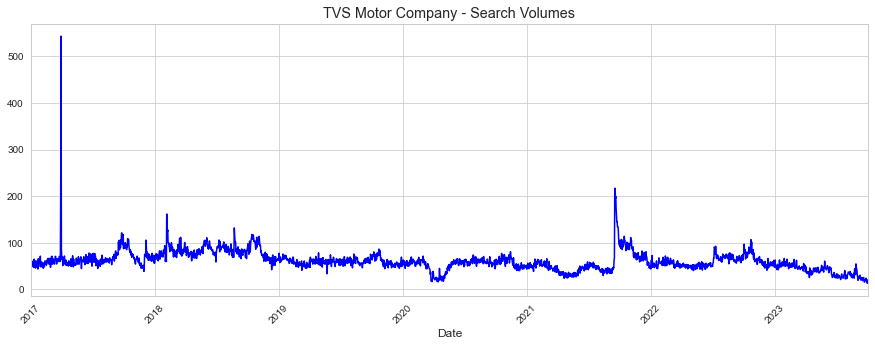

In [23]:
plt.figure(figsize=(15,5))
gsv_daily['daily_search_values_recon'].plot(color='b')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.title('TVS Motor Company - Search Volumes')
plt.show()

## 4. Feature Engineering & EDA

From the data extracted in the previous section, features are created based on literature review and personal hypothesis. The relationship between the features and the target variable is studied and only relevant features are selected. Finally dimensionality reduction is done if the selected features are correlated. The train and test features need to be created carefully so that there is no data leakage. EDA also needs to be done only train data.

In [24]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score, average_precision_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

In [25]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

### 4.1 Target Variables

The target variable is the price trend calculated from  next day returns. We indicate the variable as +1 if the returns are greater 0.5% and 0 if it is less than 0.5%.

In [26]:
target = (stock_data['Adj Close'].pct_change().shift(-1) > 0.5/100)*1

train_Y = target[train_start:train_end]
valid_Y = target[valid_start:valid_end]
test_Y = target[test_start:test_end]

In [27]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_Y.values),
                                                  y =train_Y.values)

class_weights = dict(zip(np.unique(train_Y.values),class_weights))

### 4.2 Basic Features

Basic features are features that can be created from OHLCV data. The created features are analysed and irrelevant features can be excluded.

#### 4.2.1 Lagged Returns

In [28]:
returns = np.log(stock_data['Adj Close']).diff().fillna(0)
train_returns = returns.loc[train_start:train_end]

The relationship between return series and its lags are checked for any correlation.

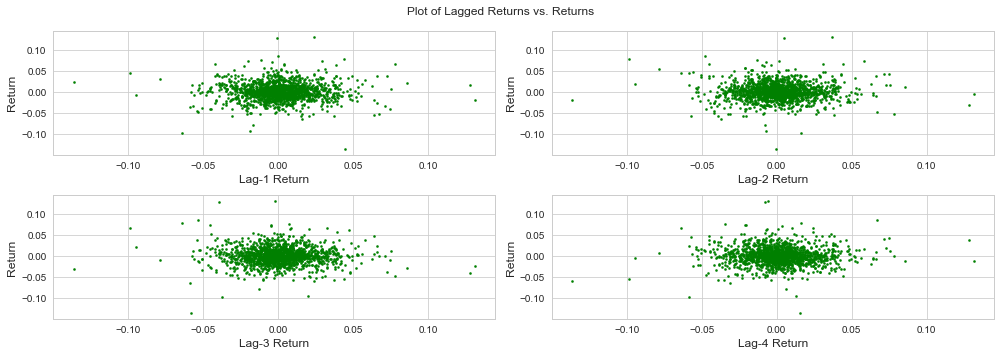

In [29]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(14,5))
for i in range(2):
    for j in range(2):
        ax[i][j].scatter(train_returns.shift(i*2+j+1),train_returns,s=4,c='g')
        ax[i][j].set_xlabel(f'Lag-{i*2+j+1} Return')
        ax[i][j].set_ylabel('Return')

plt.suptitle('Plot of Lagged Returns vs. Returns')
plt.tight_layout()

From the visual inspection of the above graph, there does not seem to be To check the maximum lags to be included, we use the PACF function of the lags which gives an idea about the linear dependence of the lags.

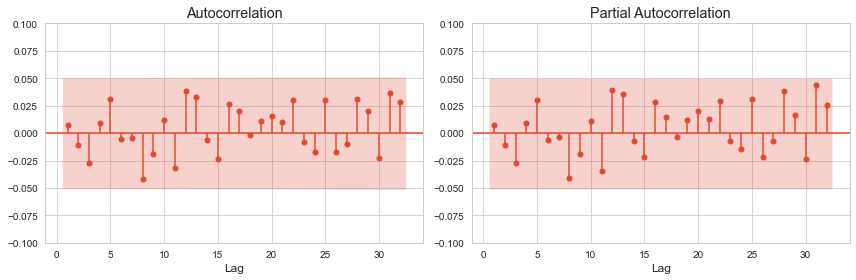

In [30]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
plot_acf(train_returns.values,ax=ax[0],zero=False)
ax[0].set_xlabel('Lag')
ax[0].set_ylim((-0.1,0.1))
plot_pacf(train_returns.values,ax=ax[1],zero=False)
ax[1].set_xlabel('Lag')
ax[1].set_ylim((-0.1,0.1))
plt.tight_layout()
plt.show()

The graphs show that lagged returns show no significant autocorrelation and linear dependence.

#### 4.2.2 Price Movements

Price movements refers to Open Minus Previous Close, High Minus Low and Close Minus Open.

In [31]:
o_c = (stock_data['Open']/stock_data['Close'].shift(1)).fillna(1)
h_l = stock_data['High'] / stock_data['Low']
c_l = stock_data['Close']/stock_data['Low']

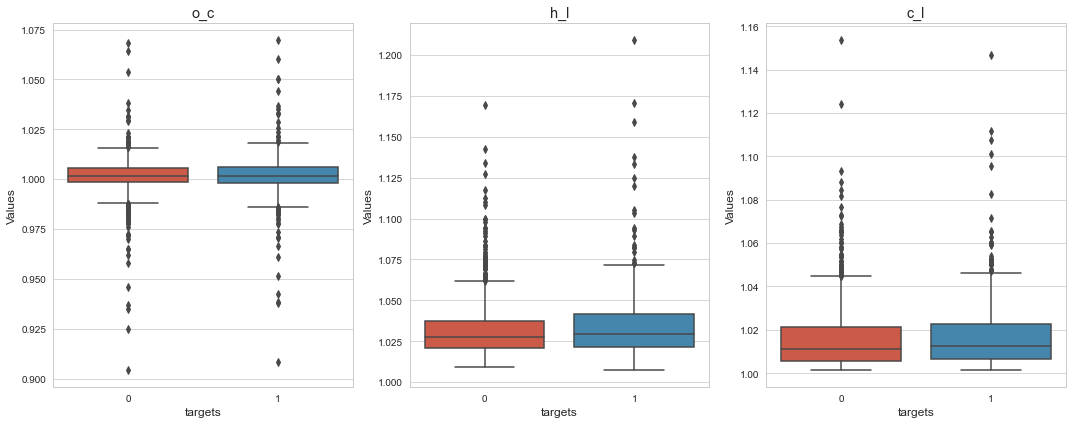

In [32]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,6))
f =['o_c','h_l','c_l']
for i in range(3):
    sns.boxplot(data = pd.DataFrame({'Values':eval(f[i]).loc[train_start:train_end],
                                     'targets':train_Y}),
                x='targets',y='Values',ax=ax[i])
    
    ax[i].set_title(f[i])
    
plt.tight_layout()

The above graph shows that the features do not do good in discriminating between the class labels. High Minus Low is slightly better in discriminating between the targets and values.

#### 4.2.3 Volume

In [33]:
mean_volume =  stock_data['Volume'].loc[train_start:train_end].mean()
std_volume = stock_data['Volume'].loc[train_start:train_end].std()

volume_zscore = (stock_data['Volume']-mean_volume)/std_volume

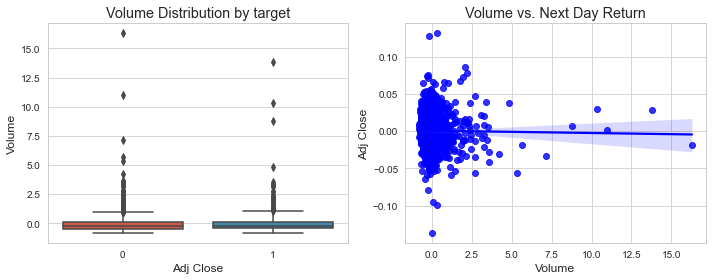

In [34]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.boxplot(x=train_Y,y=volume_zscore.loc[train_start:train_end],ax = ax[0])
sns.regplot(x=volume_zscore.loc[train_start:train_end],
            y=returns.shift(-1).fillna(0).loc[train_start:train_end],ax=ax[1],color='b')
ax[0].set_title('Volume Distribution by target')
ax[1].set_title('Volume vs. Next Day Return')
plt.tight_layout()

The first graph shows the distribution of volume by the target return. We can see that there is no difference in the distribution meaning higher volume does not really affect next day return. The second plot is regression plot for Volume against Next Day Returns which also confirms this.

#### 4.2.4 Day/Time Features

The day features are included to capture on calendar anamolies if they exist. We encode them using OneHotEncoding. OneHotEncoding is done on the entire data set since it does not matter in this case to separate train and test data.

In [35]:
# One Hot Encoding for month
encoder = OneHotEncoder()
month_num = stock_data.index.month.values.reshape(-1,1)
month_coded = encoder.fit_transform(month_num).toarray()
month_coded = pd.DataFrame(month_coded,
                           index = stock_data.index,
                           columns = ['Month:'+str(i) for i in encoder.categories_[0]])

In [36]:
# One Hot Encoding for Day of Week
encoder = OneHotEncoder()
day_of_week_num = stock_data.index.day_of_week.values.reshape(-1,1)
day_of_week_coded = encoder.fit_transform(day_of_week_num).toarray()
day_of_week_coded = pd.DataFrame(day_of_week_coded,
                           index = stock_data.index)

day_of_week_coded = day_of_week_coded.rename(columns= {0:'Day:Monday',1:'Day:Tuesday',
                                      2:'Day:Wednesday',3:'Day:Thursday',
                                      4:'Day:Friday',5:'Day:Saturday',6:'Day:Sunday'})
                           

In [37]:
month_ctab = np.round(pd.crosstab(index = train_Y.values,colnames=['Month Num'],rownames=['Target'],
            columns=stock_data.loc[train_start:train_end].index.month,
            normalize='columns'),3)
month_ctab.columns = month_coded.columns
month_ctab

Month:1  Month:2  Month:3  Month:4  Month:5  Month:6  Month:7  \
Target                                                                  
0         0.647    0.647    0.631    0.632    0.595    0.646    0.649   
1         0.353    0.353    0.369    0.368    0.405    0.354    0.351   

        Month:8  Month:9  Month:10  Month:11  Month:12  
Target                                                  
0         0.516     0.61     0.603     0.626     0.609  
1         0.484     0.39     0.397     0.374     0.391

In [38]:
day_ctab = np.round(pd.crosstab(index = train_Y.values,colnames=['Week Num'],rownames=['Target'],
            columns=stock_data.loc[train_start:train_end].index.day_of_week,
            normalize='columns'),3)
day_ctab.columns = day_of_week_coded.columns
day_ctab

Day:Monday  Day:Tuesday  Day:Wednesday  Day:Thursday  Day:Friday  \
Target                                                                     
0            0.595        0.659          0.652         0.571       0.614   
1            0.405        0.341          0.348         0.429       0.386   

        Day:Saturday  Day:Sunday  
Target                            
0                1.0         0.0  
1                0.0         1.0

From the table above, Monday and Thursday seems to have lower higher probability of higher returns than other days

In [39]:
last_week_of_month = stock_data.index.day>=stock_data.index.days_in_month-7
last_week_of_month = pd.Series(last_week_of_month,index=stock_data.index,name='last_week')

#### 4.2.5 Lagged Target values

On top of the basic features, we also add lagged values of the target variable.

In [40]:
lagged_targets = pd.DataFrame({f'target_lag_{i+1}':target.shift(i+1).fillna(0) for i in range(3)})

#### 4.2.6 Summary of Basic Features

In [41]:
basic_cont_features = pd.DataFrame({'returns_Lag_0':returns,'returns_Lag_1':returns.shift(1).fillna(0),
                                    'returns_Lag_2':returns.shift(2).fillna(0),'open_minus_prev_close':o_c,
                               'high_minus_low':h_l,'close_minus_low':c_l,'volume_scaled':volume_zscore
                              })

cont_features_list = [*basic_cont_features.columns]

basic_cat_features = pd.concat([lagged_targets,month_coded,day_of_week_coded,last_week_of_month],axis=1)
cat_features_list = [*basic_cat_features.columns]

basic_features = pd.concat([basic_cont_features,basic_cat_features],axis=1)
basic_features.shape

(1669, 30)

In [42]:
print(f'No. of basic features extracted: {basic_features.shape[1]}')

No. of basic features extracted: 30


### 4.3 Technical Features

#### 4.3.1 Feature Extraction - Indicators

From the indicators extracted in the ```indicators``` section, we extract features that can be used by the NN model to predict the trend.

In [43]:
# SMA location : 1-SMA/Close
sma_location =  1- sma.loc[train_start:]/stock_data['Adj Close'].values.reshape(-1,1)
sma_location.columns = ['sma_loc:'+ col.lower() for col in sma_location.columns]

# SMA Crossover: SMA_short-SMA_long
sma_cross_over = sma.pct_change(axis=1).loc[train_start:].iloc[:,1:]
sma_cross_over.columns = [f'sma_crossover:{sma.columns[i].lower()}_cross_{sma.columns[i-1].lower()}' 
                          for i in range(1,len(sma.columns))]

# EMA Location : 1-EMA/Close
ema_location =  1- ema.loc[train_start:]/stock_data['Adj Close'].values.reshape(-1,1)
ema_location.columns = ['ema_loc:'+ col.lower() for col in ema_location.columns]

# EMA Cross Over: EMA_short-EMA_long
ema_cross_over = ema.pct_change(axis=1).loc[train_start:].iloc[:,1:]
ema_cross_over.columns = [f'ema_crossover:{ema.columns[i].lower()}_cross_{ema.columns[i-1].lower()}' 
                          for i in range(1,len(ema.columns))]

# Slope : No FE required
slope_f = slope.loc[train_start:train_end]
slope_f.columns = ['slope:slope_'+col.lower().split('_')[1] for col in slope.columns]

# RSI: No FE Required
rsi_f = rsi.loc[train_start:]
rsi_f.columns = ['rsi:'+col.lower() for col in rsi.columns]

# ATR : Normalized based on current range
atr_norm = atr.loc[train_start:]/tr.loc[train_start:].values.reshape(-1,1)
atr_norm.columns = ['atr_norm:'+col.lower() for col in atr_norm.columns]

# BBands : Range
bb_range = bbands[[col for col in bbands.columns if col.split("_")[0] == 'BBB']].loc[train_start:]
bb_range.columns = [f'bb_range:bb_{col.split("_")[1]}' for col in bb_range.columns]

# BBands : Percentile of current price
bb_percentile = bbands[[col for col in bbands.columns if col.split("_")[0] == 'BBP']].loc[train_start:]
bb_percentile.columns = [f'bb_percentile:bb_{col.split("_")[1]}' for col in bb_percentile.columns]

# ADX : No FE Required
adx_f =  adx.loc[train_start:]
adx_f.columns = [f'adx:{col.lower()}' for col in adx_f.columns]

# pvr : One Hot Encoding
encoder = OneHotEncoder()
encoder.fit(pvr.loc[:train_end].values.reshape(-1,1))
pvr_f = encoder.transform(pvr.loc[train_start:].values.reshape(-1,1)).toarray()
pvr_f = pd.DataFrame(pvr_f,index = stock_data.index, columns =[f'pvr:rank_{int(cat)}' for cat in encoder.categories_[0]])

# Stoch - k level:
stoch_osc_k = stoch_osc[[col for col in stoch_osc.columns if col.split("_")[0]=='STOCHk']].loc[train_start:]
stoch_osc_k.columns = [f'stoch_osc:k_{col.split("_")[1]}' for col in stoch_osc_k.columns]

# Stoch - k-d Difference:
stoch_osc_d = stoch_osc[[col for col in stoch_osc.columns if col.split("_")[0]=='STOCHd']].loc[train_start:]
stoch_osc_k_d = pd.DataFrame([1-stoch_osc_d.iloc[:,i]/stoch_osc_k.iloc[:,i] for i in range(len(stoch_osc_k.columns))]).T
stoch_osc_k_d.columns = [f'stoch_osc:k_d_{col.split("_")[2]}' for col in stoch_osc_k.columns]

#CMF - No FE required
cmf_f = cmf.loc[train_start:]
cmf_f.columns = [f'cmf:{col.lower()}' for col in cmf_f.columns]


In [44]:
indicator_features = pd.concat([sma_location,sma_cross_over,ema_location,ema_cross_over,rsi_f,atr_norm,
              bb_range,bb_percentile,adx_f,pvr_f,stoch_osc_k,stoch_osc_k_d,cmf_f],axis=1)

In [45]:
indicator_features.shape

(1669, 48)

Some features inherently have a range between 0 and 100 while others are continuous. The continuous features are standardized and the remaining features are normalized to have a range of 0 to 1.

In [46]:
indicators_cont_features = indicator_features[[*sma_location.columns,*sma_cross_over.columns,
                     *ema_location.columns,*ema_cross_over.columns,
                     *stoch_osc_k_d.columns]]

indicator_features[[*indicators_cont_features.columns]] = (indicators_cont_features - indicators_cont_features.loc[train_start:train_end].mean())/indicators_cont_features.loc[train_start:train_end].std()

range_features = indicator_features[[*rsi_f.columns,*atr_norm.columns,*bb_range,*bb_percentile,*adx_f,*stoch_osc_k,*cmf_f]]
indicator_features[[*range_features.columns]] /= 100

cont_features_list.extend([*indicators_cont_features.columns,*range_features.columns])
cat_features_list.extend([*pvr_f.columns])

#### 4.3.2 Feature Extraction - CandleStick Patterns

The candle stick patterns are simply one hot encoded so that a value of 1 represents a bearish or bullish pattern.

In [47]:
candles_neg_1 = np.where(cdls==-1,1,0)
candles_neg_1 = pd.DataFrame(candles_neg_1,index = cdls.index, 
                             columns = [f'{col.lower()}_class:-1' for col in cdls.columns])
                             
candles_neg_1 = candles_neg_1.drop(candles_neg_1.columns[np.all(candles_neg_1==0,axis=0)],axis=1)

candles_neg_2 = np.where(cdls==-2,1,0)
candles_neg_2 = pd.DataFrame(candles_neg_2,index = cdls.index, 
                             columns = [f'{col.lower()}_class:-2' for col in cdls.columns])

candles_neg_2 = candles_neg_2.drop(candles_neg_2.columns[np.all(candles_neg_2==0,axis=0)],axis=1)
                    
candles_pos_1 = np.where(cdls==1,1,0)
candles_pos_1 = pd.DataFrame(candles_pos_1,index = cdls.index, 
                             columns = [f'{col.lower()}_class:1' for col in cdls.columns])

candles_pos_1 = candles_pos_1.drop(candles_pos_1.columns[np.all(candles_pos_1==0,axis=0)],axis=1)
                             
candles_pos_2 = np.where(cdls==2,1,0)
candles_pos_2 = pd.DataFrame(candles_pos_2,index = cdls.index, 
                             columns = [f'{col.lower()}_class:2' for col in cdls.columns])

candles_pos_2 = candles_pos_2.drop(candles_pos_2.columns[np.all(candles_pos_2==0,axis=0)],axis=1)

candles_features = pd.concat([candles_neg_1,candles_neg_2,candles_pos_1,candles_pos_2],
                             axis=1).loc[train_start:]

cat_features_list.extend([*candles_features.columns])


In [48]:
candles_features.shape

(1669, 69)

In [49]:
technical_features = pd.concat([indicator_features,candles_features],axis=1)

In [50]:
print(f'No. of technical features extracted: {technical_features.shape[1]}')

No. of technical features extracted: 117


#### 4.3.3 Feature Selection using Lasso Logistic Regression

The idea is use to a simple base case algorithm to select a subset of features that are better at predicting the model. In this project, we choose the ```Lasso Logistic Regression``` model to eliminate features that have no predictive power. We also considered algorithms like ```random forest feature importances``` and ```Boruta```. However, tree based models were not able to correctly capture the feature importance of One Hot Encoded variables. 

In [51]:
basic_technical_features = pd.concat([basic_features,technical_features],axis=1)
basic_technical_features.shape

(1669, 147)

In [52]:
# Checking the base case logistic model:
logistic_model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',tol=1e-3,random_state=12)

logistic_model.fit(basic_technical_features.loc[train_start:train_end],train_Y.values)

base_prediction_1 = logistic_model.predict(basic_technical_features.loc[valid_start:valid_end])

<Figure size 720x360 with 0 Axes>

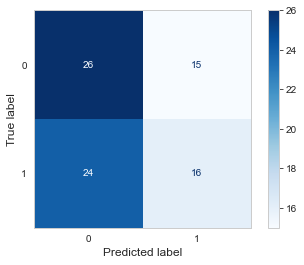

In [53]:
plt.figure(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(valid_Y,base_prediction_1,
                                        cmap='Blues')
plt.grid()

In [54]:
print(classification_report(valid_Y,y_pred=base_prediction_1))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57        41
           1       0.52      0.40      0.45        40

    accuracy                           0.52        81
   macro avg       0.52      0.52      0.51        81
weighted avg       0.52      0.52      0.51        81



In [55]:
logistic_model.fit(basic_technical_features.loc[train_start:train_end],train_Y.values)
coefs = pd.Series(logistic_model.coef_[0],index = basic_technical_features.columns,name='Logistic Reg Coefs')
print(f'No. of features removed: {(coefs==0).sum()}')

No. of features removed: 85


Out of 147 features tested, ~90 features have a coefficient of zero. The parameter ```C``` is varied to find a better model before removing the irrelevant features. A time series cross validation approach is taken to find the best C value.

In [56]:
params = {'C':[0.1,1,10,100,500,1000,5000]}
tscv = TimeSeriesSplit(n_splits=4,test_size= 50)
search = GridSearchCV(logistic_model,params,cv=tscv,scoring=make_scorer(f1_score),verbose=1)
cv_results = search.fit(basic_technical_features.loc[train_start:train_end],train_Y.values)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


In [57]:
pd.DataFrame(cv_results.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.011006      0.001230         0.004001    1.192093e-07     0.1   
1       0.044010      0.007143         0.003751    4.329814e-04       1   
2       0.598135      0.044106         0.002750    8.291323e-04      10   
3       3.595815      0.852541         0.003751    4.330157e-04     100   
4       4.363246      0.624778         0.003750    4.328440e-04     500   
5       3.819366      1.293320         0.003501    5.001426e-04    1000   
6       5.038395      0.791357         0.004001    1.032383e-07    5000   

        params  split0_test_score  split1_test_score  split2_test_score  \
0   {'C': 0.1}           0.300000           0.294118           0.363636   
1     {'C': 1}           0.333333           0.285714           0.380952   
2    {'C': 10}           0.181818           0.333333           0.340426   
3   {'C': 100}           0.468085           0.500000           0.400000   
4   {'C': 500}           0.500000           0.473684           0.461538   
5  {'C': 1000}           0.434783           0.500000           0.431373   
6  {'C': 5000}           0.400000           0.500000           0.423077   

   split3_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.488889         0.361661        0.078350                4  
1           0.222222         0.305556        0.058725                6  
2           0.000000         0.213894        0.138794                7  
3           0.086957         0.363760        0.163843                2  
4           0.086957         0.380545        0.170072                1  
5           0.086957         0.363278        0.161861                3  
6           0.086957         0.352508        0.157724                5

In [58]:
# Using the best model for feature selection
logistic_model = cv_results.best_estimator_
logistic_model.fit(basic_technical_features.loc[train_start:train_end],train_Y.values)

base_prediction_2 = logistic_model.predict(basic_technical_features.loc[valid_start:valid_end])

<Figure size 432x216 with 0 Axes>

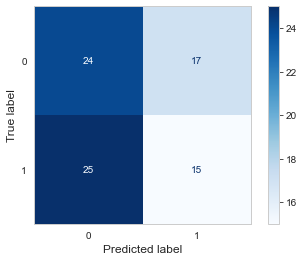

In [59]:
plt.figure(figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(valid_Y,base_prediction_2,
                                        cmap='Blues')
plt.grid()

In [60]:
print(classification_report(valid_Y,y_pred=base_prediction_2))

              precision    recall  f1-score   support

           0       0.49      0.59      0.53        41
           1       0.47      0.38      0.42        40

    accuracy                           0.48        81
   macro avg       0.48      0.48      0.47        81
weighted avg       0.48      0.48      0.48        81



The model performs poorly in the validation data set.

In [61]:
logistic_model.fit(basic_technical_features.loc[train_start:train_end],train_Y.values)
coefs = pd.Series(logistic_model.coef_[0],index = basic_technical_features.columns,name='Logistic Reg Coefs')
print(f'No. of features removed: {(coefs==0).sum()}')
print(f'Eliminated Feature: {coefs[coefs==0].index}')

No. of features removed: 1
Eliminated Feature: Index(['cdl_dragonflydoji_class:1'], dtype='object')


In [62]:
basic_technical_features_selected = basic_technical_features.drop(coefs[coefs==0].index,axis=1)
basic_technical_features_selected.shape

(1669, 146)

In [63]:
feature_eliminated = coefs[coefs==0].index

for f in feature_eliminated:
    if f in cont_features_list:
        cont_features_list.remove(f)

#### 4.3.4 Dimensionality Reduction of continuous features

The correlation matrix of the continuous variables is explored below.

In [64]:
cont_features_cor_matrix = pd.DataFrame(np.corrcoef(basic_technical_features_selected.loc[train_start:train_end,cont_features_list].astype('float'),
                                      rowvar=False),
                          index = cont_features_list,
                          columns= cont_features_list)

Text(0.5, 1.0, 'Correlation map of Continuous features')

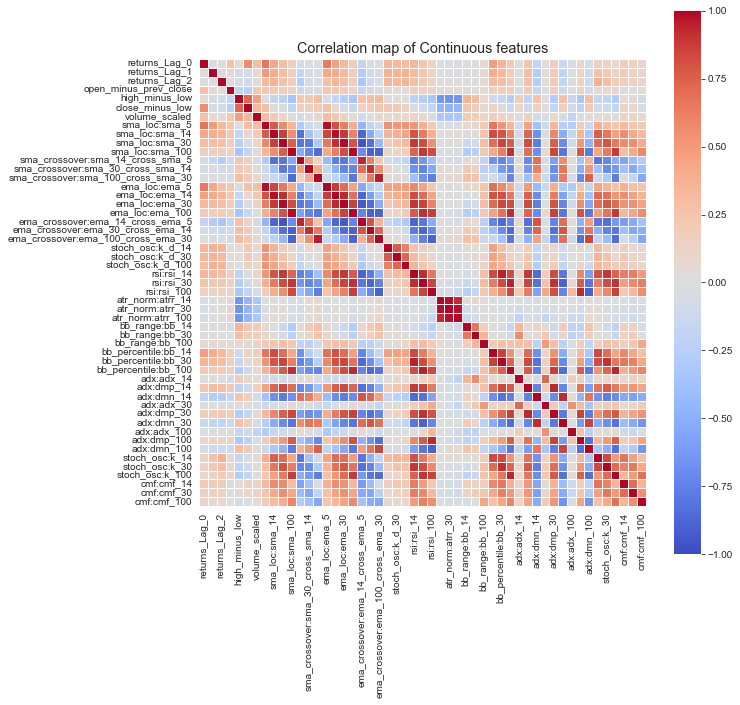

In [65]:
plt.figure(figsize=(10,10))
sns.heatmap(cont_features_cor_matrix,cmap='coolwarm',square=True,linecolor='w',linewidths=1,
            vmax=1,vmin=-1)
plt.title('Correlation map of Continuous features')

Dimensionality reduction is done on the continous features using autoencoders. Below code implements the NN architecture for auto encoders.

In [66]:
def auto_encoder_model_cont(reduced_dim,activation_ = 'relu',epochs=300,patience=20):

    encoder = keras.models.Sequential(
        [keras.layers.InputLayer(input_shape=(len(cont_features_list))),
         keras.layers.Dropout(rate = 0.1),
         keras.layers.Dense(reduced_dim,activation = activation_, 
                            kernel_initializer='glorot_normal',
                            kernel_regularizer=keras.regularizers.l2(l2=0.1))
    ])

    decoder = keras.models.Sequential(
         [keras.layers.Dense(reduced_dim,activation=activation_,
                             kernel_initializer='glorot_normal',
                             input_shape=[reduced_dim],
                            ),
         keras.layers.Dense(len(cont_features_list),kernel_initializer='glorot_normal',
                            bias_initializer='glorot_normal')
    ])
    
    auto_encoder = keras.models.Sequential([encoder,decoder])
    auto_encoder.compile(optimizer= 'adam',loss= keras.losses.MeanSquaredError())


    auto_encoder.fit(x=basic_technical_features_selected[cont_features_list].loc[train_start:train_end].values,
                    y = basic_technical_features_selected[cont_features_list].loc[train_start:train_end].values,
                    epochs=epochs,shuffle=False, 
                     validation_data= (basic_technical_features_selected[cont_features_list].loc[valid_start:valid_end],
                                        basic_technical_features_selected[cont_features_list].loc[valid_start:valid_end]),
                     callbacks= [keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)])
    
    return auto_encoder

In [67]:
def base_prediction_logistic_model(X,y):
    model = LogisticRegression(penalty='l2',class_weight='balanced',random_state=12) # use simple logistic model for prediction
    model.fit(X.loc[train_start:train_end],y.loc[train_start:train_end])
    preds = model.predict(X.loc[valid_start:valid_end])
    accuracy = accuracy_score(y.loc[valid_start:valid_end],preds)
    f1 = f1_score(y.loc[valid_start:valid_end],preds)
    return [accuracy,f1]

In [218]:
dims_list = [5,10,15,20,25,30]
X = basic_technical_features_selected.drop(cont_features_list,axis=1)
metrics = {'Reconstruction Error':[],'Accuracy':[],'F1':[]}

for dim in dims_list:
    reconstruction_error,accuracy_val,f1score = 0,0,0
    for i in range(10):
        auto_encoder = auto_encoder_model_cont(dim,epochs=100,patience=10)
        reconstruction_error += auto_encoder.history.history['val_loss'][-1]*1/10
        encoder = auto_encoder.get_layer(index=0)
        reduced_features = encoder.predict(basic_technical_features_selected[cont_features_list])
        reduced_features = pd.DataFrame(reduced_features,columns = [f'Reduced_Feature:{i+1}' for i in range(dim)],
                                        index = indicator_features.index)
        
        X_complete = pd.concat([X,reduced_features],axis=1)
        m = base_prediction_logistic_model(X_complete,target)
        accuracy_val += m[0]*1/10
        f1score += m[1]*1/10
     
    metrics['Reconstruction Error'].append(reconstruction_error)
    metrics['Accuracy'].append(accuracy_val)
    metrics['F1'].append(f1score)

Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 1.2498 - val_loss: 0.9531
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 0.9591 - val_loss: 0.7168
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 0.7613 - val_loss: 0.5473
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.6186 - val_loss: 0.4169
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 0.5115 - val_loss: 0.3224
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4255 - val_loss: 0.2583
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3502 - val_loss: 0.2103
Epoch 8/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2959 - val_loss: 0.1755
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2619 - val_loss: 0.1505
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2401 - val_loss: 0.1327
Epoch 11/

48/48 [==============================] - 0s 1ms/step - loss: 0.1023 - val_loss: 0.0589
Epoch 84/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1022 - val_loss: 0.0615
Epoch 85/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1025 - val_loss: 0.0585
Epoch 86/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1024 - val_loss: 0.0601
Epoch 87/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1037 - val_loss: 0.0603
Epoch 88/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1015 - val_loss: 0.0582
Epoch 89/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1008 - val_loss: 0.0600
Epoch 90/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0580
Epoch 91/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1006 - val_loss: 0.0608
Epoch 92/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0995 - val_loss: 0.0585
Epoch 93/100


48/48 [==============================] - 0s 1ms/step - loss: 0.1116 - val_loss: 0.0629
Epoch 46/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1114 - val_loss: 0.0631
Epoch 47/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1117 - val_loss: 0.0623
Epoch 48/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1111 - val_loss: 0.0624
Epoch 49/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1102 - val_loss: 0.0619
Epoch 50/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1111 - val_loss: 0.0631
Epoch 51/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1097 - val_loss: 0.0623
Epoch 52/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1094 - val_loss: 0.0615
Epoch 53/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1100 - val_loss: 0.0632
Epoch 54/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1093 - val_loss: 0.0622
Epoch 55/100


48/48 [==============================] - 0s 2ms/step - loss: 0.1670 - val_loss: 0.0928
Epoch 26/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1630 - val_loss: 0.0915
Epoch 27/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1592 - val_loss: 0.0899
Epoch 28/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1554 - val_loss: 0.0889
Epoch 29/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1517 - val_loss: 0.0870
Epoch 30/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1478 - val_loss: 0.0860
Epoch 31/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1461 - val_loss: 0.0848
Epoch 32/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1424 - val_loss: 0.0830
Epoch 33/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1396 - val_loss: 0.0817
Epoch 34/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1368 - val_loss: 0.0802
Epoch 35/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0998 - val_loss: 0.0559
Epoch 89/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0988 - val_loss: 0.0596
Epoch 90/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0982 - val_loss: 0.0554
Epoch 91/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0984 - val_loss: 0.0591
Epoch 92/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0968 - val_loss: 0.0550
Epoch 93/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0965 - val_loss: 0.0549
Epoch 94/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0960 - val_loss: 0.0554
Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.0559
Epoch 96/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0544
Epoch 97/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0928 - val_loss: 0.0545
Epoch 98/100


48/48 [==============================] - 0s 1ms/step - loss: 0.1080 - val_loss: 0.0599
Epoch 58/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1086 - val_loss: 0.0597
Epoch 59/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1076 - val_loss: 0.0592
Epoch 60/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1074 - val_loss: 0.0600
Epoch 61/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1070 - val_loss: 0.0592
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1082 - val_loss: 0.0593
Epoch 63/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1060 - val_loss: 0.0592
Epoch 64/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1061 - val_loss: 0.0593
Epoch 65/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 0.0587
Epoch 66/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1047 - val_loss: 0.0585
Epoch 67/100


48/48 [==============================] - 0s 2ms/step - loss: 0.1851 - val_loss: 0.1083
Epoch 20/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1825 - val_loss: 0.1057
Epoch 21/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1797 - val_loss: 0.1029
Epoch 22/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1769 - val_loss: 0.1007
Epoch 23/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1738 - val_loss: 0.0985
Epoch 24/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1694 - val_loss: 0.0959
Epoch 25/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1656 - val_loss: 0.0930
Epoch 26/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1609 - val_loss: 0.0904
Epoch 27/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1563 - val_loss: 0.0879
Epoch 28/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1517 - val_loss: 0.0857
Epoch 29/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0466
Epoch 83/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0451
Epoch 84/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0447
Epoch 85/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0453
Epoch 86/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0477
Epoch 87/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0479
Epoch 88/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0467
Epoch 89/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0454
Epoch 90/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0440
Epoch 91/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0466
Epoch 92/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0929 - val_loss: 0.0570
Epoch 45/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0915 - val_loss: 0.0551
Epoch 46/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0904 - val_loss: 0.0553
Epoch 47/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0905 - val_loss: 0.0540
Epoch 48/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0891 - val_loss: 0.0536
Epoch 49/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0873 - val_loss: 0.0525
Epoch 50/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0888 - val_loss: 0.0582
Epoch 51/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0868 - val_loss: 0.0529
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0849 - val_loss: 0.0508
Epoch 53/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0845 - val_loss: 0.0521
Epoch 54/100


48/48 [==============================] - 0s 2ms/step - loss: 0.4119 - val_loss: 0.2886
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3298 - val_loss: 0.2277
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2770 - val_loss: 0.1860
Epoch 9/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2412 - val_loss: 0.1575
Epoch 10/100
48/48 [==============================] - 0s 1ms/step - loss: 0.2147 - val_loss: 0.1375
Epoch 11/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1936 - val_loss: 0.1219
Epoch 12/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1771 - val_loss: 0.1099
Epoch 13/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1630 - val_loss: 0.1000
Epoch 14/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1523 - val_loss: 0.0919
Epoch 15/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1445 - val_loss: 0.0860
Epoch 16/100
48/

48/48 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0498
Epoch 88/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0447
Epoch 89/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0466
Epoch 90/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0446
Epoch 91/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0490
Epoch 92/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0440
Epoch 93/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0440
Epoch 94/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0443
Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0459
Epoch 96/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0459
Epoch 97/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0524
Epoch 50/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0586
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0521
Epoch 52/100
53/53 [==============================] - 0s 616us/step
Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 1.8841 - val_loss: 1.4494
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 1.3456 - val_loss: 1.0126
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 0.9837 - val_loss: 0.7114
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.7357 - val_loss: 0.5087
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5675 - val_loss: 0.3698
Epoch 6/100
48/48 [==============================] - 0s 1ms/step - loss: 0.4442 - val_loss: 0.2734
Epoch 7/100
48/48 [==============================] 

48/48 [==============================] - 0s 2ms/step - loss: 0.0839 - val_loss: 0.0508
Epoch 60/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0836 - val_loss: 0.0524
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0527
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0858 - val_loss: 0.0548
Epoch 63/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0539
Epoch 64/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0530
Epoch 65/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0506
Epoch 66/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0807 - val_loss: 0.0506
Epoch 67/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0497
Epoch 68/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0811 - val_loss: 0.0503
Epoch 69/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0885 - val_loss: 0.0544
Epoch 29/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0532
Epoch 30/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0845 - val_loss: 0.0529
Epoch 31/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0532
Epoch 32/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0828 - val_loss: 0.0529
Epoch 33/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0517
Epoch 34/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.0515
Epoch 35/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0526
Epoch 36/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0514
Epoch 37/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0514
Epoch 38/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0370
Epoch 92/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0504 - val_loss: 0.0313
Epoch 93/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0307
Epoch 94/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0295
Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0326
Epoch 96/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0306
Epoch 97/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0328
Epoch 98/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0296
Epoch 99/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0326
Epoch 100/100
53/53 [==============================] - 0s 885us/step
Epoch 1/100
48/48 [=========================

48/48 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0496
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0503
Epoch 55/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0507
Epoch 56/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0518
Epoch 57/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0513
Epoch 58/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0508
Epoch 59/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0476
Epoch 60/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0523
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0546
Epoch 62/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0549
Epoch 63/100


48/48 [==============================] - 0s 2ms/step - loss: 0.1152 - val_loss: 0.0684
Epoch 16/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1098 - val_loss: 0.0653
Epoch 17/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1042 - val_loss: 0.0630
Epoch 18/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0606
Epoch 19/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0967 - val_loss: 0.0590
Epoch 20/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0938 - val_loss: 0.0577
Epoch 21/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0912 - val_loss: 0.0569
Epoch 22/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0901 - val_loss: 0.0554
Epoch 23/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0892 - val_loss: 0.0545
Epoch 24/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0547
Epoch 25/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0800 - val_loss: 0.0549
Epoch 35/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0556
Epoch 36/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0774 - val_loss: 0.0558
Epoch 37/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0545
Epoch 38/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0761 - val_loss: 0.0594
Epoch 39/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0769 - val_loss: 0.0588
Epoch 40/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0746 - val_loss: 0.0564
Epoch 41/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0555
Epoch 42/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0549
Epoch 43/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0533
Epoch 44/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0514 - val_loss: 0.0399
Epoch 98/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0364
Epoch 99/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0501 - val_loss: 0.0381
Epoch 100/100
53/53 [==============================] - 0s 654us/step
Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 2.8553 - val_loss: 2.1595
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 1.8952 - val_loss: 1.4055
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 1.2807 - val_loss: 0.9173
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.8706 - val_loss: 0.6075
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5916 - val_loss: 0.4047
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.4113 - val_loss: 0.2730
Epoch 7/100
48/48 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0369
Epoch 60/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0366
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0373
Epoch 62/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0392
Epoch 63/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.0386
Epoch 64/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0370
Epoch 65/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0341
Epoch 66/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0478 - val_loss: 0.0358
Epoch 67/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0338
Epoch 68/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0392
Epoch 69/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0894 - val_loss: 0.0521
Epoch 22/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0516
Epoch 23/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0887 - val_loss: 0.0529
Epoch 24/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0875 - val_loss: 0.0542
Epoch 25/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0500
Epoch 26/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0505
Epoch 27/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0507
Epoch 28/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0506
Epoch 29/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0494
Epoch 30/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0790 - val_loss: 0.0506
Epoch 31/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0438 - val_loss: 0.0344
Epoch 85/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0332
Epoch 86/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0383
Epoch 87/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0327
Epoch 88/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0338
Epoch 89/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0450 - val_loss: 0.0392
Epoch 90/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0485 - val_loss: 0.0331
Epoch 91/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0340
Epoch 92/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0331
Epoch 93/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0321
Epoch 94/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0473
Epoch 47/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0460
Epoch 48/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0440
Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0436
Epoch 50/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0555
Epoch 51/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0472
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0418
Epoch 53/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0417
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0408
Epoch 55/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0411
Epoch 56/100


48/48 [==============================] - 0s 1ms/step - loss: 0.0789 - val_loss: 0.0556
Epoch 32/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0775 - val_loss: 0.0557
Epoch 33/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0747 - val_loss: 0.0515
Epoch 34/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0519
Epoch 35/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0492
Epoch 36/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0521
Epoch 37/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0488
Epoch 38/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0516
Epoch 39/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0499
Epoch 40/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0494
Epoch 41/100


53/53 [==============================] - 0s 1ms/step
Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 3.1014 - val_loss: 2.3067
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 1.9669 - val_loss: 1.4272
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 1.2621 - val_loss: 0.8809
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.8251 - val_loss: 0.5549
Epoch 5/100
48/48 [==============================] - 0s 1ms/step - loss: 0.5560 - val_loss: 0.3626
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3896 - val_loss: 0.2464
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2871 - val_loss: 0.1762
Epoch 8/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2221 - val_loss: 0.1333
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1815 - val_loss: 0.1068
Epoch 10/100
48/48 [==============================] - 0s

Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5582 - val_loss: 0.3945
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3874 - val_loss: 0.2647
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2835 - val_loss: 0.1864
Epoch 8/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2192 - val_loss: 0.1393
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1797 - val_loss: 0.1094
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1545 - val_loss: 0.0913
Epoch 11/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1376 - val_loss: 0.0803
Epoch 12/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1272 - val_loss: 0.0731
Epoch 13/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1188 - val_loss: 0.0686
Epoch 14/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1111 - val_loss: 0.0652
Epoch

Epoch 87/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0477 - val_loss: 0.0380
Epoch 88/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0475 - val_loss: 0.0371
Epoch 89/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0380
Epoch 90/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0351
Epoch 91/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0386
Epoch 92/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0336
Epoch 93/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0490 - val_loss: 0.0358
Epoch 94/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0314
Epoch 95/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0378
Epoch 96/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0419


48/48 [==============================] - 0s 1ms/step - loss: 0.0481 - val_loss: 0.0324
Epoch 73/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0345
Epoch 74/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0430
Epoch 75/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0337
Epoch 76/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0397
Epoch 77/100
53/53 [==============================] - 0s 635us/step
Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 3.1556 - val_loss: 2.3761
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 2.0042 - val_loss: 1.5233
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 1.2982 - val_loss: 0.9730
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.8430 - val_loss: 0.6207
Epoch 5/100
48/48 [==============================

53/53 [==============================] - 0s 654us/step
Epoch 1/100
48/48 [==============================] - 1s 3ms/step - loss: 3.0523 - val_loss: 2.2570
Epoch 2/100
48/48 [==============================] - 0s 1ms/step - loss: 1.9352 - val_loss: 1.3920
Epoch 3/100
48/48 [==============================] - 0s 2ms/step - loss: 1.2369 - val_loss: 0.8588
Epoch 4/100
48/48 [==============================] - 0s 1ms/step - loss: 0.7937 - val_loss: 0.5368
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5177 - val_loss: 0.3423
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.3522 - val_loss: 0.2270
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.2541 - val_loss: 0.1595
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 0.1946 - val_loss: 0.1198
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.1601 - val_loss: 0.0961
Epoch 10/100
48/48 [==============================] - 

48/48 [==============================] - 0s 2ms/step - loss: 0.1045 - val_loss: 0.0610
Epoch 17/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0991 - val_loss: 0.0601
Epoch 18/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0958 - val_loss: 0.0592
Epoch 19/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0932 - val_loss: 0.0580
Epoch 20/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0896 - val_loss: 0.0574
Epoch 21/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0871 - val_loss: 0.0571
Epoch 22/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0864 - val_loss: 0.0558
Epoch 23/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0845 - val_loss: 0.0566
Epoch 24/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0581
Epoch 25/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0545
Epoch 26/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0463
Epoch 30/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0413
Epoch 31/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0458
Epoch 32/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0461
Epoch 33/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0385
Epoch 34/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0387
Epoch 35/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0568 - val_loss: 0.0390
Epoch 36/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0421
Epoch 37/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0373
Epoch 38/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0365
Epoch 39/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0287
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0321
Epoch 55/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0272
Epoch 56/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0294
Epoch 57/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0295
Epoch 58/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0284
Epoch 59/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0260
Epoch 60/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0448 - val_loss: 0.0268
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0273
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0397
Epoch 63/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0438
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0351
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0369
Epoch 53/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0506 - val_loss: 0.0318
Epoch 54/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0334
Epoch 55/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0306
Epoch 56/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0485 - val_loss: 0.0327
Epoch 57/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0472 - val_loss: 0.0340
Epoch 58/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0358
Epoch 59/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0328
Epoch 60/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0367
Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0334
Epoch 50/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0457
Epoch 51/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0346
Epoch 52/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0296
Epoch 53/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0299
Epoch 54/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0458 - val_loss: 0.0303
Epoch 55/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0303
Epoch 56/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0288
Epoch 57/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0284
Epoch 58/100


48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0323
Epoch 65/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0262
Epoch 66/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0257
Epoch 67/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0260
Epoch 68/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0364
Epoch 69/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0296
Epoch 70/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0329
Epoch 71/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0311
Epoch 72/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0231
Epoch 73/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0265
Epoch 74/100


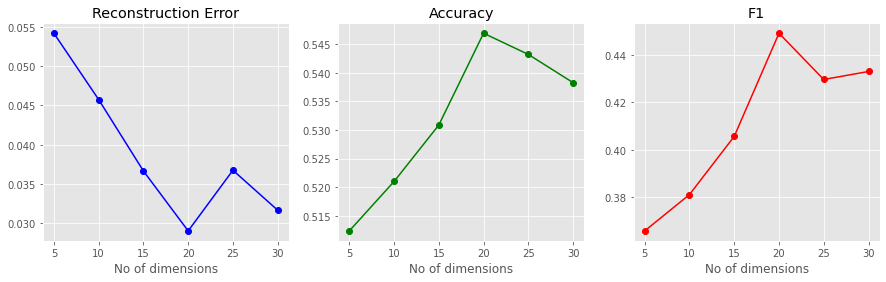

In [219]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
keys = list(metrics.keys())
for c in range(3):
    ax[c].plot(dims_list,metrics[keys[c]],marker='o',
               color= list(matplotlib.colors.BASE_COLORS.keys())[c])
    ax[c].set_title(keys[c])
    ax[c].set_xlabel('No of dimensions')

The above graphs show the reconstruction error, the accuracy and F1 score based on a simple logistic regression model. We can see that there is no real difference in reconstruction error after 10 dimensions. Based on the output we choose the n dimensions to be 20 since the model appears to overfit after 20 dimensions and use the autoencoder model to output the reduced features.

In [68]:
cont_dims = 20

In [142]:
auto_encoder_cont_final = auto_encoder_model_cont(cont_dims,epochs=10000,patience=50)

Epoch 1/10000
48/48 [==============================] - 1s 4ms/step - loss: 2.7084 - val_loss: 2.0324
Epoch 2/10000
48/48 [==============================] - 0s 1ms/step - loss: 1.7647 - val_loss: 1.3033
Epoch 3/10000
48/48 [==============================] - 0s 2ms/step - loss: 1.1728 - val_loss: 0.8246
Epoch 4/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.7906 - val_loss: 0.5239
Epoch 5/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.5474 - val_loss: 0.3480
Epoch 6/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.3931 - val_loss: 0.2412
Epoch 7/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.2958 - val_loss: 0.1748
Epoch 8/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.2330 - val_loss: 0.1332
Epoch 9/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.1934 - val_loss: 0.1075
Epoch 10/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.1677 - val_lo

Epoch 161/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0227
Epoch 162/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0239
Epoch 163/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0332
Epoch 164/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0393 - val_loss: 0.0258
Epoch 165/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0220
Epoch 166/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0423 - val_loss: 0.0209
Epoch 167/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0256
Epoch 168/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0218
Epoch 169/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.0429
Epoch 170/10000
48/48 [==============================] - 0s 1ms/step - lo

48/48 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0337
Epoch 320/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0260
Epoch 321/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0330
Epoch 322/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0211


In [69]:
#auto_encoder_cont_final.save("./Model Outputs/auto_encoder_cont_features")
auto_encoder_cont_final = keras.models.load_model("./Model Outputs/auto_encoder_cont_features")

In [70]:
reduced_cont_features = auto_encoder_cont_final.get_layer(index=0).predict(basic_technical_features_selected[cont_features_list])

53/53 [==============================] - 0s 827us/step


In [71]:
reduced_cont_features = pd.DataFrame(reduced_cont_features,columns = [f'Reduced_Cont_Feature:{i+1}' for i in range(cont_dims)],
                                    index = indicator_features.index)

basic_technical_features_reduced_cont = basic_technical_features_selected.drop(cont_features_list,axis=1)
basic_technical_features_reduced_cont = pd.concat([basic_technical_features_reduced_cont,reduced_cont_features],axis=1)

In [72]:
# Using the reduced feature set for a base line prediction
logistic_model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',random_state=12)

logistic_model.fit(basic_technical_features_reduced_cont.loc[train_start:train_end],train_Y.values)

base_prediction_3 = logistic_model.predict(basic_technical_features_reduced_cont.loc[valid_start:valid_end])

<Figure size 432x216 with 0 Axes>

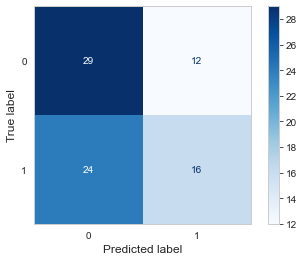

In [73]:
plt.figure(figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(valid_Y,base_prediction_3,
                                        cmap='Blues')
plt.grid()

In [74]:
print(classification_report(valid_Y,y_pred=base_prediction_3))

              precision    recall  f1-score   support

           0       0.55      0.71      0.62        41
           1       0.57      0.40      0.47        40

    accuracy                           0.56        81
   macro avg       0.56      0.55      0.54        81
weighted avg       0.56      0.56      0.54        81



The reduced features show some correlation and we tried to reduced the correlation further using PCA but it doesnot show good predictive power. Hence PCA was not used further.

#### 4.3.5 Dimensionality reduction of candlestick features

The same procedure as above is used to find a lower dimension representation for the candle stick features. But since the candle sticks are a one hot vector, we use the ```sigmoid activation``` and ```binary cross entropy```.

In [75]:
features_to_reduce = basic_technical_features_reduced_cont.loc[:,basic_technical_features_reduced_cont.columns.
                                                                  isin([*candles_features.columns])]

In [76]:
def auto_encoder_model_cdls(reduced_dim,activation_ = 'relu',epochs=300,patience=20):

    encoder = keras.models.Sequential(
        [keras.layers.InputLayer(input_shape=(features_to_reduce.shape[1])),
         keras.layers.Dropout(rate = 0.5),
         keras.layers.Dense(reduced_dim,activation = activation_, 
                            kernel_initializer='he_normal')
    ])

    decoder = keras.models.Sequential(
         [keras.layers.Dense(reduced_dim,activation=activation_,
                             kernel_initializer='he_normal',
                             input_shape=[reduced_dim],
                            ),
         keras.layers.Dense(features_to_reduce.shape[1],kernel_initializer='glorot_normal',
                            activation ='sigmoid'
                           )
    ])
    
    auto_encoder = keras.models.Sequential([encoder,decoder])
    auto_encoder.compile(optimizer= 'adam',loss= keras.losses.BinaryCrossentropy())
    

    auto_encoder.fit(x=features_to_reduce.loc[train_start:train_end].values,
                    y = features_to_reduce.loc[train_start:train_end].values,
                    epochs=epochs,shuffle=False, 
                     validation_data= (features_to_reduce.loc[valid_start:valid_end],
                                        features_to_reduce.loc[valid_start:valid_end]),
                     callbacks=[keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)])
    
    return auto_encoder

In [146]:
dims_list = [15,20,25,30,35,40,45]
X = basic_technical_features_reduced_cont.drop(features_to_reduce.columns,axis=1)
metrics = {'Reconstruction Error':[],'Accuracy':[],'F1':[]}

for dim in dims_list:
    reconstruction_error,accuracy_val,f1score = 0,0,0
    for i in range(10):
        auto_encoder = auto_encoder_model_cdls(dim,epochs=500,patience=10)
        reconstruction_error += auto_encoder.history.history['val_loss'][-1]*1/10
        encoder = auto_encoder.get_layer(index=0)
        
        reduced_features = encoder.predict(features_to_reduce)
        reduced_features = pd.DataFrame(reduced_features,columns = [f'Reduced_Feature:{i+1}' for i in range(dim)],
                                        index = indicator_features.index)
        
        X_complete = pd.concat([X,reduced_features],axis=1)
        m = base_prediction_logistic_model(X_complete,target)
        accuracy_val += m[0]*1/10
        f1score += m[1]*1/10
     
    metrics['Reconstruction Error'].append(reconstruction_error)
    metrics['Accuracy'].append(accuracy_val)
    metrics['F1'].append(f1score)

Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6630 - val_loss: 0.6222
Epoch 2/500
48/48 [==============================] - 0s 1ms/step - loss: 0.5389 - val_loss: 0.4444
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.3289 - val_loss: 0.2288
Epoch 4/500
48/48 [==============================] - 0s 1ms/step - loss: 0.1852 - val_loss: 0.1368
Epoch 5/500
48/48 [==============================] - 0s 1ms/step - loss: 0.1361 - val_loss: 0.1087
Epoch 6/500
48/48 [==============================] - 0s 1ms/step - loss: 0.1172 - val_loss: 0.0972
Epoch 7/500
48/48 [==============================] - 0s 1ms/step - loss: 0.1074 - val_loss: 0.0900
Epoch 8/500
48/48 [==============================] - 0s 1ms/step - loss: 0.1008 - val_loss: 0.0846
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0958 - val_loss: 0.0805
Epoch 10/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.0769
Epoch 11/

48/48 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0242
Epoch 84/500
48/48 [==============================] - 0s 1ms/step - loss: 0.0494 - val_loss: 0.0243
Epoch 85/500
48/48 [==============================] - 0s 1ms/step - loss: 0.0506 - val_loss: 0.0242
Epoch 86/500
48/48 [==============================] - 0s 1ms/step - loss: 0.0476 - val_loss: 0.0237
Epoch 87/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0235
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0234
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0236
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0232
Epoch 91/500
48/48 [==============================] - 0s 1ms/step - loss: 0.0485 - val_loss: 0.0229
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0225
Epoch 93/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0247
Epoch 78/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0247
Epoch 79/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0244
Epoch 80/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0243
Epoch 81/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0240
Epoch 82/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0239
Epoch 83/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0237
Epoch 84/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0237
Epoch 85/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0234
Epoch 86/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0231
Epoch 87/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0260
Epoch 72/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0256
Epoch 73/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0256
Epoch 74/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0252
Epoch 75/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0251
Epoch 76/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0252
Epoch 77/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0249
Epoch 78/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0249
Epoch 79/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0246
Epoch 80/500
48/48 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0245
Epoch 81/500


Epoch 15/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0582
Epoch 16/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0566
Epoch 17/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0549
Epoch 18/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0535
Epoch 19/500
48/48 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0525
Epoch 20/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0515
Epoch 21/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0505
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0495
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0483
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0476


Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0233
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0232
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0231
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0230
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0229
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0229
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0227
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0223
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0224
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 

48/48 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0246
Epoch 87/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0245
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0242
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0244
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0241
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0238
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0236
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0235
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0234
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0231
Epoch 96/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0397
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0391
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0385
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0377
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0371
Epoch 37/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0365
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0359
Epoch 39/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0353
Epoch 40/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0351
Epoch 41/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0344
Epoch 42/500


Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0201
Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0201
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0204
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0207
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0203
Epoch 119/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0202
Epoch 120/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0199
Epoch 121/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0199
Epoch 122/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0198
Epoch 123/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0463 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0173
Epoch 196/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0173
Epoch 197/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0171
Epoch 198/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0170
Epoch 199/500
53/53 [==============================] - 0s 692us/step
Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6797 - val_loss: 0.6510
Epoch 2/500
48/48 [==============================] - 0s 2ms/step - loss: 0.5938 - val_loss: 0.5184
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.3874 - val_loss: 0.2672
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2024 - val_loss: 0.1455
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1407 - val_loss: 0.1096
Epoch 6/500
48/48 [===========================

48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0167
Epoch 159/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0166
Epoch 160/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0171
Epoch 161/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0168
Epoch 162/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0167
Epoch 163/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0167
Epoch 164/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0171
Epoch 165/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0168
Epoch 166/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0170
Epoch 167/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0173
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0180
Epoch 152/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0179
Epoch 153/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0178
Epoch 154/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0177
Epoch 155/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0180
Epoch 156/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0180
Epoch 157/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0177
Epoch 158/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0177
Epoch 159/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0176
Epoch 160/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0181
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0185
Epoch 145/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0182
Epoch 146/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0184
Epoch 147/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0183
Epoch 148/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0183
Epoch 149/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0179
Epoch 150/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0181
Epoch 151/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0178
Epoch 152/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0178
Epoch 153/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0176
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0387
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0383
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0376
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0369
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0365
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0358
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0353
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0346
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0341
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0337
Epoch 37/500


Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0205
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0203
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0201
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0200
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0200
Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0200
Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0198
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0201
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0200
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0462 - val_los

Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0404
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0389
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0382
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0372
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0365
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0363
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0358
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0350
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0340
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0340


Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0179
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0180
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0182
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0181
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0182
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0178
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0178
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0177
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0177
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_los

Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0309
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0303
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0298
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0294
Epoch 37/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0292
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0290
Epoch 39/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0286
Epoch 40/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0284
Epoch 41/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0276
Epoch 42/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0275


Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0173
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0180
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0178
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0178
Epoch 119/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0177
Epoch 120/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0172
Epoch 121/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0174
Epoch 122/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0173
Epoch 123/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0177
Epoch 124/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0279
Epoch 45/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0275
Epoch 46/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0277
Epoch 47/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0270
Epoch 48/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0272
Epoch 49/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0272
Epoch 50/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0266
Epoch 51/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0260
Epoch 52/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0260
Epoch 53/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0259
Epoch 54/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0209
Epoch 85/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0208
Epoch 86/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0207
Epoch 87/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0208
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0202
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0204
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0202
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0199
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0198
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0198
Epoch 94/500


53/53 [==============================] - 0s 673us/step
Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6504 - val_loss: 0.5965
Epoch 2/500
48/48 [==============================] - 0s 1ms/step - loss: 0.4672 - val_loss: 0.3367
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2353 - val_loss: 0.1581
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1464 - val_loss: 0.1122
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1198 - val_loss: 0.0958
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1062 - val_loss: 0.0869
Epoch 7/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0978 - val_loss: 0.0805
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 0.0738
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0684
Epoch 10/500
48/48 [==============================] - 

48/48 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0289
Epoch 41/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0280
Epoch 42/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0279
Epoch 43/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0278
Epoch 44/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0273
Epoch 45/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0269
Epoch 46/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0270
Epoch 47/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0268
Epoch 48/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0266
Epoch 49/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0270
Epoch 50/500


Epoch 122/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0179
Epoch 123/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0182
Epoch 124/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0180
Epoch 125/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0181
Epoch 126/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0178
Epoch 127/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0178
Epoch 128/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0180
Epoch 129/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0179
Epoch 130/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0183
Epoch 131/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0158
Epoch 133/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0160
Epoch 134/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0160
Epoch 135/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0155
Epoch 136/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0156
Epoch 137/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0152
Epoch 138/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0155
Epoch 139/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0157
Epoch 140/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0156
Epoch 141/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0154
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0213
Epoch 77/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0208
Epoch 78/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0209
Epoch 79/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0205
Epoch 80/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0207
Epoch 81/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0205
Epoch 82/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0205
Epoch 83/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0202
Epoch 84/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0202
Epoch 85/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0203
Epoch 86/500


Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0190
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0189
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0189
Epoch 119/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0187
Epoch 120/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0183
Epoch 121/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0184
Epoch 122/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0184
Epoch 123/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0187
Epoch 124/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0183
Epoch 125/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0258
Epoch 46/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0258
Epoch 47/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0255
Epoch 48/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0253
Epoch 49/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0256
Epoch 50/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0252
Epoch 51/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0245
Epoch 52/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0247
Epoch 53/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0244
Epoch 54/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0241
Epoch 55/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0189
Epoch 86/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0185
Epoch 87/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0187
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0181
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0183
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0183
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0179
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0177
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0176
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0176
Epoch 95/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0510
Epoch 15/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0483
Epoch 16/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0462
Epoch 17/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0445
Epoch 18/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0429
Epoch 19/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0415
Epoch 20/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0402
Epoch 21/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0392
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0381
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0366
Epoch 24/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0176
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0177
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0175
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0176
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0176
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0174
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0174
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0171
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0169
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0170
Epoch 1

Epoch 129/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0171
Epoch 130/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0178
Epoch 131/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0171
Epoch 132/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0169
Epoch 133/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0169
Epoch 134/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0170
Epoch 135/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0167
Epoch 136/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0169
Epoch 137/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0164
Epoch 138/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0411 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0167
Epoch 140/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0163
Epoch 141/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0161
Epoch 142/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0156
Epoch 143/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0161
Epoch 144/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0165
Epoch 145/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0162
Epoch 146/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0166
Epoch 147/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0165
Epoch 148/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0164
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0144
Epoch 150/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0147
Epoch 151/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0145
Epoch 152/500
53/53 [==============================] - 0s 654us/step
Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6488 - val_loss: 0.5818
Epoch 2/500
48/48 [==============================] - 0s 1ms/step - loss: 0.4385 - val_loss: 0.2890
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2075 - val_loss: 0.1364
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1360 - val_loss: 0.1037
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1146 - val_loss: 0.0904
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1019 - val_loss: 0.0818
Epoch 7/500
48/48 [=============================

48/48 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.0783
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0710
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0661
Epoch 10/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0618
Epoch 11/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0581
Epoch 12/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0546
Epoch 13/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0514
Epoch 14/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0488
Epoch 15/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0466
Epoch 16/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0446
Epoch 17/500
48

48/48 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0189
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0187
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0184
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0184
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0182
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0181
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0179
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0181
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0182
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0179
Epoch 99/500


48/48 [==============================] - 0s 2ms/step - loss: 0.1176 - val_loss: 0.0923
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.0832
Epoch 7/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0754
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0680
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0624
Epoch 10/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0757 - val_loss: 0.0578
Epoch 11/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0542
Epoch 12/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0514
Epoch 13/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0490
Epoch 14/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0469
Epoch 15/500
48/4

48/48 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0199
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0195
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0198
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0196
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0192
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0190
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0190
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0188
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0186
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0188
Epoch 97/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0420
Epoch 17/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0404
Epoch 18/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0390
Epoch 19/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0378
Epoch 20/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0370
Epoch 21/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0356
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0348
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0336
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0329
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0322
Epoch 26/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0170
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0173
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0174
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0172
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0171
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0172
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0168
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0169
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0173
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0170
Epoch

48/48 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0135
Epoch 138/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0143
Epoch 139/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0145
Epoch 140/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0144
Epoch 141/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0139
Epoch 142/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0136
Epoch 143/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0138
Epoch 144/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0142
Epoch 145/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0141
Epoch 146/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0148
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0282
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0272
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0273
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0265
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0264
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0256
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0251
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0248
Epoch 37/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0245
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0242
Epoch 39/500


Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0150
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0147
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0145
Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0149
Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0149
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0156
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0153
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0154
Epoch 119/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0151
Epoch 120/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0405 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0307
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0304
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0297
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0285
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0285
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0272
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0270
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0260
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0258
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0252
Epoch 37/500


Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0164
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0164
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0163
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0161
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0160
Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0163
Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0163
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0169
Epoch 117/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0169
Epoch 118/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0313
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0308
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0304
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0300
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0294
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0285
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0287
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0278
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0277
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0265
Epoch 35/500


Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0153
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0154
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0152
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0154
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0151
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0150
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0148
Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0152
Epoch 115/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0151
Epoch 116/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_los

48/48 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0337
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0327
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0320
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0312
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0306
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0302
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0297
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0286
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0286
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0275
Epoch 33/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0162
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0165
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0160
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0166
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0160
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0161
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0161
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0162
Epoch 113/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0156
Epoch 114/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0162
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0312
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0305
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0293
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0289
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0282
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0278
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0273
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0271
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0267
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0257
Epoch 31/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0159
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0155
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0159
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0163
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0157
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0162
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0158
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0161
Epoch 111/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0159
Epoch 112/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0157
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0349
Epoch 20/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0344
Epoch 21/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0331
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0323
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0313
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0308
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0301
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0296
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0291
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0289
Epoch 29/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0154
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0155
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0153
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0149
Epoch 105/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0150
Epoch 106/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0154
Epoch 107/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0152
Epoch 108/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0153
Epoch 109/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0150
Epoch 110/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0149
Epoc

48/48 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0246
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0248
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0242
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0239
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0233
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0233
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0229
Epoch 37/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0226
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0225
Epoch 39/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0220
Epoch 40/500


48/48 [==============================] - 0s 2ms/step - loss: 0.1605 - val_loss: 0.1103
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1201 - val_loss: 0.0929
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1036 - val_loss: 0.0818
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0918 - val_loss: 0.0742
Epoch 7/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0676
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0608
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0560
Epoch 10/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0518
Epoch 11/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0484
Epoch 12/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0456
Epoch 13/500
48/48 

48/48 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0161
Epoch 86/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0158
Epoch 87/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0163
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0154
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0159
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0153
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0151
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0152
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0151
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0151
Epoch 95/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0219
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0217
Epoch 39/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0213
Epoch 40/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0211
Epoch 41/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0201
Epoch 42/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0204
Epoch 43/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0205
Epoch 44/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0199
Epoch 45/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0196
Epoch 46/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0197
Epoch 47/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0151
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0154
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0155
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0153
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0157
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0155
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0152
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0154
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0153
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0150
Epoch 10

48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0260
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0247
Epoch 31/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0252
Epoch 32/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0242
Epoch 33/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0242
Epoch 34/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0233
Epoch 35/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0231
Epoch 36/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0229
Epoch 37/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0225
Epoch 38/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0222
Epoch 39/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0161
Epoch 88/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0155
Epoch 89/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0159
Epoch 90/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0156
Epoch 91/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0151
Epoch 92/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0153
Epoch 93/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0153
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0155
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0150
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0151
Epoch 97/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0300
Epoch 22/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0293
Epoch 23/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0282
Epoch 24/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0277
Epoch 25/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0270
Epoch 26/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0265
Epoch 27/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0260
Epoch 28/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0257
Epoch 29/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0254
Epoch 30/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0241
Epoch 31/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0143
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0141
Epoch 105/500
53/53 [==============================] - 0s 635us/step
Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6163 - val_loss: 0.4959
Epoch 2/500
48/48 [==============================] - 0s 1ms/step - loss: 0.3101 - val_loss: 0.1713
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1512 - val_loss: 0.1133
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1194 - val_loss: 0.0960
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1040 - val_loss: 0.0848
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.0769
Epoch 7/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0702
Epoch 8/500
48/48 [==============================]

48/48 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0204
Epoch 56/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0200
Epoch 57/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0198
Epoch 58/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0193
Epoch 59/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0196
Epoch 60/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0192
Epoch 61/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0183
Epoch 62/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0193
Epoch 63/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0191
Epoch 64/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0186
Epoch 65/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0901 - val_loss: 0.0751
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0671
Epoch 9/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0603
Epoch 10/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0545
Epoch 11/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0499
Epoch 12/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0467
Epoch 13/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0438
Epoch 14/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0420
Epoch 15/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0398
Epoch 16/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0381
Epoch 17/500
48

48/48 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0162
Epoch 90/500
48/48 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0159
Epoch 91/500
48/48 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0154
Epoch 92/500
48/48 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0156
Epoch 93/500
48/48 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0156
Epoch 94/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0157
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0151
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0153
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0155
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0152
Epoch 99/500


Epoch 122/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0150
Epoch 123/500
53/53 [==============================] - 0s 616us/step
Epoch 1/500
48/48 [==============================] - 1s 3ms/step - loss: 0.6099 - val_loss: 0.4825
Epoch 2/500
48/48 [==============================] - 0s 2ms/step - loss: 0.2871 - val_loss: 0.1488
Epoch 3/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1403 - val_loss: 0.1042
Epoch 4/500
48/48 [==============================] - 0s 2ms/step - loss: 0.1125 - val_loss: 0.0904
Epoch 5/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0984 - val_loss: 0.0807
Epoch 6/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0876 - val_loss: 0.0733
Epoch 7/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0660
Epoch 8/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0595
Epoch 9/500
48/48 [===================

48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0168
Epoch 57/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0168
Epoch 58/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0162
Epoch 59/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0167
Epoch 60/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0163
Epoch 61/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0154
Epoch 62/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0163
Epoch 63/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0162
Epoch 64/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0157
Epoch 65/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0150
Epoch 66/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0134
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0138
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0135
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0140
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0141
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0137
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0136
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0136
Epoch 104/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0134
Epoch 105/500
53/53 [==============================] - 0s 654us/step
Epoch 1/500
48/48 [====================

48/48 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0166
Epoch 67/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0158
Epoch 68/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0159
Epoch 69/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0162
Epoch 70/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0163
Epoch 71/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0157
Epoch 72/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0157
Epoch 73/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0161
Epoch 74/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0155
Epoch 75/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0157
Epoch 76/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0186
Epoch 46/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0192
Epoch 47/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0191
Epoch 48/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0189
Epoch 49/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0190
Epoch 50/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0189
Epoch 51/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0179
Epoch 52/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0188
Epoch 53/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0182
Epoch 54/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0180
Epoch 55/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0416
Epoch 13/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0397
Epoch 14/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0380
Epoch 15/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0355
Epoch 16/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0340
Epoch 17/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0330
Epoch 18/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0316
Epoch 19/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0305
Epoch 20/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0301
Epoch 21/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0287
Epoch 22/500


48/48 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0150
Epoch 95/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0142
Epoch 96/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0145
Epoch 97/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0148
Epoch 98/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0148
Epoch 99/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0150
Epoch 100/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0152
Epoch 101/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0146
Epoch 102/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0148
Epoch 103/500
48/48 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0147
Epoch 104

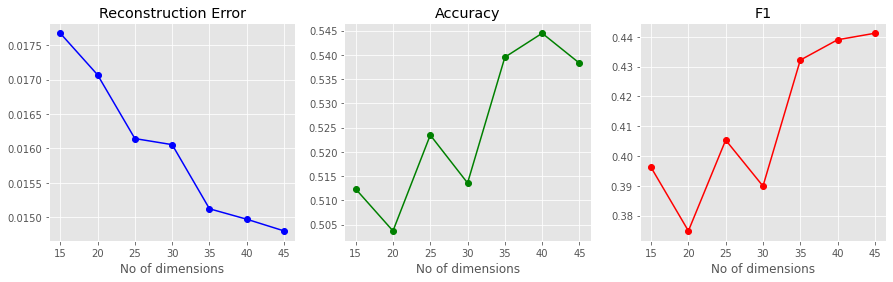

In [147]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
keys = list(metrics.keys())
for c in range(3):
    ax[c].plot(dims_list,metrics[keys[c]],marker='o',
               color= list(matplotlib.colors.BASE_COLORS.keys())[c])
    ax[c].set_title(keys[c])
    ax[c].set_xlabel('No of dimensions')

We choose 40 as the optimum number of dimensions.

In [77]:
cdl_dims = 40

In [150]:
auto_encoder_cdl_final = auto_encoder_model_cdls(cdl_dims,epochs=10000,patience=50)

Epoch 1/10000
48/48 [==============================] - 1s 3ms/step - loss: 0.6049 - val_loss: 0.4756
Epoch 2/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.2947 - val_loss: 0.1569
Epoch 3/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.1468 - val_loss: 0.1055
Epoch 4/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.1156 - val_loss: 0.0894
Epoch 5/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.1013 - val_loss: 0.0790
Epoch 6/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0906 - val_loss: 0.0713
Epoch 7/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0651
Epoch 8/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0591
Epoch 9/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0546
Epoch 10/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0696 - val_lo

Epoch 161/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0133
Epoch 162/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0129
Epoch 163/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0130
Epoch 164/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0131
Epoch 165/10000
48/48 [==============================] - 0s 1ms/step - loss: 0.0415 - val_loss: 0.0128
Epoch 166/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0132
Epoch 167/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0144
Epoch 168/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0136
Epoch 169/10000
48/48 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0137
Epoch 170/10000
48/48 [==============================] - 0s 2ms/step - lo

In [78]:
#auto_encoder_cdl_final.save("./Model Outputs/auto_encoder_cdl_features")
auto_encoder_cdl_final = keras.models.load_model("./Model Outputs/auto_encoder_cdl_features")

In [79]:
reduced_cdl_features = auto_encoder_cdl_final.get_layer(index=0).predict(basic_technical_features_reduced_cont[[*features_to_reduce.columns]])

53/53 [==============================] - 0s 808us/step


In [80]:
reduced_cdl_features = pd.DataFrame(reduced_cdl_features,columns = [f'Reduced_cdl_Feature:{i+1}' for i in range(cdl_dims)],
                                    index = indicator_features.index)

basic_technical_features_reduced_all = basic_technical_features_selected.drop([*cont_features_list,*features_to_reduce.columns],axis=1)
basic_technical_features_reduced_all = pd.concat([basic_technical_features_reduced_all,reduced_cdl_features,reduced_cont_features],axis=1)

In [81]:
basic_technical_features_reduced_all.shape

(1669, 87)

In [82]:
# Using the reduced feature set for a base line prediction
logistic_model = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',random_state=12,C=1)

logistic_model.fit(basic_technical_features_reduced_all.loc[train_start:train_end],train_Y.values)

base_prediction_4 = logistic_model.predict(basic_technical_features_reduced_all.loc[valid_start:valid_end])

<Figure size 432x216 with 0 Axes>

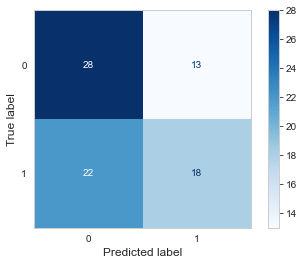

In [83]:
plt.figure(figsize=(6,3))
ConfusionMatrixDisplay.from_predictions(valid_Y,base_prediction_4,
                                        cmap='Blues')
plt.grid()

In [84]:
print(classification_report(valid_Y,y_pred=base_prediction_4))

              precision    recall  f1-score   support

           0       0.56      0.68      0.62        41
           1       0.58      0.45      0.51        40

    accuracy                           0.57        81
   macro avg       0.57      0.57      0.56        81
weighted avg       0.57      0.57      0.56        81



#### 4.3.6 Summary of  Basic and Technical Features Extraction

In [85]:
def summary_scores(y_test, predictions):
    accuracy  = []
    precision  = [] 
    recall  = []
    f1 = []
    
    for i,pred in enumerate(predictions):
        accuracy.append(np.round(accuracy_score(y_test,pred),3))
        precision.append(np.round(precision_score(y_test,pred),3))
        recall.append(np.round(recall_score(y_test,pred),3))
        f1.append(np.round(f1_score(y_test,pred),3))
        
    return accuracy,precision,recall,f1

In [86]:
accuracy,precision,recall,f1 = summary_scores(valid_Y,[base_prediction_1,base_prediction_2,
                                                   base_prediction_3,base_prediction_4])

In [87]:
print(tabulate([['Base Model',basic_technical_features.shape[1],accuracy[0],precision[0],recall[0],f1[0]],
        ['Cross Validation',basic_technical_features_selected.shape[1],accuracy[1],precision[1],recall[1],f1[1]],
          ['Dim. Reduction of Cont. Features',basic_technical_features_reduced_cont.shape[1],accuracy[2],precision[2],recall[2],f1[2]],
          ['Dim. Reduction of Candlestick. Features',basic_technical_features_reduced_all.shape[1],accuracy[3],precision[3],recall[3],f1[3]],
         ],headers = ['Feature Engineering Step','No. of Features','Accuracy','Precision','Recall','F1 Score']))

Feature Engineering Step                   No. of Features    Accuracy    Precision    Recall    F1 Score
---------------------------------------  -----------------  ----------  -----------  --------  ----------
Base Model                                             147       0.519        0.516     0.4         0.451
Cross Validation                                       146       0.481        0.469     0.375       0.417
Dim. Reduction of Cont. Features                       115       0.556        0.571     0.4         0.471
Dim. Reduction of Candlestick. Features                 87       0.568        0.581     0.45        0.507


### 4.4 Open Interest Features

In [88]:
oi_info = option_hist.pivot_table(values='OPEN_INT',aggfunc=sum,columns='OPTION_TYPE',index='TIMESTAMP')

In [89]:
# Put Call Ratio
put_call_ratio = oi_info['PE']/oi_info['CE']
put_call_ratio.index = pd.to_datetime(put_call_ratio.index)
put_call_ratio.name = 'put_call_ratio'

# Call and Put OI % Change
oi_pct_change = oi_info.pct_change().fillna(0)
oi_pct_change.columns =['call_oi_pct_change','put_oi_pct_change']
oi_pct_change.index = pd.to_datetime(oi_pct_change.index)

#OI Features
oi_features = pd.concat([put_call_ratio,oi_pct_change],axis=1)

### 4.5 Macroeconomic Features

#### 4.5.1 Commodity Returns

In [90]:
# Commodity Returns
commodity_returns = commodity_prices.pct_change().fillna(0)
commodity_returns.columns = [f'{col}_returns' for col in commodity_returns.columns]

#### 4.5.2 Index Returns

In [91]:
# Index Returns
index_returns =index_prices[['nifty_50','nifty_midcap']].pct_change().fillna(0)
index_returns.columns = [f'{col}_returns' for col in index_returns.columns]

#### 4.5.3 VIX Data

In [92]:
# VIX Levels
vix_data.columns = ['vix_level']

#### 4.5.4 Interest Rate Changes

In [93]:
# Interest Rate Changes
interest_rate_change = pd.merge(pd.Series(stock_data.index),interest_rate_data['Actual'].diff(),
                         left_on='Date',right_index=True,how='left').fillna(0).set_index('Date')

interest_rate_change.columns = ['interest_rate_change']


In [94]:
macro_economic_features = pd.concat([commodity_returns,index_returns,vix_data,interest_rate_change],axis=1).fillna(0)

### 4.6 Fundamental Features

#### 4.6.1 Ex Dividend Date

In [95]:
# Ex dividend Date
ex_dividend_date = pd.merge(pd.Series(stock_data.index),ex_dividend_info["Ex Date"],
         left_on='Date',right_on='Ex Date',how='outer').fillna(0).set_index('Date')

ex_dividend_date['Ex Date'] = np.where(ex_dividend_date['Ex Date'] !=0,1,0)

ex_dividend_date.columns  = ['ex_div_date']

#### 4.6.2 Earnings Surprise

In [96]:
# Earnings
earnings_surprise = pd.merge(pd.Series(stock_data.index),earnings_data[['Release Date','EPS Surprise']],
                             left_on='Date',right_on='Release Date',how='left').fillna(0).set_index('Date')
earnings_surprise['Release Date'] = np.where(earnings_surprise['Release Date']!=0,1,0)
earnings_surprise.columns = ['earnings_release_date','eps_surprise']

#### 4.6.3 Sector Performance

In [97]:
# Sector Performance
sector_returns = sector_portfolio.pct_change().fillna(0)
sector_returns.columns = ['sector_returns']

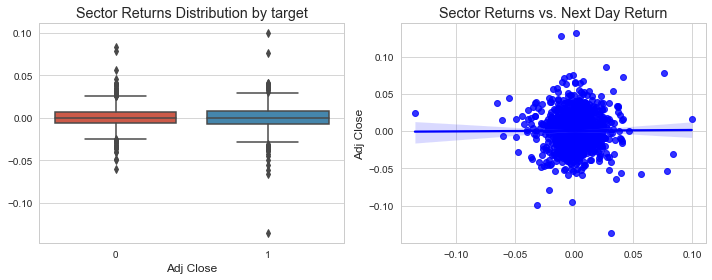

In [98]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.boxplot(x = train_Y,y = sector_returns.loc[train_start:train_end].values.ravel(),ax = ax[0])
sns.regplot(x = sector_returns.loc[train_start:train_end].values.ravel(),
            y=returns.shift(-1).fillna(0).loc[train_start:train_end],ax=ax[1],color='b')
ax[0].set_title('Sector Returns Distribution by target')
ax[1].set_title('Sector Returns vs. Next Day Return')
plt.tight_layout()

#### 4.6.4 Large vs. Small Cap Performance

In [99]:
# Large Cap vs. Small Cap Performance
index_cap_performance = index_prices[['bse_lc','bse_mc','bse_sc']].pct_change().fillna(0)
lc_minus_mc  = index_cap_performance['bse_lc']-index_cap_performance['bse_mc']
mc_minus_sc = index_cap_performance['bse_mc']-index_cap_performance['bse_sc']

index_cap_performance = pd.concat([lc_minus_mc,mc_minus_sc],axis=1)
index_cap_performance.columns = ['lc_minus_mc','mc_minus_sc']

In [100]:
fundamental_features = pd.concat([ex_dividend_date,earnings_surprise,
                                  sector_returns,index_cap_performance],axis=1)

### 4.7 Sentiment Features

#### 4.7.1 Sentiment Analysis of News articles using ChatGPT

From the news articles stored in ```news_df```, we perform sentiment analysis using ```ChatGPT```. We get two features from ```ChatGPT```. One is the major sentiment for the day and the second the strength of the sentiment. The major sentiment is either ```positive```, ```negative``` or ```neutral``` and the strength denotes on average how positive the news items are for that day on a scale of -5 to 5.

Below code implements a function to use ```ChatGPT``` for sentiment analysis.

In [101]:
import openai

with open("ChatGPT API keys.txt") as gpt_keys:
    openai.api_key = gpt_keys.readline()

In [102]:
def chatgpt_sentiment_analysis(news_item):
    prompt = 'Respond with one word only. Is the following statement positive, negative or neutral for TVS Motors stock price?'

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt + news_item}]

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages= messages,request_timeout=30,temperature =0.2)

    message_1 = response['choices'][0]['message']
    sentiment = message_1.content

    messages.append(message_1)
    messages.append(
        {'role':'user','content':'Respond in one number between 0 to 10. How positive is the previous statement?'})

    #time.sleep(1.5)
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages= messages,request_timeout=30,temperature =0.2)

    message_2 = response['choices'][0]['message']
    strength = message_2.content
    #time.sleep(1.5)
    return sentiment, strength

Below code implements a loop to get the sentiment features from all the news items for the entire period.

In [103]:
'''
news_weight_decay = 0.5
sentiment_list = []
strength_list = []
start_date  = train_start
end_date = test_end

for i,date  in enumerate(news_df.loc[start_date:end_date].index):
    news_items = news_df['News_items'].iloc[i]
    num = len(news_items)
    if num >0: 
        initial_weight = news_weight_decay/(1-(1-news_weight_decay)**num)

        news_sentiment = None
        while news_sentiment is None:
            try:
                news_sentiment = [chatgpt_sentiment_analysis(news_item) for news_item in news_items]
            except:
                print('Retrying...')
                time.sleep(10)
                continue
                
    else:
        news_sentiment = [('Neutral',5)]

    sentiment_first = news_sentiment[0][0]
    strength_avg = np.sum([float(sentiment[1])*initial_weight*(1-news_weight_decay)**n 
                           for n,sentiment in enumerate(news_sentiment)])

    sentiment_list.append(sentiment_first)
    strength_list.append(strength_avg)

    print(f'Request completed for {date.date()}')

    if i%100 ==0:
        sentiment_analysis_output = pd.DataFrame(data={'Date':news_df.loc[start_date:date].index,
                                                       'Sentiment':sentiment_list,
                                                           'Strength':strength_list})

        sentiment_analysis_output.to_csv('ChatGPT_sentiment_analysis_output.csv')
        

sentiment_analysis_output = pd.DataFrame(data={'Date':news_df.loc[start_date:date].index,
                                                       'Sentiment':sentiment_list,
                                                           'Strength':strength_list})

sentiment_analysis_output.to_csv('ChatGPT_sentiment_analysis_output.csv')
'''

sentiment_analysis_output = pd.read_csv('./Data Extracts/ChatGPT_sentiment_analysis_output.csv').iloc[:,1:].set_index('Date')
sentiment_analysis_output.index = pd.to_datetime(sentiment_analysis_output.index)
sentiment_analysis_output['Sentiment'] = sentiment_analysis_output['Sentiment'].str.lower().str.replace('.','')
sentiment_analysis_output['Strength'] = sentiment_analysis_output['Strength']-5

Below plot shows the distribution of sentiment strength by sentiment type. We can clearly see the differences in the distribution which is expected. There are some outliers in each type which overlap between each type.

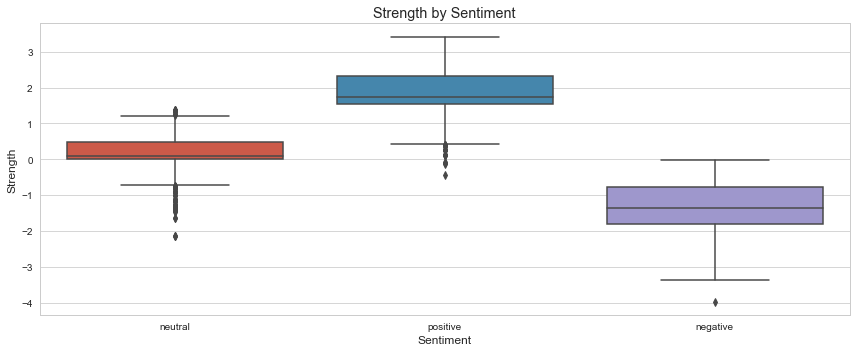

In [104]:
plt.figure(figsize=(12,5))
sns.boxplot(x= 'Sentiment',y='Strength',data=sentiment_analysis_output)
plt.title('Strength by Sentiment')
plt.tight_layout()

We consider exponential moving average of the news strength indicator as a feature. The major sentiment is coded as +1, 0 or -1

In [105]:
sentiment_analysis_output["Sentiment_coded"] = np.where(sentiment_analysis_output["Sentiment"]=='positive',1,
                                                 np.where(sentiment_analysis_output["Sentiment"]=='negative',-1,0))

sentiment_analysis_output['Strength_ema'] = sentiment_analysis_output['Strength'].ewm(com=10).mean()

In [106]:
sentiment_features = sentiment_analysis_output[['Sentiment_coded','Strength','Strength_ema']]
sentiment_features.columns = ['news_sentiment','news_strength','news_strength_ema']

#### 4.7.2 Google Search volume

The ```Google``` search volume data is an indicator of the interest (both positive and negative) in the company. This combined with the news sentiment should provide information regarding the strength of the sentiment. We also ```EMA``` of the search volumes as features

In [107]:
gsv_features = pd.DataFrame(data= {f'google_search_ema_{i}':gsv_daily['daily_search_values_recon'].ewm(i).mean() 
                                   for i in [0,14,100]})

sentiment_features = sentiment_features.merge(gsv_features,how='outer',left_index=True,right_index=True)

### 4.8 Features Based on time series Models

The model considered for performing time series modelling is ```Markov Switching Autoregressive``` (MSA) Models. The package ```Statsmodels``` is used for performing the modelling.

In [108]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression as msa
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression as ms
from statsmodels.tools.sm_exceptions import ConvergenceWarning
filterwarnings("ignore",category=ConvergenceWarning)
from scipy.stats import norm

<Axes: title={'center': 'Log Returns'}, xlabel='Date'>

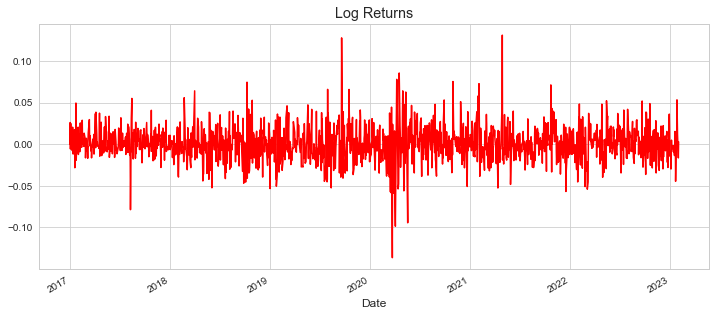

In [109]:
# Log Returns
log_returns = np.log(stock_data['Adj Close']).diff().fillna(0)
log_returns.loc[train_start:train_end].plot(color='r',figsize=(12,5),title='Log Returns')

The model has two hyperparameters - ```no. of regimes``` and ```order of lag```. We implement a cross validation approach to test different models and choose the best model based on the AIC/BIC criteria.

In [110]:
def msa_model(n_regimes,lag):
    if lag == 0:
        model = ms(log_returns.loc[train_start:train_end].values,k_regimes=n_regimes,
                   switching_variance=True,switching_trend=True)
    else:
        model = msa(log_returns.loc[train_start:train_end].values,k_regimes=n_regimes,order=lag,switching_ar=True,
                    switching_trend=True,switching_variance=True)
    model_output = model.fit()
    return model_output

def msa_model_cv(params):
    i = 0
    output = {'n_regimes':[],'lags':[],'AIC':[],'BIC':[]}
    for n_regimes in params['n_regimes']:
        for lag in params['lag']:
            model_output = msa_model(n_regimes,lag)
            output['n_regimes'].append(n_regimes)
            output['lags'].append(lag)
            output['AIC'].append(model_output.aic)
            output['BIC'].append(model_output.bic)
            print(f'Model_{i}:',end=' ')
            print(f'n_regimes = {n_regimes}',end=', ')
            print(f'Lag = {lag}',end=', ')
            print(f'AIC = {model_output.aic:.2f}',end=', ')
            print(f'BIC = {model_output.bic:.2f}')
            i += 1
    return pd.DataFrame(output)

In [704]:
params = {'n_regimes':[2,3,4],'lag':[0,1,2]}
msa_model_outputs = msa_model_cv(params)

Model_0: n_regimes = 2, Lag = 0, AIC = -7561.25, BIC = -7529.35
Model_1: n_regimes = 2, Lag = 1, AIC = -7551.00, BIC = -7508.47
Model_2: n_regimes = 2, Lag = 2, AIC = -7544.18, BIC = -7491.03
Model_3: n_regimes = 3, Lag = 0, AIC = -7590.78, BIC = -7526.98
Model_4: n_regimes = 3, Lag = 1, AIC = -7591.60, BIC = -7511.86
Model_5: n_regimes = 3, Lag = 2, AIC = -7572.21, BIC = -7476.54
Model_6: n_regimes = 4, Lag = 0, AIC = -7575.82, BIC = -7469.49
Model_7: n_regimes = 4, Lag = 1, AIC = -7575.43, BIC = -7447.85
Model_8: n_regimes = 4, Lag = 2, AIC = -7556.31, BIC = -7407.48


Based on the outputs given above, we see that the best model according to AIC is ```Model_4``` and the best model according to BIC is ```Model_0```. For further analysis we choose ```Model_4``` as the best model.

In [111]:
msa_best_model = msa_model(n_regimes=3,lag=1)

In [112]:
print(msa_best_model.summary())

                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                 1504
Model:             MarkovAutoregression   Log Likelihood                3810.801
Date:                  Wed, 22 Nov 2023   AIC                          -7591.603
Time:                          12:00:45   BIC                          -7511.865
Sample:                               0   HQIC                         -7561.901
                                 - 1504                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.001     -3.675      0.000      -0.005      -0.001
sigma2      4.105e-05    1.1e-05    

The ```MSA``` model gives the marginal probabilities for each state at any given point in time. We can also get the long term mean and variance of each of the states and the transition probabilites of one state to another.

In [113]:
transition_matrix = msa_best_model.regime_transition[:,:,0].T
init_probs = msa_best_model.initial_probabilities

In [114]:
np.round(transition_matrix,3)

array([[0.381, 0.561, 0.058],
       [0.186, 0.814, 0.   ],
       [0.   , 0.101, 0.899]])

In [115]:
intercepts = msa_best_model.params[6:9]
var = msa_best_model.params[9:12]
ar_coefs = msa_best_model.params[12:] 

The long term mean and variance for a regime are given by the formula below: $\mu = \frac{\phi_0}{1-\phi_1}$, $\sigma^2 = \frac{\sigma^2_a}{1-\phi_1^2}$ where $\phi_0$ is the intercept, $\phi_1$ is the AR coeficient and $\sigma^2_a$ is the variance of the residuals.

In [116]:
lt_mean = intercepts/(1-ar_coefs)
lt_var = var/(1-ar_coefs**2)

print(f'Means:{np.round(lt_mean*252,4)}')
print(f'stdev:{np.round((lt_var*252)**0.5,4)}')

Means:[-0.6251  0.5387 -0.0248]
stdev:[0.1058 0.2993 0.6294]


The annualized mean and the standard deviation of returns of three regimes are given above. The first regime shows the declining market condition where returns are negative and relatively predictable. The second regime shows the high risk and high return state of the market meaning that the markets are normal and returns are related to the risk premium. The third regime shows periods of high volatility where returns are zero implying that market participants are indecisive.

The ```filtered_marginal_probability``` estimates give the probability of the state in each time period based on historical data. The state with the highest probability is assigned to that observation

In [117]:
probabilties= msa_best_model.filtered_marginal_probabilities
regimes = probabilties.argmax(axis=1)
probabilties = pd.DataFrame(probabilties,index=log_returns.iloc[1:].loc[:train_end].index)
probabilties.index = pd.to_datetime(probabilties.index)
regimes = pd.Series(regimes,index = log_returns.iloc[1:].loc[:train_end].index)
regimes.value_counts()

1    1242
0     137
2     125
Name: count, dtype: int64

As expected, the majority of the observations are assigned to state 1 which is the normal market condition. Below plot indicates the different regimes in the training data. The ```Regime 2``` seems to be more prominent during support or resistance levels which represent that market players are indecisive. The ```Regime 2``` seems to be more correlated which proves the existence of volatility clustering. It also seems to appear more in sharp downturns. The ```Regime 0``` seems to occur in downturns which are not sharp.

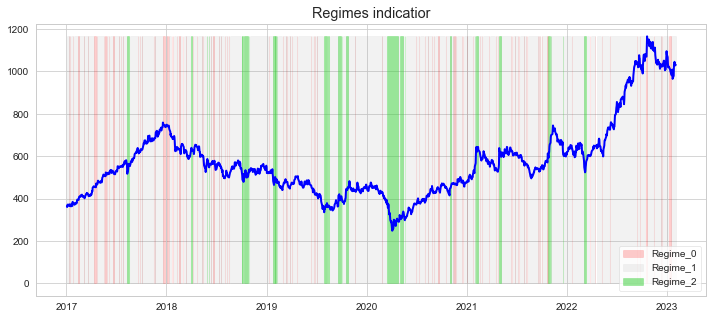

In [118]:
plt.figure(figsize=(12,5))
y = stock_data['Adj Close'].iloc[1:].loc[:train_end]
plt.plot(y,color='blue',lw=2)
plt.fill_between(x= y.index,y1=0,y2=max(y),where=(regimes==0),color= 'red',alpha=0.2,label = 'Regime_0')
plt.fill_between(x= y.index,y1=0,y2=max(y),where=(regimes==1),color='gray',alpha=0.1,label = 'Regime_1')
plt.fill_between(x= y.index,y1=0,y2=max(y),where=(regimes==2),color='limegreen',alpha=0.5,label = 'Regime_2')
plt.title('Regimes indicatior')
plt.legend(loc=4)

The expected duration of each regime is also given by the model.

In [119]:
msa_best_model.expected_durations

array([1.61510627, 5.37344843, 9.85500404])

It indicates that the ```regime 2``` persists longer than ```regime 1``` which is the most common regime and ```regime 0``` is short lived.

For the NN prediction model, we use the predicted probability of the regime at the next step conditional on the information until the current time step as a feature. Since ```Statsmodels``` does not have the capability for doing this for out of sample observations, we create our own function that calculates the predicted probability at each time step.

The idea is use to use the current probability conditional on information till time $t$ $P(S_t|y_t=i)$ and the transition matrix which gives $P(S_{t+1}=j|S_t=s)$ to compute $P(S_{t+1}|y_t=i)$ which is the probability of the next regime given information till $t$.

In [120]:
def posterior_prob_regime(cur_value,prev_value, prior_prob):
    
    conditional_mean = intercepts + ar_coefs*prev_val
    conditional_std = var**0.5
    likelihood_val = norm.pdf(cur_value,loc=conditional_mean,scale=conditional_std)
    joint_prob = likelihood_val*prior_prob
    posterior_prob = joint_prob/np.sum(joint_prob)
    
    return posterior_prob

predicted_probs = [init_probs]
current_probs = []

for i in range(1,log_returns.shape[0]):
    prior_prob = predicted_probs[-1]
    prev_val = log_returns.iloc[i-1]
    cur_val = log_returns.iloc[i]
    current_probs.append(posterior_prob_regime(cur_val,prev_val,prior_prob))
    predicted_probs.append(np.matmul(current_probs[-1],transition_matrix))

The ```predicted_probs``` variable shows the probability of a state in the next time step given information till current time. This is used as a feature in the NN model.

In [121]:
tsa_features = pd.DataFrame(predicted_probs,index = log_returns.index,
                            columns=['prob_regime_0','prob_regime_1','prob_regime_2'])

In [122]:
pd.Series(np.argmax(tsa_features,axis=1),index=tsa_features.index).value_counts()

1    1550
2     119
Name: count, dtype: int64

The table above shows the most probable regime in the next step given information till today. This shows that the probability of ```Regime_0``` is lower than the other regimes always.

Text(0.5, 1.0, 'Probability of regime in the next time step')

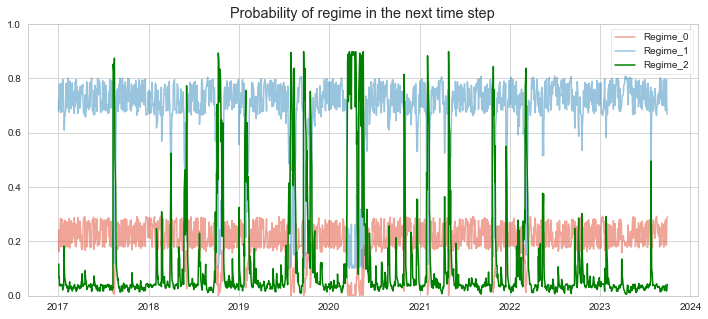

In [123]:
plt.figure(figsize=(12,5))
plt.plot(tsa_features['prob_regime_0'],label='Regime_0',alpha=0.5)
plt.plot(tsa_features['prob_regime_1'],label='Regime_1',alpha=0.5)
plt.plot(tsa_features['prob_regime_2'],label='Regime_2',color='green')
plt.ylim(0,1)
plt.legend()
plt.title('Probability of regime in the next time step')

The above graph shows the different regime probability at each point in time. It can be seen that the regime 0 probability is constant around 20-30% and regime 1 probability is 70-80% most of the times. However regime 2 is either highly probable or not probable at all making it very predictable given current information.

### 4.9 Complete Feature Set

All the features extracted so far are combined together and used in the used in the model building process in the next section. Train test split is also done in this section.

In [124]:
features = pd.concat([basic_technical_features_reduced_all,macro_economic_features,fundamental_features,
                     sentiment_features,tsa_features],axis=1,join='inner').fillna(0).astype('float32')

features = features.merge(oi_features,how='left',left_index=True,right_index=True).fillna(method='ffill')

In [125]:
train_features = features.loc[train_start:train_end]
valid_features = features.loc[valid_start:valid_end]
test_features = features.loc[test_start:test_end]

Text(0.5, 1.0, 'Correlation matrix of features')

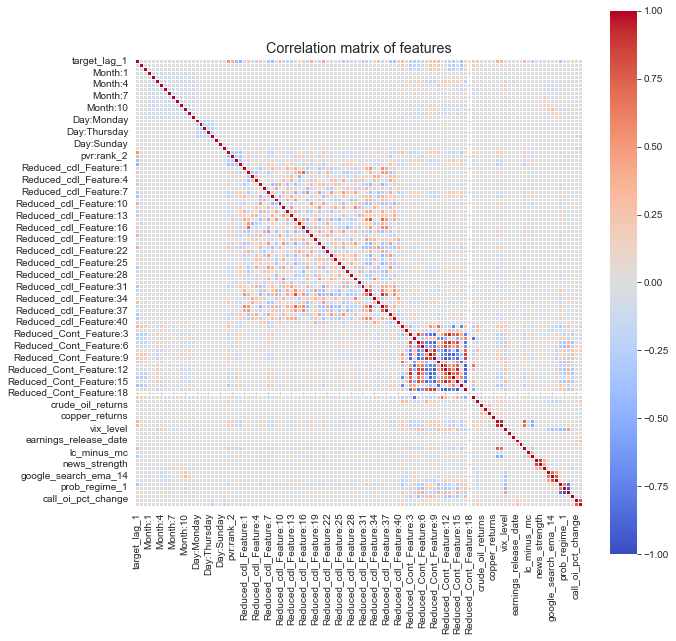

In [126]:
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(np.corrcoef(train_features.astype(float),rowvar=False),
             index = train_features.columns,columns=train_features.columns),
            vmin=-1,vmax=1,square=True,cmap='coolwarm',lw=1,linecolor='w')
plt.title('Correlation matrix of features')

From the correlation matrix we can see that most of the correlation is between the encoded technical features. PCA is not very effective in reducing correlation further.

## 5. Model Building

### 5.1 Preliminary Models and Prediction Estimates

In [127]:
def model_results_display(model,hyperparams):
    
    model.fit(X=train_features,y=train_Y)
    model_cv = GridSearchCV(model,params_grid,
                              cv=TimeSeriesSplit(test_size=80),
                              scoring=make_scorer(f1_score))
    
    model_cv.fit(X=train_features,y=train_Y)
    b_model = model_cv.best_estimator_
    print('Best Parameters:',model_cv.best_params_)
    print('------------------------')
    
    b_model.fit(X=train_features,y=train_Y)
    preds = b_model.predict(valid_features)
    
    print('Classification Report:')
    print('')
    print(classification_report(valid_Y,preds))
    print('-------------------------')
    
    print('Confusion Matrix')
    print('')
    ConfusionMatrixDisplay.from_predictions(valid_Y,preds,cmap='Blues')
    plt.grid()
    return preds,b_model

#### 5.1.1 Logistic Regression Model (L2 Penalty)

Best Parameters: {'C': 0.1}
------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.93      0.68        41
           1       0.73      0.20      0.31        40

    accuracy                           0.57        81
   macro avg       0.64      0.56      0.50        81
weighted avg       0.63      0.57      0.50        81

-------------------------
Confusion Matrix



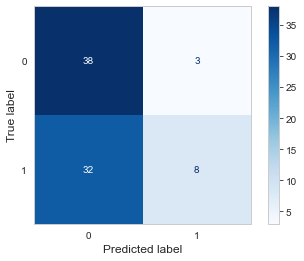

In [128]:
model_1 = LogisticRegression(class_weight='balanced',random_state=12,tol=1e-3)
params_grid = {'C':[0.1,1,10,100,1000]}
prelim_pred_model_1,prelim_model_1 = model_results_display(model_1,params_grid)

#### 5.1.2 Logistic Regression Model (L1 Penalty)

Best Parameters: {'C': 1000}
------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.78      0.63        41
           1       0.55      0.28      0.37        40

    accuracy                           0.53        81
   macro avg       0.54      0.53      0.50        81
weighted avg       0.54      0.53      0.50        81

-------------------------
Confusion Matrix



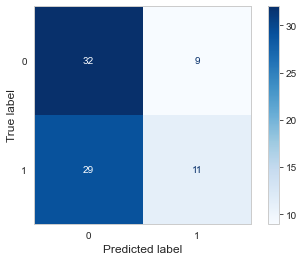

In [129]:
model_2 = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',tol=1e-3,random_state=12)
params_grid = {'C':[0.1,1,10,100,1000]}
prelim_pred_model_2,prelim_model_2 = model_results_display(model_2,params_grid)

#### 5.1.3 Random Forest Classifier

Best Parameters: {'max_depth': 3}
------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.93      0.66        41
           1       0.57      0.10      0.17        40

    accuracy                           0.52        81
   macro avg       0.54      0.51      0.42        81
weighted avg       0.54      0.52      0.42        81

-------------------------
Confusion Matrix



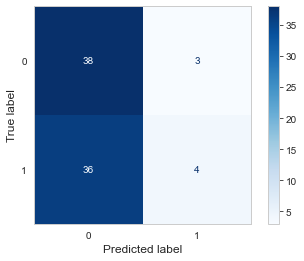

In [130]:
model_3 = RandomForestClassifier(class_weight='balanced',oob_score=True,max_depth=5,random_state=12)
params_grid = {'max_depth':[3,5,7]}
prelim_pred_model_3,prelim_model_3 = model_results_display(model_3,params_grid)

In [131]:
accuracy,precision,recall,f1 = summary_scores(valid_Y,[prelim_pred_model_1,prelim_pred_model_2,prelim_pred_model_3])

In [132]:
print(tabulate([['Logistic (L2)',accuracy[0],precision[0],recall[0],f1[0]],
        ['Logistic (L1)',accuracy[1],precision[1],recall[1],f1[1]],
          ['Random Forest',accuracy[2],precision[2],recall[2],f1[2]]],
               headers = ['Model','Accuracy','Precision','Recall','F1 Score']))

Model            Accuracy    Precision    Recall    F1 Score
-------------  ----------  -----------  --------  ----------
Logistic (L2)       0.568        0.727     0.2         0.314
Logistic (L1)       0.531        0.55      0.275       0.367
Random Forest       0.519        0.571     0.1         0.17


### 5.2 Feature Selection using SHAP values

The preliminary models shows lower prediction than the basic prediction models. In this section, SHAP values are analyzed to get insight to which values are redundant.

In [133]:
import shap
import pickle
#pickle.dump(prelim_model_1, open('./Model Outputs/Prelim Model/best_prelim_model', 'wb'))

The best preliminary model is used for this analysis. A separate function is created to input the predicted probability into the shap explainer.

In [134]:
best_prelim_model = pickle.load(open('./Model Outputs/Prelim Model/best_prelim_model', 'rb'))
best_prelim_model.fit(train_features,train_Y)

def model_predict_prob_fn(X):
    return best_prelim_model.predict_proba(X)[:,1]

In [135]:
# Getting SHAP Values
explainer =shap.Explainer(model_predict_prob_fn,train_features,seed=12)
explanation = explainer(valid_features)
values = explainer.shap_values(valid_features.values)

PermutationExplainer explainer: 82it [00:10,  1.16s/it]                                                                


The summary plot showing the feature importance and distribution of SHAP values is given below:

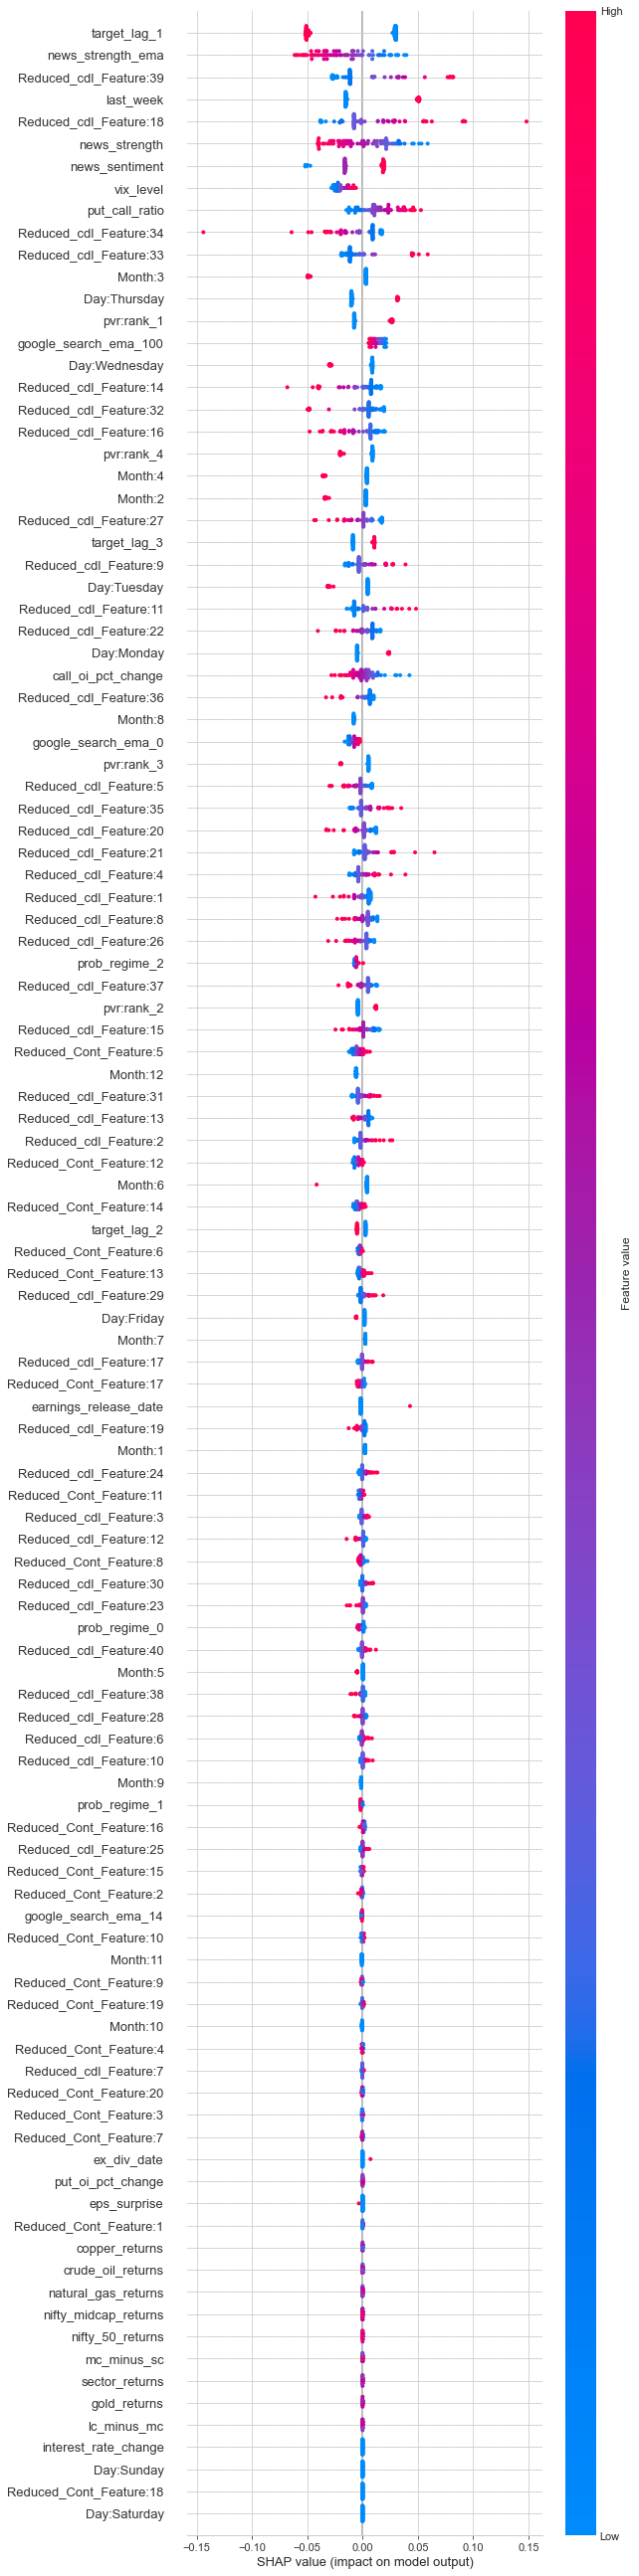

In [136]:
shap.plots.beeswarm(explanation,max_display=valid_features.shape[1])

The above shows the importance of each feature. The most important features seems to the last week indicators and the news sentiment indicators. There are many features that have almost zero importance. The least important features are removed. However, the day/time features are kept since some of the categories show good results.

Text(0, 0.5, 'Cumulative Feature Importance')

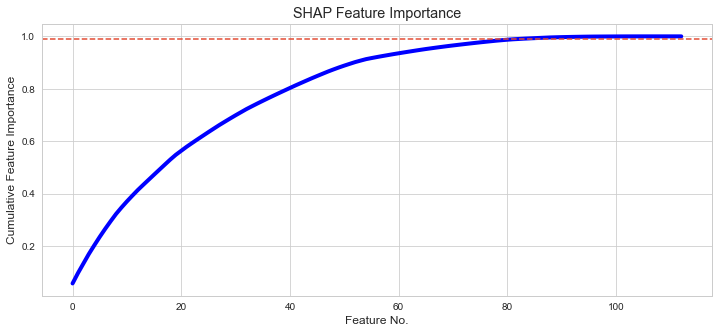

In [137]:
shap_feature_importance = np.abs(values).mean(axis=0)
shap_feature_importance /= np.sum(shap_feature_importance)

plt.figure(figsize=(12,5))
plt.plot(np.cumsum(np.sort(shap_feature_importance)[::-1]),color='b',lw=4)
plt.axhline(0.99,ls='--')
plt.title('SHAP Feature Importance')
plt.xlabel('Feature No.')
plt.ylabel('Cumulative Feature Importance')

The above graph shows that almost 80 features make up for 99% of the importance, 30 features are redundant. We investigate those 30 features below.

In [138]:
bottom_30 = features.columns[np.argsort(shap_feature_importance)[:30]]
bottom_30

Index(['Day:Saturday', 'Reduced_Cont_Feature:18', 'Day:Sunday',
       'interest_rate_change', 'lc_minus_mc', 'gold_returns', 'sector_returns',
       'mc_minus_sc', 'nifty_50_returns', 'nifty_midcap_returns',
       'natural_gas_returns', 'crude_oil_returns', 'copper_returns',
       'eps_surprise', 'Reduced_Cont_Feature:1', 'put_oi_pct_change',
       'ex_div_date', 'Reduced_Cont_Feature:7', 'Reduced_Cont_Feature:3',
       'Reduced_Cont_Feature:20', 'Reduced_cdl_Feature:7',
       'Reduced_Cont_Feature:4', 'Month:10', 'Reduced_Cont_Feature:19',
       'Reduced_Cont_Feature:9', 'Month:11', 'Reduced_Cont_Feature:10',
       'google_search_ema_14', 'Reduced_Cont_Feature:2',
       'Reduced_Cont_Feature:15'],
      dtype='object')

The features containing Day time categories are kept since they are part of the same variable and other categories have good importance. The features ```eps_surprise``` and ```ex_div_date``` are kept since they have low feature importance because of lower frequency but on investigating SHAP values, they seem to be significant on arrival. The remaining features are mostly macroeconomic features and autoencoded features which are removed.

In [139]:
#less_important_features = bottom_30[~bottom_30.isin([*day_of_week_coded.columns, 
#                                                    *month_coded.columns,
#                                                   'eps_surprise','ex_div_date'])]


# This is hard coded since the SHAP Values change everytime leading to variance in estimates. 
# Through trial and error, it is found that accuracy is higher when these features are removed.

less_important_features = ['Reduced_Cont_Feature:18', 'interest_rate_change', 'lc_minus_mc',
       'gold_returns', 'sector_returns', 'Reduced_Cont_Feature:1',
       'mc_minus_sc', 'nifty_50_returns', 'nifty_midcap_returns',
       'natural_gas_returns', 'Reduced_cdl_Feature:6', 'copper_returns',
       'crude_oil_returns', 'Reduced_cdl_Feature:7', 'Reduced_Cont_Feature:20',
       'Reduced_Cont_Feature:3','Reduced_cdl_Feature:24',
       'Reduced_Cont_Feature:7','Reduced_Cont_Feature:2']                                                                

In [140]:
features_imp = features.drop(less_important_features,axis=1)

#Train test split on only important features
train_features_imp = features_imp[train_start:train_end]
valid_features_imp = features_imp[valid_start:valid_end]
test_features_imp = features_imp[test_start:test_end]

In [141]:
# Using best prelim model to check if model is better
best_prelim_model.fit(train_features_imp,train_Y)

prelim_pred_model_4 = best_prelim_model.predict(valid_features_imp)

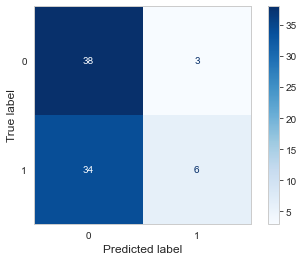

In [142]:
ConfusionMatrixDisplay.from_predictions(valid_Y,prelim_pred_model_4,cmap='Blues')
plt.grid()

In [143]:
print(classification_report(valid_Y,prelim_pred_model_4))

              precision    recall  f1-score   support

           0       0.53      0.93      0.67        41
           1       0.67      0.15      0.24        40

    accuracy                           0.54        81
   macro avg       0.60      0.54      0.46        81
weighted avg       0.60      0.54      0.46        81



In [144]:
accuracy,precision,recall,f1 = summary_scores(valid_Y,[prelim_pred_model_1,prelim_pred_model_2,
                                                               prelim_pred_model_3,prelim_pred_model_4])

print(tabulate([['Logistic (L2)',accuracy[0],precision[0],recall[0],f1[0]],
        ['Logistic (L1)',accuracy[1],precision[1],recall[1],f1[1]],
          ['Random Forest',accuracy[2],precision[2],recall[2],f1[2]],
                ['Logistic (L2) After SHAP Feature Selection',accuracy[3],precision[3],recall[3],f1[3]]],
               headers = ['Model','Accuracy','Precision','Recall','F1 Score']))

Model                                         Accuracy    Precision    Recall    F1 Score
------------------------------------------  ----------  -----------  --------  ----------
Logistic (L2)                                    0.568        0.727     0.2         0.314
Logistic (L1)                                    0.531        0.55      0.275       0.367
Random Forest                                    0.519        0.571     0.1         0.17
Logistic (L2) After SHAP Feature Selection       0.543        0.667     0.15        0.245


There is no change in performance. However we have eliminated redundant features some which may be correlated to other features.

In [145]:
print(f'Final No. of Features: {features_imp.shape[1]}')

Final No. of Features: 94


### 5.3 LSTM Model

LSTM is recurrent neural network that has the ability to keep previous activations in memory. It is mostly preferred to model timeseries.

#### 5.3.1 Model Creation

Below function creates an LSTM model with different hyperparameters.

In [146]:
def create_LSTM_model(time_step,
                      lstm_layers=2,
                      lstm_units=30,
                      lstm_initializer='glorot_normal',
                      lstm_regularizer= 'l2',
                      lstm_reg_penalty=0.01,
                      drop_out=False,
                      drop_out_rate=0.2,
                      model_optimizer=keras.optimizers.Adam,
                      model_metrics=[
                          keras.metrics.BinaryAccuracy(name='binary_accuracy'),
                          keras.metrics.F1Score(name='f1_score',threshold=0.5),
                          keras.metrics.AUC(name='roc_auc')
                      ],
                      model_learning_rate =0.001):

    
    # Setting up regularization
    if lstm_regularizer == 'l2':
        lstm_regularizer = keras.regularizers.l2
    elif lstm_regularizer =='l1':
        lstm_regularizer = keras.regularizers.l1
    
    #Input Layer
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(time_step, features_imp.shape[1]))
    ])

    for n in range(lstm_layers - 1):
        model.add(keras.layers.BatchNormalization(
            name=f'Batch_norm_{n+1}'))  # Batch Norm
        if drop_out:
            model.add(
                keras.layers.Dropout(drop_out_rate,
                                     name=f'Dropout_{n+1}'))  # Dropout

        # Hidden LSTM Layers
        model.add(
            keras.layers.LSTM(
                lstm_units,
                kernel_initializer=lstm_initializer,
                kernel_regularizer=lstm_regularizer(lstm_reg_penalty),
                return_sequences=True,
                name=f'LSTM_{n+1}'))

    model.add(keras.layers.BatchNormalization(
        name=f'Batch_norm_{lstm_layers}'))  # Batch Norm
    if drop_out:
        model.add(
            keras.layers.Dropout(drop_out_rate,
                                 name=f'Dropout_{lstm_layers}'))  #Dropout

    # Final LSTM
    model.add(
        keras.layers.LSTM(
            lstm_units,
            kernel_initializer=lstm_initializer,
            kernel_regularizer=lstm_regularizer(lstm_reg_penalty),
            return_sequences=False,
            name=f'LSTM_{lstm_layers}'))

    # Output Layer
    model.add(
        keras.layers.Dense(1,
                           activation='sigmoid',
                           kernel_initializer='glorot_normal',
                           name='Output'))

    # Compile the model
    model.compile(optimizer=model_optimizer(
        learning_rate= model_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=model_metrics)

    return model

The inputs have to be modified to be in the right shape for the model to work. Below code generates the sequence to be passed in the LSTM Model:

In [147]:
def time_step_generation(X,y,time_step):
    X = X.values
    y = y.values.astype('float').reshape(-1,1)
    
    output_x = np.zeros((X.shape[0]-time_step+1,time_step,X.shape[1]))
    
    for t in range(output_x.shape[0]):
        output_x[t,:,:] = X[t:t+time_step,:].reshape(1,time_step,output_x.shape[2])
        
    output_y = y[time_step-1:]
    
    return output_x,output_y

A separate function is created for compiling and running the LSTM Model. Two separate custom functions are created for ```Learning Rate Scheduling``` and ```Model Check point```.

In [148]:
# implementing a custom Model Checkpoint that monitors both training and validation metrics along with EarlyStopping:

class Model_Checkpoint_EarlyStopping_train_valid(keras.callbacks.ModelCheckpoint):
    def __init__(self, filepath,monitor,train_data,early_stopping=False,patience=10, **kwargs):
        super().__init__(filepath,monitor,mode='max', **kwargs)
        self.X_train,self.y_train = train_data
        self.save_best_only = True
        self.early_stopping = early_stopping
        self.patience = patience
        self.wait = 0
      
    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        
        #Calculating combined metric based on train and valid data
        train_metrics = self.model.evaluate(self.X_train,self.y_train)
        logs['train_loss'] = train_metrics[0]
        logs['train_binary_accuracy'] = train_metrics[1]
        logs['train_f1_score'] = train_metrics[2]
        logs['train_roc_auc'] = train_metrics[3]
        
        #Saving the model if it is best
        if self.save_freq == "epoch" and epoch >10:
            self._save_model(epoch=epoch, batch=None, logs=logs)
       
         # Early Stopping
        if self.best != logs[self.monitor]:
            self.wait +=1
        else:
            self.wait = 0
            
        if self.wait == self.patience and self.early_stopping:
            self.model.stop_training =True

Implementing a separate function for model execution

In [149]:
def model_run(model,
              train_data,valid_data, 
              check_point_file_path,
              metric = 'val_f1_score',
              epochs=100,
              patience=10,
              lr_update_freq = 30,
              lr_update=1.5,
              early_stopping=True):
    
    keras.backend.clear_session()
    
    X_train,y_train = train_data
    X_valid,y_valid = valid_data
    
    #Implementing a custom Learning Rate Schedule
    def custom_learning_rate(epoch,lr):
        if epoch % lr_update_freq==0:
            lr *= lr_update
        else:
            lr *= (0.9/lr_update )**(1/(lr_update_freq-1))
        return lr
    
    checkpoint_cb = Model_Checkpoint_EarlyStopping_train_valid(filepath=check_point_file_path,
                                                               monitor= metric,
                                                               train_data=train_data,
                                                               early_stopping=early_stopping,
                                                               patience=patience)
    
    lr_schedule = keras.callbacks.LearningRateScheduler(custom_learning_rate)
    
    callbacks =[checkpoint_cb,lr_schedule]
    
    
    history = model.fit(x = X_train, y= y_train, epochs = epochs, validation_data= (X_valid,y_valid), 
              shuffle=False,callbacks=callbacks,verbose=2, class_weight=class_weights)
    
    return history

#### 5.3.2 Preliminary LSTM Model

In [150]:
# Setting the time step to be 2
time_step = 2

In [151]:
# Getting the train and validation data in the right format
train_data = time_step_generation(train_features_imp,train_Y,time_step)

valid_data = time_step_generation(valid_features_imp,valid_Y,time_step)

In [152]:
# Creating the Model
lstm_prelim = create_LSTM_model(time_step)
lstm_prelim.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_norm_1 (BatchNormali  (None, 2, 94)             376       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 2, 30)             15000     
                                                                 
 Batch_norm_2 (BatchNormali  (None, 2, 30)             120       
 zation)                                                         
                                                                 
 LSTM_2 (LSTM)               (None, 30)                7320      
                                                                 
 Output (Dense)              (None, 1)                 31        
                                                                 
Total params: 22847 (89.25 KB)
Trainable params: 22599 (

In [602]:
# Model Run for 1000 epochs without early Stopping
history = model_run(model=lstm_prelim,train_data=train_data,
                                     valid_data=valid_data,check_point_file_path='./Model Outputs/LSTM_prelim',
                                     epochs=1000,early_stopping=False)

Epoch 1/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.2740 - binary_accuracy: 0.6170 - f1_score: 0.2258 - roc_auc: 0.5425


11/04/2023 02:33:34 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 8s - loss: 1.6782 - binary_accuracy: 0.5971 - f1_score: 0.5209 - roc_auc: 0.6271 - val_loss: 1.2792 - val_binary_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.4662 - train_loss: 1.2740 - train_binary_accuracy: 0.6170 - train_f1_score: 0.2258 - train_roc_auc: 0.5425 - lr: 0.0015 - 8s/epoch - 171ms/step
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 0.9249 - binary_accuracy: 0.6197 - f1_score: 0.1034 - roc_auc: 0.5679
47/47 - 0s - loss: 1.0509 - binary_accuracy: 0.5911 - f1_score: 0.5344 - roc_auc: 0.6417 - val_loss: 0.9405 - val_binary_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.4172 - train_loss: 0.9249 - train_binary_accuracy: 0.6197 - train_f1_score: 0.1034 - train_roc_auc: 0.5679 - lr: 0.0015 - 460ms/epoch - 10ms/step
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 0.7987 - binary_accuracy: 0.6024 - f1_score: 0.2048 - roc_auc: 0.5862


11/04/2023 02:33:40 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 5s - loss: 0.8282 - binary_accuracy: 0.6004 - f1_score: 0.5416 - roc_auc: 0.6584 - val_loss: 0.8174 - val_binary_accuracy: 0.5375 - val_f1_score: 0.2745 - val_roc_auc: 0.5044 - train_loss: 0.7987 - train_binary_accuracy: 0.6024 - train_f1_score: 0.2048 - train_roc_auc: 0.5862 - lr: 0.0014 - 5s/epoch - 106ms/step
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 0.7519 - binary_accuracy: 0.6064 - f1_score: 0.3333 - roc_auc: 0.5943
47/47 - 0s - loss: 0.7430 - binary_accuracy: 0.6177 - f1_score: 0.5574 - roc_auc: 0.6726 - val_loss: 0.7718 - val_binary_accuracy: 0.5250 - val_f1_score: 0.4571 - val_roc_auc: 0.5081 - train_loss: 0.7519 - train_binary_accuracy: 0.6064 - train_f1_score: 0.3333 - train_roc_auc: 0.5943 - lr: 0.0014 - 446ms/epoch - 9ms/step
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 0.7328 - binary_accuracy: 0.6024 - f1_score: 0.4194 - roc_auc: 0.6030
47/47 - 0s - loss: 0.7052 - binary_accuracy: 0.6316 - f1_score: 0.5

Epoch 21/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.1291 - binary_accuracy: 0.6503 - f1_score: 0.5278 - roc_auc: 0.6670
47/47 - 0s - loss: 0.3985 - binary_accuracy: 0.8983 - f1_score: 0.8728 - roc_auc: 0.9627 - val_loss: 1.9637 - val_binary_accuracy: 0.4500 - val_f1_score: 0.2414 - val_roc_auc: 0.4228 - train_loss: 1.1291 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5278 - train_roc_auc: 0.6670 - lr: 0.0011 - 442ms/epoch - 9ms/step
Epoch 22/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.2093 - binary_accuracy: 0.6536 - f1_score: 0.5233 - roc_auc: 0.6712
47/47 - 0s - loss: 0.3802 - binary_accuracy: 0.9043 - f1_score: 0.8800 - roc_auc: 0.9680 - val_loss: 2.0318 - val_binary_accuracy: 0.4625 - val_f1_score: 0.2456 - val_roc_auc: 0.4247 - train_loss: 1.2093 - train_binary_accuracy: 0.6536 - train_f1_score: 0.5233 - train_roc_auc: 0.6712 - lr: 0.0010 - 459ms/epoch - 10ms/step
Epoch 23/1000
47/47 [==============================] - 0s 2ms/s

Epoch 39/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.9738 - binary_accuracy: 0.6789 - f1_score: 0.5223 - roc_auc: 0.6733
47/47 - 0s - loss: 0.1906 - binary_accuracy: 0.9947 - f1_score: 0.9931 - roc_auc: 0.9999 - val_loss: 3.8954 - val_binary_accuracy: 0.5125 - val_f1_score: 0.2353 - val_roc_auc: 0.4672 - train_loss: 1.9738 - train_binary_accuracy: 0.6789 - train_f1_score: 0.5223 - train_roc_auc: 0.6733 - lr: 0.0012 - 442ms/epoch - 9ms/step
Epoch 40/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.9646 - binary_accuracy: 0.6888 - f1_score: 0.5375 - roc_auc: 0.6738
47/47 - 0s - loss: 0.1898 - binary_accuracy: 0.9900 - f1_score: 0.9870 - roc_auc: 0.9996 - val_loss: 3.6892 - val_binary_accuracy: 0.5250 - val_f1_score: 0.2400 - val_roc_auc: 0.4775 - train_loss: 1.9646 - train_binary_accuracy: 0.6888 - train_f1_score: 0.5375 - train_roc_auc: 0.6738 - lr: 0.0012 - 445ms/epoch - 9ms/step
Epoch 41/1000
47/47 [==============================] - 0s 2ms/st

Epoch 57/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1332 - binary_accuracy: 0.6729 - f1_score: 0.5583 - roc_auc: 0.6715
47/47 - 0s - loss: 0.1001 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 3.7190 - val_binary_accuracy: 0.5000 - val_f1_score: 0.3103 - val_roc_auc: 0.4681 - train_loss: 2.1332 - train_binary_accuracy: 0.6729 - train_f1_score: 0.5583 - train_roc_auc: 0.6715 - lr: 8.5395e-04 - 462ms/epoch - 10ms/step
Epoch 58/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1547 - binary_accuracy: 0.6702 - f1_score: 0.5564 - roc_auc: 0.6705
47/47 - 0s - loss: 0.0972 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 3.7393 - val_binary_accuracy: 0.5000 - val_f1_score: 0.3103 - val_roc_auc: 0.4778 - train_loss: 2.1547 - train_binary_accuracy: 0.6702 - train_f1_score: 0.5564 - train_roc_auc: 0.6705 - lr: 8.3904e-04 - 440ms/epoch - 9ms/step
Epoch 59/1000
47/47 [==============================] - 

11/04/2023 02:34:13 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 5s - loss: 0.3805 - binary_accuracy: 0.9136 - f1_score: 0.8898 - roc_auc: 0.9710 - val_loss: 2.4422 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3077 - val_roc_auc: 0.5359 - train_loss: 1.4022 - train_binary_accuracy: 0.6695 - train_f1_score: 0.5535 - train_roc_auc: 0.6977 - lr: 0.0011 - 5s/epoch - 101ms/step
Epoch 68/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.5431 - binary_accuracy: 0.6662 - f1_score: 0.5550 - roc_auc: 0.6929
47/47 - 0s - loss: 0.2486 - binary_accuracy: 0.9741 - f1_score: 0.9664 - roc_auc: 0.9958 - val_loss: 2.7007 - val_binary_accuracy: 0.4875 - val_f1_score: 0.2264 - val_roc_auc: 0.4919 - train_loss: 1.5431 - train_binary_accuracy: 0.6662 - train_f1_score: 0.5550 - train_roc_auc: 0.6929 - lr: 0.0011 - 428ms/epoch - 9ms/step
Epoch 69/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.6490 - binary_accuracy: 0.6662 - f1_score: 0.5589 - roc_auc: 0.6973
47/47 - 0s - loss: 0.1871 - binary_accuracy: 0.9953 - f1_score: 0

Epoch 85/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1563 - binary_accuracy: 0.6656 - f1_score: 0.5553 - roc_auc: 0.6757
47/47 - 0s - loss: 0.0839 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 3.8718 - val_binary_accuracy: 0.5000 - val_f1_score: 0.2857 - val_roc_auc: 0.5275 - train_loss: 2.1563 - train_binary_accuracy: 0.6656 - train_f1_score: 0.5553 - train_roc_auc: 0.6757 - lr: 7.9612e-04 - 469ms/epoch - 10ms/step
Epoch 86/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1806 - binary_accuracy: 0.6642 - f1_score: 0.5535 - roc_auc: 0.6750
47/47 - 0s - loss: 0.0819 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 3.9039 - val_binary_accuracy: 0.5000 - val_f1_score: 0.2857 - val_roc_auc: 0.5191 - train_loss: 2.1806 - train_binary_accuracy: 0.6642 - train_f1_score: 0.5535 - train_roc_auc: 0.6750 - lr: 7.8222e-04 - 457ms/epoch - 10ms/step
Epoch 87/1000
47/47 [==============================] -

11/04/2023 02:34:32 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 5s - loss: 0.4894 - binary_accuracy: 0.8590 - f1_score: 0.8245 - roc_auc: 0.9312 - val_loss: 2.0112 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3137 - val_roc_auc: 0.5669 - train_loss: 1.3901 - train_binary_accuracy: 0.6556 - train_f1_score: 0.5400 - train_roc_auc: 0.6864 - lr: 9.6665e-04 - 5s/epoch - 101ms/step
Epoch 99/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.5273 - binary_accuracy: 0.6656 - f1_score: 0.5529 - roc_auc: 0.6864


11/04/2023 02:34:36 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 5s - loss: 0.2659 - binary_accuracy: 0.9581 - f1_score: 0.9464 - roc_auc: 0.9908 - val_loss: 2.3826 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3704 - val_roc_auc: 0.5406 - train_loss: 1.5273 - train_binary_accuracy: 0.6656 - train_f1_score: 0.5529 - train_roc_auc: 0.6864 - lr: 9.4977e-04 - 5s/epoch - 101ms/step
Epoch 100/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.6800 - binary_accuracy: 0.6642 - f1_score: 0.5405 - roc_auc: 0.6814
47/47 - 0s - loss: 0.1842 - binary_accuracy: 0.9907 - f1_score: 0.9879 - roc_auc: 0.9993 - val_loss: 2.9269 - val_binary_accuracy: 0.5375 - val_f1_score: 0.2449 - val_roc_auc: 0.5325 - train_loss: 1.6800 - train_binary_accuracy: 0.6642 - train_f1_score: 0.5405 - train_roc_auc: 0.6814 - lr: 9.3319e-04 - 416ms/epoch - 9ms/step
Epoch 101/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.7958 - binary_accuracy: 0.6662 - f1_score: 0.5445 - roc_auc: 0.6819
47/47 - 0s - loss: 0.1547 - binary_accuracy: 0.9993 - f

Epoch 117/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.2887 - binary_accuracy: 0.6523 - f1_score: 0.5384 - roc_auc: 0.6649
47/47 - 0s - loss: 0.0764 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.0067 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5628 - train_loss: 2.2887 - train_binary_accuracy: 0.6523 - train_f1_score: 0.5384 - train_roc_auc: 0.6649 - lr: 6.9170e-04 - 454ms/epoch - 10ms/step
Epoch 118/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3099 - binary_accuracy: 0.6503 - f1_score: 0.5345 - roc_auc: 0.6631
47/47 - 0s - loss: 0.0748 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.0336 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5619 - train_loss: 2.3099 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5345 - train_roc_auc: 0.6631 - lr: 6.7963e-04 - 450ms/epoch - 10ms/step
Epoch 119/1000
47/47 [==============================

47/47 - 0s - loss: 0.0523 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.5931 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5450 - train_loss: 2.7096 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5418 - train_roc_auc: 0.6477 - lr: 7.8273e-04 - 441ms/epoch - 9ms/step
Epoch 135/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.7308 - binary_accuracy: 0.6503 - f1_score: 0.5426 - roc_auc: 0.6470
47/47 - 0s - loss: 0.0514 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.6255 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5444 - train_loss: 2.7308 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5426 - train_roc_auc: 0.6470 - lr: 7.6906e-04 - 455ms/epoch - 10ms/step
Epoch 136/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.7530 - binary_accuracy: 0.6496 - f1_score: 0.5421 - roc_auc: 0.6469
47/47 - 0s - loss: 0.0505 - binary_accuracy: 1.0000 -

11/04/2023 02:35:02 PM - Assets written to: ./Model Outputs\LSTM_prelim\assets


47/47 - 5s - loss: 0.0541 - binary_accuracy: 0.9967 - f1_score: 0.9957 - roc_auc: 1.0000 - val_loss: 3.0525 - val_binary_accuracy: 0.6125 - val_f1_score: 0.5634 - val_roc_auc: 0.6187 - train_loss: 2.8798 - train_binary_accuracy: 0.6330 - train_f1_score: 0.5298 - train_roc_auc: 0.6409 - lr: 6.4486e-04 - 5s/epoch - 101ms/step
Epoch 146/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3150 - binary_accuracy: 0.6217 - f1_score: 0.5254 - roc_auc: 0.6327
47/47 - 0s - loss: 1.2574 - binary_accuracy: 0.7447 - f1_score: 0.6908 - roc_auc: 0.8107 - val_loss: 3.8118 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4615 - val_roc_auc: 0.6094 - train_loss: 2.3150 - train_binary_accuracy: 0.6217 - train_f1_score: 0.5254 - train_roc_auc: 0.6327 - lr: 6.3360e-04 - 402ms/epoch - 9ms/step
Epoch 147/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.4799 - binary_accuracy: 0.6516 - f1_score: 0.5498 - roc_auc: 0.6774
47/47 - 0s - loss: 0.5036 - binary_accuracy: 0.8557 - f

Epoch 163/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3747 - binary_accuracy: 0.6529 - f1_score: 0.5523 - roc_auc: 0.6751
47/47 - 0s - loss: 0.0614 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.1111 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4000 - val_roc_auc: 0.5419 - train_loss: 2.3747 - train_binary_accuracy: 0.6529 - train_f1_score: 0.5523 - train_roc_auc: 0.6751 - lr: 7.1698e-04 - 451ms/epoch - 10ms/step
Epoch 164/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3944 - binary_accuracy: 0.6503 - f1_score: 0.5489 - roc_auc: 0.6733
47/47 - 0s - loss: 0.0602 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.1394 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4000 - val_roc_auc: 0.5419 - train_loss: 2.3944 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5489 - train_roc_auc: 0.6733 - lr: 7.0446e-04 - 451ms/epoch - 10ms/step
Epoch 165/1000
47/47 [==============================

Epoch 198/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0602 - binary_accuracy: 0.6217 - f1_score: 0.5262 - roc_auc: 0.6392
47/47 - 0s - loss: 0.0372 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.9578 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3273 - val_roc_auc: 0.5416 - train_loss: 3.0602 - train_binary_accuracy: 0.6217 - train_f1_score: 0.5262 - train_roc_auc: 0.6392 - lr: 5.9088e-04 - 471ms/epoch - 10ms/step
Epoch 199/1000
47/47 [==============================] - 0s 2ms/step - loss: 3.0796 - binary_accuracy: 0.6203 - f1_score: 0.5238 - roc_auc: 0.6387
47/47 - 0s - loss: 0.0368 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.9743 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3273 - val_roc_auc: 0.5422 - train_loss: 3.0796 - train_binary_accuracy: 0.6203 - train_f1_score: 0.5238 - train_roc_auc: 0.6387 - lr: 5.8056e-04 - 484ms/epoch - 10ms/step
Epoch 200/1000
47/47 [==============================

Epoch 233/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3793 - binary_accuracy: 0.6516 - f1_score: 0.5611 - roc_auc: 0.6723
47/47 - 0s - loss: 0.0609 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 3.9842 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3929 - val_roc_auc: 0.5544 - train_loss: 2.3793 - train_binary_accuracy: 0.6516 - train_f1_score: 0.5611 - train_roc_auc: 0.6723 - lr: 4.8696e-04 - 455ms/epoch - 10ms/step
Epoch 234/1000
47/47 [==============================] - 0s 3ms/step - loss: 2.3949 - binary_accuracy: 0.6503 - f1_score: 0.5595 - roc_auc: 0.6716
47/47 - 1s - loss: 0.0597 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.0066 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3929 - val_roc_auc: 0.5547 - train_loss: 2.3949 - train_binary_accuracy: 0.6503 - train_f1_score: 0.5595 - train_roc_auc: 0.6716 - lr: 4.7845e-04 - 570ms/epoch - 12ms/step
Epoch 235/1000
47/47 [==============================

Epoch 268/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.8739 - binary_accuracy: 0.6323 - f1_score: 0.5411 - roc_auc: 0.6424
47/47 - 0s - loss: 0.0362 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.6596 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3158 - val_roc_auc: 0.5531 - train_loss: 2.8739 - train_binary_accuracy: 0.6323 - train_f1_score: 0.5411 - train_roc_auc: 0.6424 - lr: 4.0131e-04 - 450ms/epoch - 10ms/step
Epoch 269/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.8880 - binary_accuracy: 0.6297 - f1_score: 0.5378 - roc_auc: 0.6413
47/47 - 0s - loss: 0.0358 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.6762 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3158 - val_roc_auc: 0.5531 - train_loss: 2.8880 - train_binary_accuracy: 0.6297 - train_f1_score: 0.5378 - train_roc_auc: 0.6413 - lr: 3.9431e-04 - 450ms/epoch - 10ms/step
Epoch 270/1000
47/47 [==============================

Epoch 303/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.7708 - binary_accuracy: 0.6356 - f1_score: 0.5537 - roc_auc: 0.6629
47/47 - 0s - loss: 0.0472 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.8868 - val_binary_accuracy: 0.5125 - val_f1_score: 0.2642 - val_roc_auc: 0.5453 - train_loss: 2.7708 - train_binary_accuracy: 0.6356 - train_f1_score: 0.5537 - train_roc_auc: 0.6629 - lr: 5.0491e-04 - 463ms/epoch - 10ms/step
Epoch 304/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.7839 - binary_accuracy: 0.6363 - f1_score: 0.5542 - roc_auc: 0.6624
47/47 - 0s - loss: 0.0464 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.8995 - val_binary_accuracy: 0.5250 - val_f1_score: 0.2963 - val_roc_auc: 0.5456 - train_loss: 2.7839 - train_binary_accuracy: 0.6363 - train_f1_score: 0.5542 - train_roc_auc: 0.6624 - lr: 4.9610e-04 - 463ms/epoch - 10ms/step
Epoch 305/1000
47/47 [==============================

Epoch 338/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.1587 - binary_accuracy: 0.6250 - f1_score: 0.5354 - roc_auc: 0.6390
47/47 - 1s - loss: 0.0315 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.2385 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5716 - train_loss: 3.1587 - train_binary_accuracy: 0.6250 - train_f1_score: 0.5354 - train_roc_auc: 0.6390 - lr: 4.1611e-04 - 831ms/epoch - 18ms/step
Epoch 339/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.1707 - binary_accuracy: 0.6250 - f1_score: 0.5362 - roc_auc: 0.6384
47/47 - 1s - loss: 0.0311 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.2523 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5713 - train_loss: 3.1707 - train_binary_accuracy: 0.6250 - train_f1_score: 0.5362 - train_roc_auc: 0.6384 - lr: 4.0885e-04 - 794ms/epoch - 17ms/step
Epoch 340/1000
47/47 [==============================

Epoch 373/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.6837 - binary_accuracy: 0.6436 - f1_score: 0.5434 - roc_auc: 0.6568
47/47 - 1s - loss: 0.0527 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.5277 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5425 - train_loss: 2.6837 - train_binary_accuracy: 0.6436 - train_f1_score: 0.5434 - train_roc_auc: 0.6568 - lr: 3.4293e-04 - 825ms/epoch - 18ms/step
Epoch 374/1000
47/47 [==============================] - 0s 4ms/step - loss: 2.7069 - binary_accuracy: 0.6430 - f1_score: 0.5422 - roc_auc: 0.6571
47/47 - 1s - loss: 0.0514 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.5506 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5503 - train_loss: 2.7069 - train_binary_accuracy: 0.6430 - train_f1_score: 0.5422 - train_roc_auc: 0.6571 - lr: 3.3694e-04 - 812ms/epoch - 17ms/step
Epoch 375/1000
47/47 [==============================

Epoch 408/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.0389 - binary_accuracy: 0.6336 - f1_score: 0.5319 - roc_auc: 0.6407
47/47 - 1s - loss: 0.0334 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.9659 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3636 - val_roc_auc: 0.5666 - train_loss: 3.0389 - train_binary_accuracy: 0.6336 - train_f1_score: 0.5319 - train_roc_auc: 0.6407 - lr: 2.8261e-04 - 755ms/epoch - 16ms/step
Epoch 409/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.0452 - binary_accuracy: 0.6336 - f1_score: 0.5311 - roc_auc: 0.6403
47/47 - 1s - loss: 0.0332 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 4.9768 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3636 - val_roc_auc: 0.5663 - train_loss: 3.0452 - train_binary_accuracy: 0.6336 - train_f1_score: 0.5311 - train_roc_auc: 0.6403 - lr: 2.7768e-04 - 780ms/epoch - 17ms/step
Epoch 410/1000
47/47 [==============================

Epoch 443/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.2758 - binary_accuracy: 0.6250 - f1_score: 0.5245 - roc_auc: 0.6307
47/47 - 1s - loss: 0.0253 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.4366 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5406 - train_loss: 3.2758 - train_binary_accuracy: 0.6250 - train_f1_score: 0.5245 - train_roc_auc: 0.6307 - lr: 2.3291e-04 - 746ms/epoch - 16ms/step
Epoch 444/1000
47/47 [==============================] - 0s 3ms/step - loss: 3.2828 - binary_accuracy: 0.6243 - f1_score: 0.5232 - roc_auc: 0.6310
47/47 - 1s - loss: 0.0251 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.4476 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5403 - train_loss: 3.2828 - train_binary_accuracy: 0.6243 - train_f1_score: 0.5232 - train_roc_auc: 0.6310 - lr: 2.2884e-04 - 636ms/epoch - 14ms/step
Epoch 445/1000
47/47 [==============================

Epoch 478/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.1669 - binary_accuracy: 0.6356 - f1_score: 0.5372 - roc_auc: 0.6531
47/47 - 1s - loss: 0.0330 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.2454 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3729 - val_roc_auc: 0.5469 - train_loss: 3.1669 - train_binary_accuracy: 0.6356 - train_f1_score: 0.5372 - train_roc_auc: 0.6531 - lr: 1.9195e-04 - 845ms/epoch - 18ms/step
Epoch 479/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.1678 - binary_accuracy: 0.6356 - f1_score: 0.5372 - roc_auc: 0.6541
47/47 - 1s - loss: 0.0325 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.2591 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3448 - val_roc_auc: 0.5453 - train_loss: 3.1678 - train_binary_accuracy: 0.6356 - train_f1_score: 0.5372 - train_roc_auc: 0.6541 - lr: 1.8859e-04 - 866ms/epoch - 18ms/step
Epoch 480/1000
47/47 [==============================

Epoch 513/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.2089 - binary_accuracy: 0.6323 - f1_score: 0.5333 - roc_auc: 0.6454
47/47 - 1s - loss: 0.0250 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.4664 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5425 - train_loss: 3.2089 - train_binary_accuracy: 0.6323 - train_f1_score: 0.5333 - train_roc_auc: 0.6454 - lr: 2.4150e-04 - 831ms/epoch - 18ms/step
Epoch 514/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.2114 - binary_accuracy: 0.6316 - f1_score: 0.5329 - roc_auc: 0.6453
47/47 - 1s - loss: 0.0248 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.4737 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3333 - val_roc_auc: 0.5422 - train_loss: 3.2114 - train_binary_accuracy: 0.6316 - train_f1_score: 0.5329 - train_roc_auc: 0.6453 - lr: 2.3728e-04 - 780ms/epoch - 17ms/step
Epoch 515/1000
47/47 [==============================

Epoch 548/1000
47/47 [==============================] - 0s 3ms/step - loss: 3.3933 - binary_accuracy: 0.6263 - f1_score: 0.5285 - roc_auc: 0.6276
47/47 - 1s - loss: 0.0210 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.7688 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5481 - train_loss: 3.3933 - train_binary_accuracy: 0.6263 - train_f1_score: 0.5285 - train_roc_auc: 0.6276 - lr: 1.9902e-04 - 520ms/epoch - 11ms/step
Epoch 549/1000
47/47 [==============================] - 0s 3ms/step - loss: 3.4024 - binary_accuracy: 0.6257 - f1_score: 0.5281 - roc_auc: 0.6266
47/47 - 1s - loss: 0.0208 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 5.7802 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5484 - train_loss: 3.4024 - train_binary_accuracy: 0.6257 - train_f1_score: 0.5281 - train_roc_auc: 0.6266 - lr: 1.9555e-04 - 536ms/epoch - 11ms/step
Epoch 550/1000
47/47 [==============================

Epoch 583/1000
47/47 [==============================] - 0s 3ms/step - loss: 3.7388 - binary_accuracy: 0.6210 - f1_score: 0.5289 - roc_auc: 0.6223
47/47 - 1s - loss: 0.0178 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.1894 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3462 - val_roc_auc: 0.5487 - train_loss: 3.7388 - train_binary_accuracy: 0.6210 - train_f1_score: 0.5289 - train_roc_auc: 0.6223 - lr: 1.6402e-04 - 646ms/epoch - 14ms/step
Epoch 584/1000
47/47 [==============================] - 0s 4ms/step - loss: 3.7525 - binary_accuracy: 0.6217 - f1_score: 0.5294 - roc_auc: 0.6219
47/47 - 1s - loss: 0.0177 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.2008 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3462 - val_roc_auc: 0.5484 - train_loss: 3.7525 - train_binary_accuracy: 0.6217 - train_f1_score: 0.5294 - train_roc_auc: 0.6219 - lr: 1.6116e-04 - 683ms/epoch - 15ms/step
Epoch 585/1000
47/47 [==============================

Epoch 618/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.2365 - binary_accuracy: 0.6150 - f1_score: 0.5379 - roc_auc: 0.6307
47/47 - 1s - loss: 0.0233 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.3491 - val_binary_accuracy: 0.5250 - val_f1_score: 0.2692 - val_roc_auc: 0.5444 - train_loss: 4.2365 - train_binary_accuracy: 0.6150 - train_f1_score: 0.5379 - train_roc_auc: 0.6307 - lr: 1.3517e-04 - 784ms/epoch - 17ms/step
Epoch 619/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.2354 - binary_accuracy: 0.6150 - f1_score: 0.5379 - roc_auc: 0.6315
47/47 - 1s - loss: 0.0232 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.3423 - val_binary_accuracy: 0.5250 - val_f1_score: 0.2692 - val_roc_auc: 0.5444 - train_loss: 4.2354 - train_binary_accuracy: 0.6150 - train_f1_score: 0.5379 - train_roc_auc: 0.6315 - lr: 1.3281e-04 - 779ms/epoch - 17ms/step
Epoch 620/1000
47/47 [==============================

Epoch 653/1000
47/47 [==============================] - 0s 5ms/step - loss: 4.1741 - binary_accuracy: 0.6137 - f1_score: 0.5363 - roc_auc: 0.6223
47/47 - 1s - loss: 0.0195 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.0026 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5378 - train_loss: 4.1741 - train_binary_accuracy: 0.6137 - train_f1_score: 0.5363 - train_roc_auc: 0.6223 - lr: 1.1140e-04 - 824ms/epoch - 18ms/step
Epoch 654/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.1721 - binary_accuracy: 0.6137 - f1_score: 0.5363 - roc_auc: 0.6223
47/47 - 1s - loss: 0.0194 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.9922 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5378 - train_loss: 4.1721 - train_binary_accuracy: 0.6137 - train_f1_score: 0.5363 - train_roc_auc: 0.6223 - lr: 1.0945e-04 - 817ms/epoch - 17ms/step
Epoch 655/1000
47/47 [==============================

Epoch 688/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.1224 - binary_accuracy: 0.6090 - f1_score: 0.5243 - roc_auc: 0.6147
47/47 - 1s - loss: 0.0171 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.7115 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5403 - train_loss: 4.1224 - train_binary_accuracy: 0.6090 - train_f1_score: 0.5243 - train_roc_auc: 0.6147 - lr: 9.1807e-05 - 829ms/epoch - 18ms/step
Epoch 689/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.1228 - binary_accuracy: 0.6084 - f1_score: 0.5231 - roc_auc: 0.6152
47/47 - 1s - loss: 0.0171 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.7086 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5403 - train_loss: 4.1228 - train_binary_accuracy: 0.6084 - train_f1_score: 0.5231 - train_roc_auc: 0.6152 - lr: 9.0204e-05 - 749ms/epoch - 16ms/step
Epoch 690/1000
47/47 [==============================

Epoch 723/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.2140 - binary_accuracy: 0.6064 - f1_score: 0.5218 - roc_auc: 0.6134
47/47 - 1s - loss: 0.0153 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.6821 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3636 - val_roc_auc: 0.5509 - train_loss: 4.2140 - train_binary_accuracy: 0.6064 - train_f1_score: 0.5218 - train_roc_auc: 0.6134 - lr: 1.1551e-04 - 806ms/epoch - 17ms/step
Epoch 724/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.2243 - binary_accuracy: 0.6064 - f1_score: 0.5226 - roc_auc: 0.6134
47/47 - 1s - loss: 0.0152 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 6.6935 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3636 - val_roc_auc: 0.5512 - train_loss: 4.2243 - train_binary_accuracy: 0.6064 - train_f1_score: 0.5226 - train_roc_auc: 0.6134 - lr: 1.1349e-04 - 845ms/epoch - 18ms/step
Epoch 725/1000
47/47 [==============================

Epoch 758/1000
47/47 [==============================] - 0s 4ms/step - loss: 5.3465 - binary_accuracy: 0.5944 - f1_score: 0.5279 - roc_auc: 0.6146
47/47 - 1s - loss: 0.0594 - binary_accuracy: 0.9854 - f1_score: 0.9809 - roc_auc: 0.9979 - val_loss: 8.3250 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3019 - val_roc_auc: 0.5569 - train_loss: 5.3465 - train_binary_accuracy: 0.5944 - train_f1_score: 0.5279 - train_roc_auc: 0.6146 - lr: 9.5193e-05 - 808ms/epoch - 17ms/step
Epoch 759/1000
47/47 [==============================] - 0s 4ms/step - loss: 5.1744 - binary_accuracy: 0.6011 - f1_score: 0.5290 - roc_auc: 0.6138
47/47 - 1s - loss: 0.0226 - binary_accuracy: 0.9993 - f1_score: 0.9991 - roc_auc: 1.0000 - val_loss: 8.1028 - val_binary_accuracy: 0.5250 - val_f1_score: 0.2692 - val_roc_auc: 0.5353 - train_loss: 5.1744 - train_binary_accuracy: 0.6011 - train_f1_score: 0.5290 - train_roc_auc: 0.6138 - lr: 9.3531e-05 - 806ms/epoch - 17ms/step
Epoch 760/1000
47/47 [==============================

Epoch 793/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.8147 - binary_accuracy: 0.6077 - f1_score: 0.5250 - roc_auc: 0.6163
47/47 - 1s - loss: 0.0155 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.8957 - val_binary_accuracy: 0.5375 - val_f1_score: 0.2745 - val_roc_auc: 0.5500 - train_loss: 4.8147 - train_binary_accuracy: 0.6077 - train_f1_score: 0.5250 - train_roc_auc: 0.6163 - lr: 7.8451e-05 - 795ms/epoch - 17ms/step
Epoch 794/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.8084 - binary_accuracy: 0.6077 - f1_score: 0.5250 - roc_auc: 0.6158
47/47 - 1s - loss: 0.0155 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.8867 - val_binary_accuracy: 0.5375 - val_f1_score: 0.2745 - val_roc_auc: 0.5500 - train_loss: 4.8084 - train_binary_accuracy: 0.6077 - train_f1_score: 0.5250 - train_roc_auc: 0.6158 - lr: 7.7081e-05 - 773ms/epoch - 16ms/step
Epoch 795/1000
47/47 [==============================

Epoch 828/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.6325 - binary_accuracy: 0.6051 - f1_score: 0.5186 - roc_auc: 0.6118
47/47 - 1s - loss: 0.0142 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.5229 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5487 - train_loss: 4.6325 - train_binary_accuracy: 0.6051 - train_f1_score: 0.5186 - train_roc_auc: 0.6118 - lr: 6.4653e-05 - 780ms/epoch - 17ms/step
Epoch 829/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.6295 - binary_accuracy: 0.6051 - f1_score: 0.5186 - roc_auc: 0.6122
47/47 - 1s - loss: 0.0142 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.5126 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5487 - train_loss: 4.6295 - train_binary_accuracy: 0.6051 - train_f1_score: 0.5186 - train_roc_auc: 0.6122 - lr: 6.3524e-05 - 815ms/epoch - 17ms/step
Epoch 830/1000
47/47 [==============================

Epoch 863/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.6158 - binary_accuracy: 0.6044 - f1_score: 0.5182 - roc_auc: 0.6107
47/47 - 1s - loss: 0.0131 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.2482 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5600 - train_loss: 4.6158 - train_binary_accuracy: 0.6044 - train_f1_score: 0.5182 - train_roc_auc: 0.6107 - lr: 5.3282e-05 - 823ms/epoch - 18ms/step
Epoch 864/1000
47/47 [==============================] - 0s 5ms/step - loss: 4.6179 - binary_accuracy: 0.6037 - f1_score: 0.5178 - roc_auc: 0.6106
47/47 - 1s - loss: 0.0131 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.2455 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5600 - train_loss: 4.6179 - train_binary_accuracy: 0.6037 - train_f1_score: 0.5178 - train_roc_auc: 0.6106 - lr: 5.2352e-05 - 826ms/epoch - 18ms/step
Epoch 865/1000
47/47 [==============================

Epoch 898/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.7680 - binary_accuracy: 0.5964 - f1_score: 0.5117 - roc_auc: 0.6056
47/47 - 1s - loss: 0.0122 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.2734 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5581 - train_loss: 4.7680 - train_binary_accuracy: 0.5964 - train_f1_score: 0.5117 - train_roc_auc: 0.6056 - lr: 4.3911e-05 - 801ms/epoch - 17ms/step
Epoch 899/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.7734 - binary_accuracy: 0.5964 - f1_score: 0.5117 - roc_auc: 0.6051
47/47 - 1s - loss: 0.0122 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.2758 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3396 - val_roc_auc: 0.5581 - train_loss: 4.7734 - train_binary_accuracy: 0.5964 - train_f1_score: 0.5117 - train_roc_auc: 0.6051 - lr: 4.3144e-05 - 777ms/epoch - 17ms/step
Epoch 900/1000
47/47 [==============================

Epoch 933/1000
47/47 [==============================] - 0s 4ms/step - loss: 4.9465 - binary_accuracy: 0.5984 - f1_score: 0.5145 - roc_auc: 0.6055
47/47 - 1s - loss: 0.0114 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.4244 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3704 - val_roc_auc: 0.5506 - train_loss: 4.9465 - train_binary_accuracy: 0.5984 - train_f1_score: 0.5145 - train_roc_auc: 0.6055 - lr: 5.5247e-05 - 807ms/epoch - 17ms/step
Epoch 934/1000
47/47 [==============================] - 0s 4ms/step - loss: 5.0505 - binary_accuracy: 0.5971 - f1_score: 0.5129 - roc_auc: 0.6024
47/47 - 1s - loss: 0.0115 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 7.5112 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3636 - val_roc_auc: 0.5431 - train_loss: 5.0505 - train_binary_accuracy: 0.5971 - train_f1_score: 0.5129 - train_roc_auc: 0.6024 - lr: 5.4282e-05 - 795ms/epoch - 17ms/step
Epoch 935/1000
47/47 [==============================

Epoch 968/1000
47/47 [==============================] - 0s 4ms/step - loss: 5.2300 - binary_accuracy: 0.5964 - f1_score: 0.5140 - roc_auc: 0.6093
47/47 - 1s - loss: 0.0119 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 8.1013 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3137 - val_roc_auc: 0.5256 - train_loss: 5.2300 - train_binary_accuracy: 0.5964 - train_f1_score: 0.5140 - train_roc_auc: 0.6093 - lr: 4.5530e-05 - 796ms/epoch - 17ms/step
Epoch 969/1000
47/47 [==============================] - 0s 4ms/step - loss: 5.2283 - binary_accuracy: 0.5964 - f1_score: 0.5140 - roc_auc: 0.6095
47/47 - 1s - loss: 0.0118 - binary_accuracy: 1.0000 - f1_score: 1.0000 - roc_auc: 1.0000 - val_loss: 8.0973 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3462 - val_roc_auc: 0.5253 - train_loss: 5.2283 - train_binary_accuracy: 0.5964 - train_f1_score: 0.5140 - train_roc_auc: 0.6095 - lr: 4.4735e-05 - 774ms/epoch - 16ms/step
Epoch 970/1000
47/47 [==============================

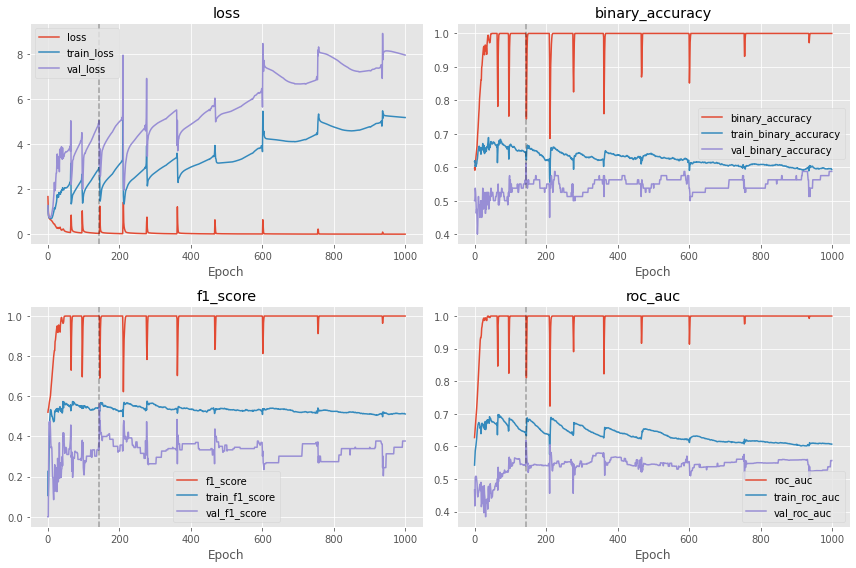

In [613]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
best_epoch = np.argmax(history.history['val_f1_score'])
for i,val in enumerate(['loss','binary_accuracy','f1_score','roc_auc']):
    row = i//2
    col = i%2
    ax[row][col].plot(history.history[val],label=val)
    ax[row][col].plot(history.history['train_'+val],label='train_'+val)
    ax[row][col].plot(history.history['val_'+val],label='val_'+val)
    ax[row][col].set_title(val)
    ax[row][col].set_xlabel('Epoch')
    ax[row][col].legend()
    ax[row][col].axvline(x=best_epoch,ls='--',alpha=0.3,c='k')
plt.tight_layout()

In [153]:
# Loading the best saved model
lstm_prelim_model_fitted = keras.models.load_model('./Model Outputs/LSTM_prelim')

In [154]:
full_valid_X = pd.concat([pd.DataFrame([train_features_imp.iloc[-1]]),valid_features_imp])
full_valid_Y = pd.concat([train_Y.iloc[-1:],valid_Y])
full_valid_data = time_step_generation(full_valid_X,full_valid_Y,time_step=2)

In [155]:
lstm_prelim_prediction = (lstm_prelim_model_fitted.predict(full_valid_data[0]).ravel()>0.5)*1

3/3 [==============================] - 1s 2ms/step


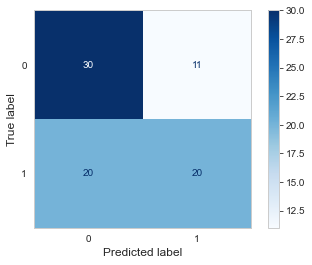

In [156]:
ConfusionMatrixDisplay.from_predictions(valid_Y,lstm_prelim_prediction,cmap='Blues')
plt.grid()

In [157]:
print(classification_report(valid_Y,lstm_prelim_prediction))

              precision    recall  f1-score   support

           0       0.60      0.73      0.66        41
           1       0.65      0.50      0.56        40

    accuracy                           0.62        81
   macro avg       0.62      0.62      0.61        81
weighted avg       0.62      0.62      0.61        81



In [158]:
print(f'ROC AUC:{roc_auc_score(valid_Y,np.ravel(lstm_prelim_model_fitted.predict(full_valid_data[0]))):.3f}')

3/3 [==============================] - 0s 3ms/step
ROC AUC:0.632


### 5.4 Hyper Parameter Tuning - LSTM

Hyperparameter Tuning is done using Keras Tuner. First, a function is created that does the hyperparameter tuning.

In [159]:
import keras_tuner

Using TensorFlow backend


#### 5.4.1 Random Search Setup

A function that ouputs the LSTM model with its hyperparameters is created.

In [160]:
def model_tuning(hp):
    
    hp_time_step = hp.Int(name='time_step',min_value=2,max_value=10)
    hp_lstm_layers= hp.Int(name='LSTM_layers',min_value=2,max_value =5)
    hp_lstm_units= hp.Int(name='LSTM_units',min_value=10,max_value=100)
    hp_lstm_initializer=hp.Choice(name='lstm_initializer',values=['glorot_normal','he_normal'])
    hp_lstm_regularizer= hp.Choice(name='lstm_regularizer',values=['l2','l1'])
    hp_lstm_reg_penalty= hp.Float(name='lstm_reg_penalty',min_value=0.001,max_value=0.1,sampling='log') 
    hp_drop_out= hp.Boolean(name = 'dropout')
    hp_drop_out_rate= hp.Float(name='dropout_rate',min_value=0,max_value=1,step=0.05)
    hp_model_learning_rate= hp.Float(name='learning_rate',min_value=0.0001,max_value=0.01,sampling='log')
    
    model = create_LSTM_model(time_step=hp_time_step,
                              lstm_layers=hp_lstm_layers,
                              lstm_units=hp_lstm_units,
                              lstm_initializer=hp_lstm_initializer,
                              lstm_regularizer=hp_lstm_regularizer,
                              lstm_reg_penalty=hp_lstm_reg_penalty,
                              drop_out=hp_drop_out,
                              drop_out_rate=hp_drop_out_rate,
                              model_learning_rate=hp_model_learning_rate)
                            
    
    return model

A custom tuner that uses ```RandomSearch``` class from keras-tuner is implemented. This allows to tune for the no. of time steps and change the train and validation data accordingly.

In [161]:
class RandomSearch_LSTM(keras_tuner.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        time_step = trial.hyperparameters.get('time_step')
        X_train,y_train = time_step_generation(kwargs['x'],kwargs['y'],time_step)
        X_valid,y_valid = time_step_generation(kwargs['validation_data'][0],
                                                         kwargs['validation_data'][1],time_step)
        
        kwargs['x'] = X_train
        kwargs['y'] = y_train
        kwargs['validation_data'] = (X_valid,y_valid)
        
        return super().run_trial(trial, *args, **kwargs)

Creating Custom Callbacks to log the best models into CSV and also the custom learning rate

In [162]:
# Creating a Custom Call back to save the best model in a CSV file

class Keras_Tuner_Logger(keras.callbacks.Callback):
    
    def __init__(self,csv_file_path,monitor,roc_threshold=0.5,epoch_threshold=5):
        super().__init__()
        self.csv_file_path = csv_file_path
        self.monitor = monitor
        self.best = -np.Inf
        self.roc_threshold =roc_threshold
        self.epoch_threshold = epoch_threshold
        self.current_logs_df = pd.DataFrame()
        
    def get_model_params(self,model):
        config = pd.DataFrame(model.get_config()['layers'])
        
        time_step = model.input_shape[1]
        lstm_layers = config[config['class_name']=='LSTM'].shape[0]
        lstm_units = config[config['class_name']=='LSTM']['config'].iloc[0]['units']
        kernel_initializer = config[config['class_name']=='LSTM']['config'].iloc[0]['kernel_initializer']['class_name']
        regularizer,penalty = list(config[config['class_name']=='LSTM']['config'].iloc[0]['kernel_regularizer']['config'].items())[0]
        drop_out = 'Dropout' in config['class_name'].values
        drop_out_rate = config[config['class_name']=='Dropout'].iloc[0]['config']['rate'] if drop_out else 0
        
        return pd.DataFrame(data = [[time_step,lstm_layers,lstm_units,
                              kernel_initializer,regularizer,
                              penalty,drop_out,drop_out_rate,
                              self.learning_rate]], 
                     columns = ['time_step','lstm_layers','lstm_units',
                              'kernel_initializer','regularizer',
                              'penalty','drop_out','drop_out_rate',
                              'learning_rate'], index =[0])
    
    def on_train_begin(self,epoch,logs=None):
        self.learning_rate = self.model.optimizer.learning_rate.numpy()
    
    def on_epoch_end(self,epoch,logs=None):
        
        if logs[self.monitor] > self.best and logs['val_roc_auc'] > self.roc_threshold and epoch > self.epoch_threshold:
            self.best = logs[self.monitor]
            logs['Epoch'] = epoch
            self.current_logs_df = pd.DataFrame(logs,index=[0])
            model = self.model
            self.best_weights = model.get_weights()
            model_info = self.get_model_params(model)
            self.current_logs_df = pd.concat([model_info,self.current_logs_df],axis =1)
        
        elif logs['val_roc_auc'] <= self.roc_threshold or epoch <= self.epoch_threshold:
            logs[self.monitor] = -1
           
    def on_train_end(self,epoch,logs=None):
        if not self.current_logs_df.empty:
            if os.path.exists(self.csv_file_path):
                logs_df = pd.read_csv(self.csv_file_path)
                logs_df = pd.concat([logs_df,self.current_logs_df],ignore_index=True)
            else:
                logs_df = self.current_logs_df
            #self.model.set_weights(self.best_weights)
            logs_df.to_csv(self.csv_file_path,index=False)

In [163]:
# Creating a custom learning Rate
def custom_learning_rate(epoch,lr):
    lr_update_freq = 30
    lr_update = 1.5
    if epoch % lr_update_freq==0:
        lr *= lr_update
    else:
        lr *= (0.9/lr_update )**(1/(lr_update_freq-1))
    return lr

A function that executes random search is created.

In [164]:
def RandomSearch_LSTM_run(model,max_trials,directory='.',objective='val_f1_score',
                          project_name ='untitled_project',roc_threshold=0.5,epoch_threshold=5,
                          max_epochs=100,patience=50,overwrite=False):
    
    csv_file_path = directory +'/Tuning_results.csv'
    #tensor_board_log_dir = directory + '/' + project_name + '/TensorBoard_logs'
    
    if overwrite:
        if os.path.exists(csv_file_path):os.remove(csv_file_path)
        #if os.path.exists(tensor_board_log_dir):shutil.rmtree(tensor_board_log_dir)
    
    # Setting up Random Search Custom Tuner
    tuner = RandomSearch_LSTM(model,objective= keras_tuner.Objective(objective, direction='max'),
                              max_trials=max_trials,
                              seed=42,overwrite=overwrite,
                             directory = directory,project_name = project_name)

    #Setting up Callbacks
    logger = Keras_Tuner_Logger(csv_file_path=csv_file_path,monitor=objective,
                                roc_threshold=roc_threshold,epoch_threshold=epoch_threshold)
    
    lr_schedule = keras.callbacks.LearningRateScheduler(custom_learning_rate)
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor=objective,patience=patience,mode='max',
                                                      restore_best_weights=True)
    #tensor_board_cb = keras.callbacks.TensorBoard(log_dir=tensor_board_log_dir,histogram_freq=1)

    #Running Random Search
    tuner.search(x =train_features_imp,y=train_Y, epochs=max_epochs, validation_data=(valid_features_imp,valid_Y), 
                 callbacks= [logger,lr_schedule,early_stopping_cb],class_weight=class_weights)
    
    return tuner

#### 5.4.2 Random Search Execution - First Iteration

Executing the random search tuner.

In [165]:
max_trials = 500
directory = './Model Outputs/RandomSearch'
project_name = 'RandomSearch_1'
objective = 'val_f1_score'

tuner_1 = RandomSearch_LSTM_run(model_tuning,max_trials=max_trials,objective = objective,
                                roc_threshold=0.6,epoch_threshold=10,
                                max_epochs=1000,patience=100,
                                directory=directory,project_name=project_name,
                                overwrite=False)

Reloading Tuner from ./Model Outputs/RandomSearch\RandomSearch_1\tuner0.json


#### 5.4.3 Visualizing Random Search-1 Results

We use ```decision trees``` to find out the patterns in the random search results. 

In [166]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [167]:
randomsearch_results = pd.read_csv(directory+'/Tuning_results.csv')
#print(len(randomsearch_results))
randomsearch_results_1 = randomsearch_results[:186]
randomsearch_results_1['drop_out_rate_adj'] = np.where(randomsearch_results_1['drop_out']==False,0,
                                                 randomsearch_results_1['drop_out_rate'])
randomsearch_results_1['kernel_initializer_coded'] = np.where(randomsearch_results_1['kernel_initializer']=='GlorotNormal',1,0)
randomsearch_results_1['regularizer_coded'] = np.where(randomsearch_results_1['regularizer']=='l2',1,0)

In [168]:
hparams_1 = randomsearch_results_1[['time_step', 'lstm_layers', 'lstm_units', 'kernel_initializer_coded',
                                'regularizer_coded', 
                                'penalty', 'drop_out', 'drop_out_rate_adj', 'learning_rate']]

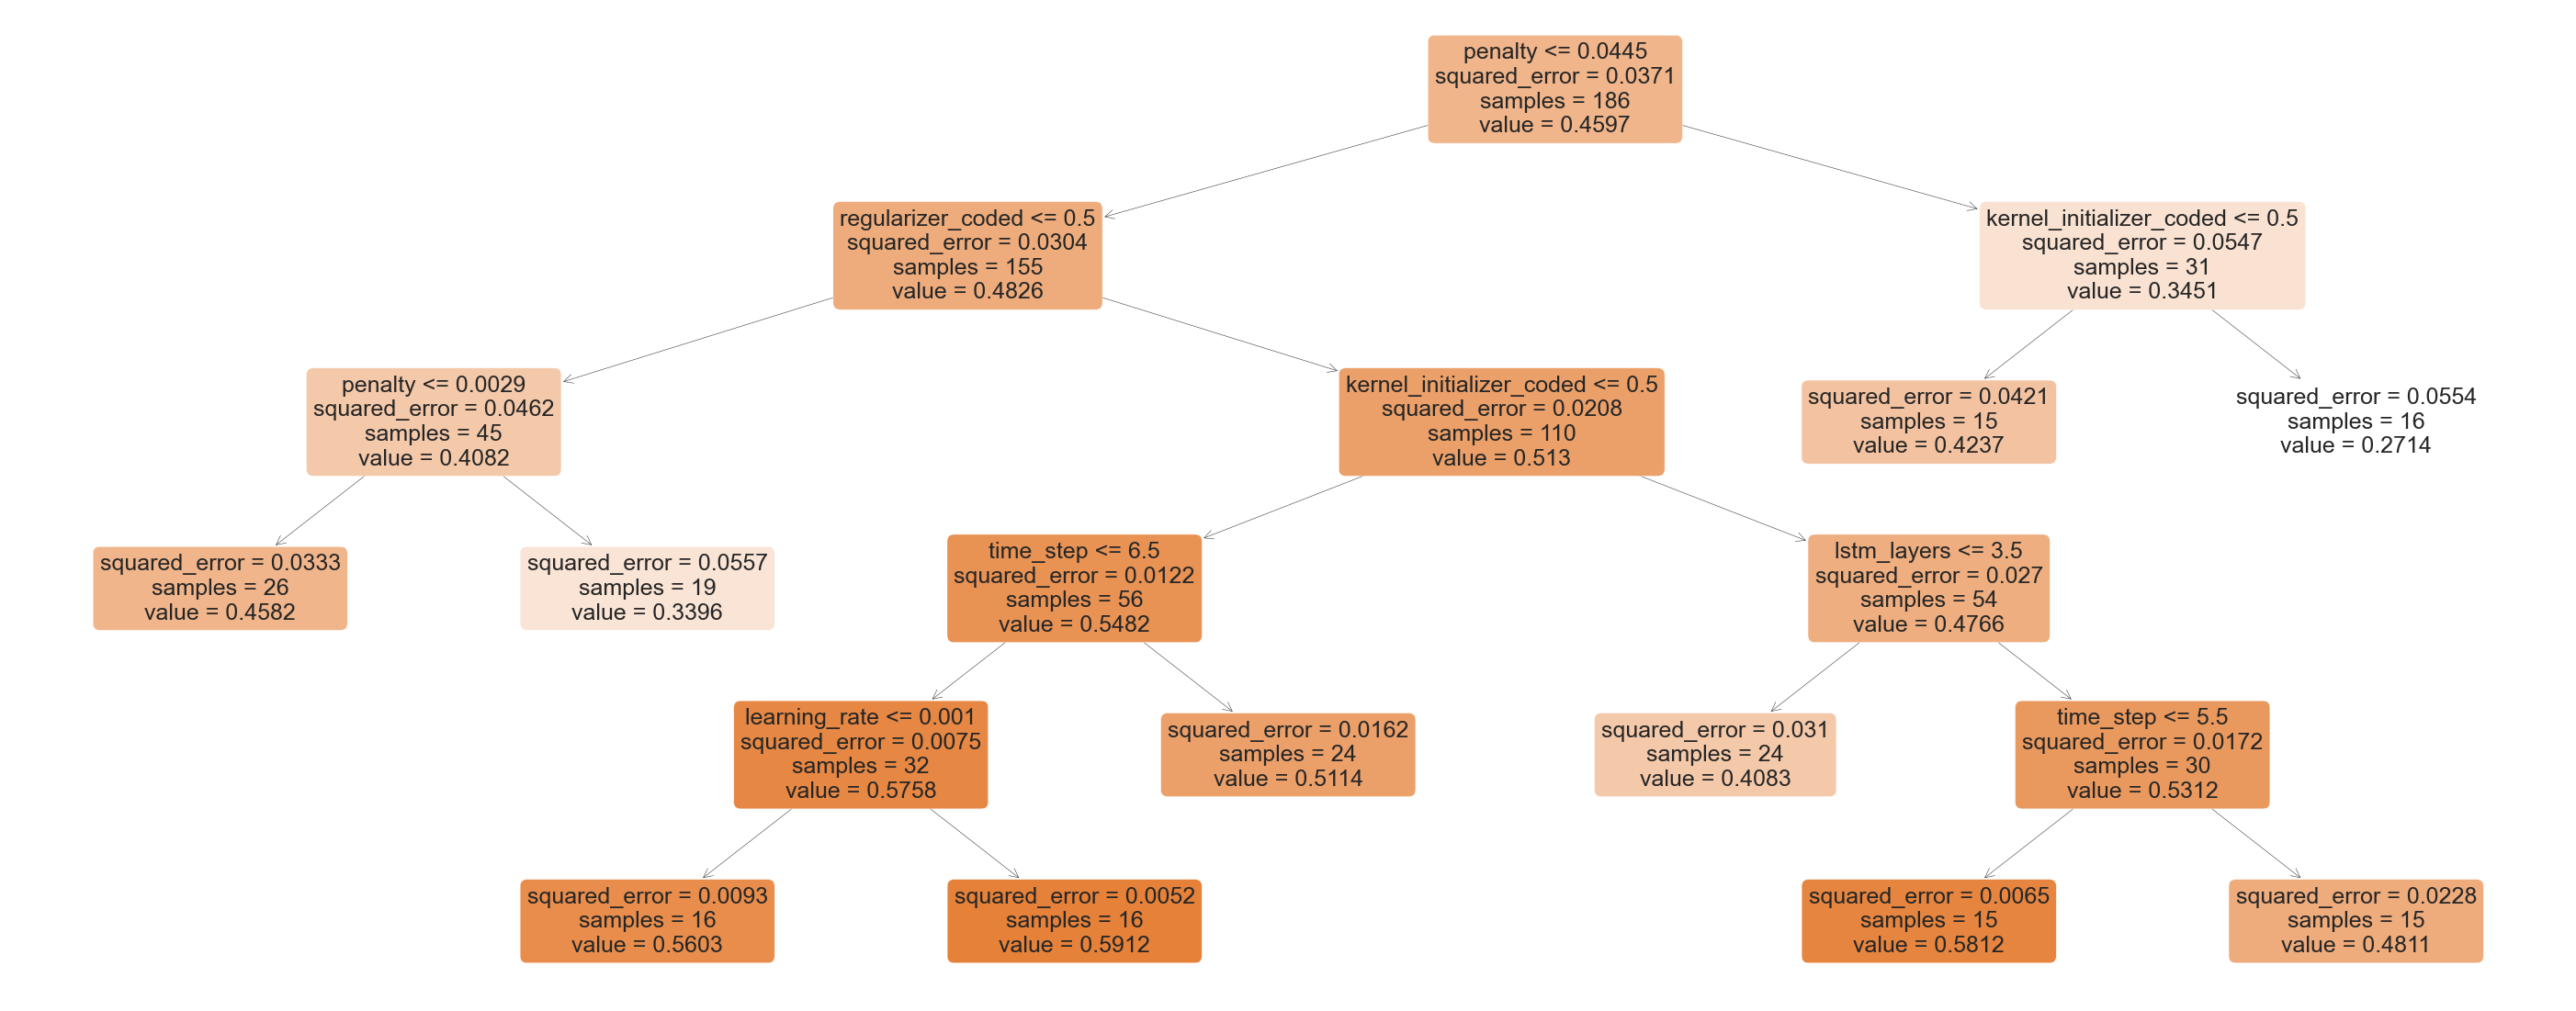

In [169]:
tree = DecisionTreeRegressor(min_samples_leaf=15)
tree.fit(hparams_1,randomsearch_results_1['val_f1_score'])
plt.figure(figsize=(50,20))
plot_tree(tree,filled=True,feature_names=list(hparams_1.columns),rounded=True,fontsize=25,proportion=False,precision=4)
plt.show()

The best results are obtained using the following settings:
1. ```Penalty <= 0.0445```
2. ```regularizer == 'l2'```
3. ```kernel_initializer == 'he_normal'```
4. ```time_step <=6```
5. ``` learning_rate >= 0.001```

The min and max values of other hyperparameters are changed according to the results below:

In [170]:
pd.concat([np.min(hparams_1,axis=0),np.max(hparams_1,axis=0)],axis=1).rename(columns={0:'Min',1:"Max"})

Min       Max
time_step                        1        10
lstm_layers                      2         5
lstm_units                      10       100
kernel_initializer_coded         0         1
regularizer_coded                0         1
penalty                   0.001002  0.096734
drop_out                     False      True
drop_out_rate_adj              0.0      0.95
learning_rate             0.000105  0.009967

#### 5.4.4 Random Search - Second Iteration

The hypermodel for the second iteration is set up below:

In [171]:
def model_tuning_2(hp):
    
    hp_time_step = hp.Int(name='time_step',min_value=2,max_value=6)
    hp_lstm_layers= hp.Int(name='LSTM_layers',min_value=2,max_value =5)
    hp_lstm_units= hp.Int(name='LSTM_units',min_value=10,max_value=100)
    hp_lstm_initializer=hp.Choice(name='lstm_initializer',values=['he_normal'])
    hp_lstm_regularizer= hp.Choice(name='lstm_regularizer',values=['l2'])
    hp_lstm_reg_penalty= hp.Float(name='lstm_reg_penalty',min_value=0.001,max_value=0.045,sampling='log') 
    hp_drop_out= hp.Boolean(name = 'dropout')
    hp_drop_out_rate= hp.Float(name='dropout_rate',min_value=0.05,max_value=1,step=0.05)
    hp_model_learning_rate= hp.Float(name='learning_rate',min_value=0.001,max_value=0.01,sampling='log')
    
    model = create_LSTM_model(time_step=hp_time_step,
                              lstm_layers=hp_lstm_layers,
                              lstm_units=hp_lstm_units,
                              lstm_initializer=hp_lstm_initializer,
                              lstm_regularizer=hp_lstm_regularizer,
                              lstm_reg_penalty=hp_lstm_reg_penalty,
                              drop_out=hp_drop_out,
                              drop_out_rate=hp_drop_out_rate,
                              model_learning_rate=hp_model_learning_rate)
    
                            
    
    return model

The second random search is executed below. 

In [172]:
max_trials = 200
directory = './Model Outputs/RandomSearch'
project_name = 'RandomSearch_2'
objective = 'val_f1_score'

tuner_2 = RandomSearch_LSTM_run(model_tuning_2,max_trials=max_trials,
                                roc_threshold=0.6,epoch_threshold=10,
                                objective = objective,max_epochs=1000,patience=100,
                      directory=directory,project_name=project_name,overwrite=False)

Reloading Tuner from ./Model Outputs/RandomSearch\RandomSearch_2\tuner0.json


#### 5.4.6 Analysing the Random Search results and choosing the best Model

In [173]:
randomsearch_results = pd.read_csv(directory+'/Tuning_results.csv')
randomsearch_results['Iteration'] = np.concatenate([['Iteration 1']*186,['Iteration 2']*89])

Text(0.5, 1.0, 'Distribution of metric by Iteration')

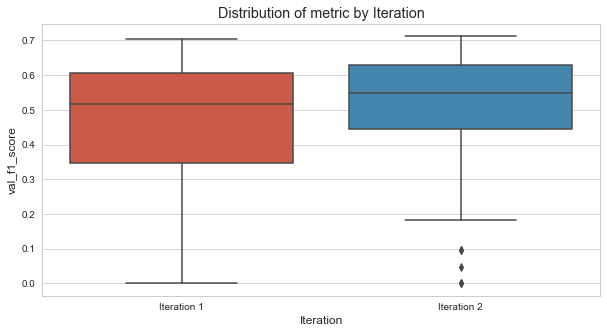

In [174]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Iteration',y='val_f1_score',data=randomsearch_results)
plt.title('Distribution of metric by Iteration')

It is clear that iteration 2 has higher f1-score on average than Iteration 1. Checking the splits to narrow down the settings for maximizing the f1 score.

In [175]:
randomsearch_results['drop_out_rate_adj'] = np.where(randomsearch_results['drop_out']==False,0,
                                                 randomsearch_results['drop_out_rate'])
randomsearch_results['kernel_initializer_coded'] = np.where(randomsearch_results['kernel_initializer']=='GlorotNormal',1,0)
randomsearch_results['regularizer_coded'] = np.where(randomsearch_results['regularizer']=='l2',1,0)

randomsearch_results_2 = randomsearch_results[randomsearch_results['Iteration']=='Iteration 2']
hparams_2 = randomsearch_results_2[hparams_1.columns]

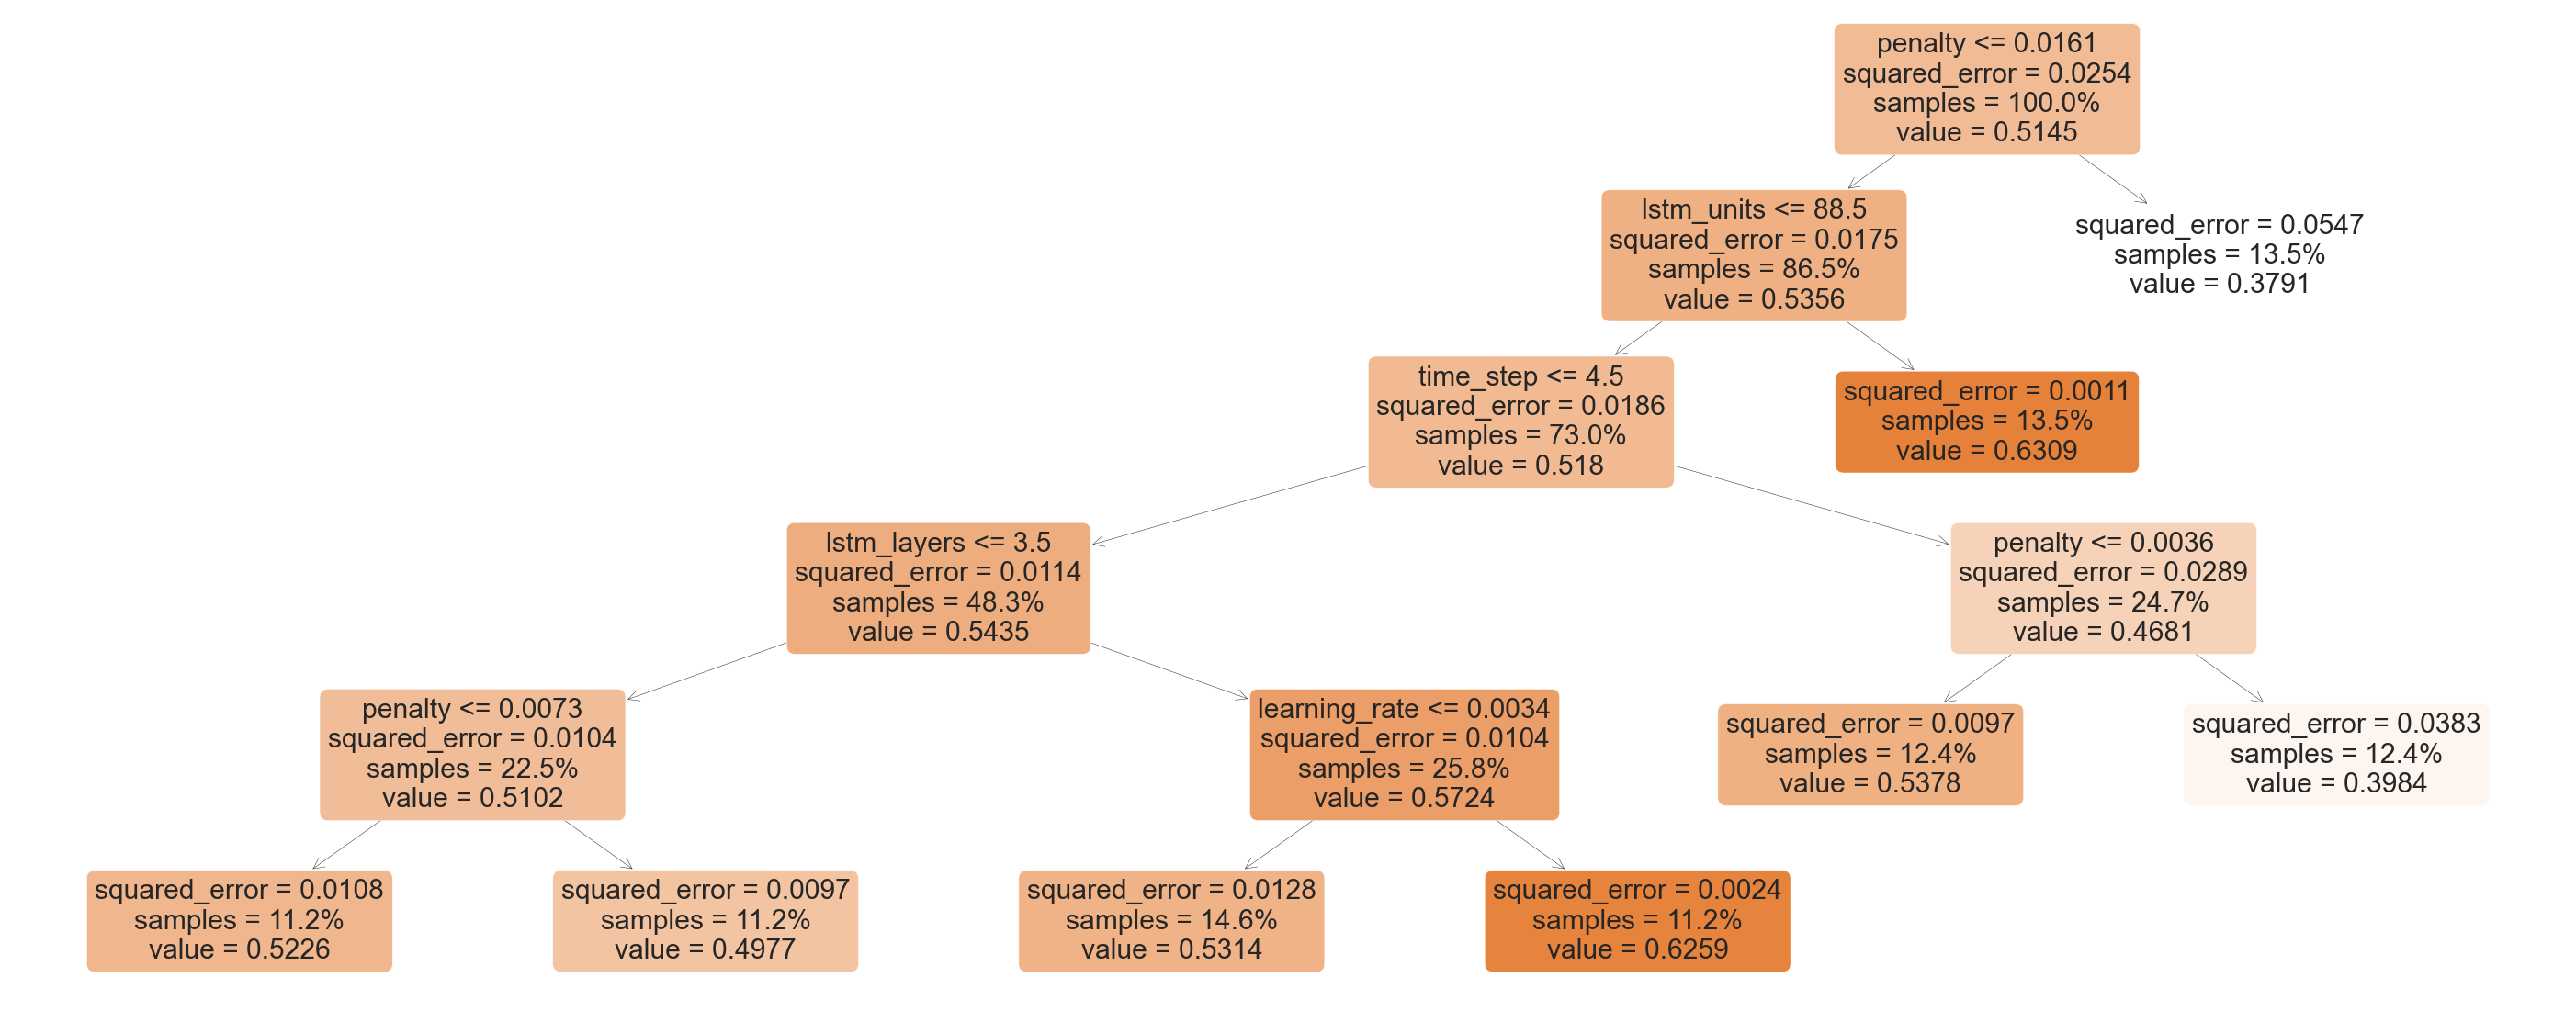

In [176]:
tree = DecisionTreeRegressor(min_samples_leaf=10)
tree.fit(hparams_2,randomsearch_results_2['val_f1_score'])
plt.figure(figsize=(50,20))
plot_tree(tree,filled=True,feature_names=list(hparams_2.columns),rounded=True,fontsize=30,proportion=True,precision=4)
plt.show()

Based on the tree, the best models are obtained using the following settings:

The best results are obtained using the following settings:
1. ```Penalty <= 0.0161```
2. ```regularizer == 'l2'```
3. ```kernel_initializer == 'he_normal'```
4. ```time_step <=6```
5. ``` learning_rate >= 0.001```
6. ``` lstm_units >= 89```

We filter out the models with the final settings and analyze the results.

In [177]:
best_settings = ((randomsearch_results['regularizer']=='l2')&
                (randomsearch_results['penalty']<=0.0161)&
                (randomsearch_results['learning_rate']>=0.001)&
                (randomsearch_results['time_step']<=6)&
                (randomsearch_results['lstm_units'] >=89)&
                (randomsearch_results['kernel_initializer']=='HeNormal'))

In [178]:
best_models = randomsearch_results[best_settings]
best_models

time_step  lstm_layers  lstm_units kernel_initializer regularizer  \
17           6            3          98           HeNormal          l2   
189          3            5          92           HeNormal          l2   
195          6            3          90           HeNormal          l2   
196          2            2          89           HeNormal          l2   
201          2            2          96           HeNormal          l2   
205          3            4          89           HeNormal          l2   
209          5            2          89           HeNormal          l2   
219          4            2          96           HeNormal          l2   
220          3            2          95           HeNormal          l2   
226          4            3          92           HeNormal          l2   
233          2            4          96           HeNormal          l2   
238          2            4          89           HeNormal          l2   
252          2            2          89           HeNormal          l2   

      penalty  drop_out  drop_out_rate  learning_rate      loss  ...  \
17   0.005293      True           0.35       0.001153  0.679483  ...   
189  0.001078      True           0.70       0.001079  1.001093  ...   
195  0.001450     False           0.00       0.004466  0.711332  ...   
196  0.003263     False           0.00       0.002146  0.178324  ...   
201  0.007026     False           0.00       0.003276  0.272282  ...   
205  0.003531     False           0.00       0.007242  0.717115  ...   
209  0.003529     False           0.00       0.001679  0.161948  ...   
219  0.005785     False           0.00       0.009963  0.527106  ...   
220  0.001389     False           0.00       0.002003  0.147279  ...   
226  0.006656     False           0.00       0.003487  0.639603  ...   
233  0.005690      True           0.15       0.001340  0.306574  ...   
238  0.002225      True           0.85       0.002532  0.716781  ...   
252  0.010087      True           0.20       0.004150  0.707282  ...   

      roc_auc  val_loss  val_binary_accuracy  val_f1_score  val_roc_auc  \
17   0.724108  0.843811             0.671053      0.603175     0.617382   
189  0.472153  0.981516             0.607595      0.651685     0.670833   
195  0.699473  0.773935             0.631579      0.674419     0.649931   
196  0.993088  2.157728             0.637500      0.623377     0.609688   
201  0.990538  1.896240             0.625000      0.583333     0.630625   
205  0.550990  0.745050             0.569620      0.673077     0.621474   
209  0.999714  1.837813             0.636364      0.575758     0.614035   
219  0.923787  1.161520             0.628205      0.602740     0.623684   
220  0.998040  2.057699             0.683544      0.647887     0.648718   
226  0.762817  0.745628             0.653846      0.640000     0.650329   
233  0.987502  1.548278             0.700000      0.666667     0.660625   
238  0.508963  0.724577             0.587500      0.629214     0.644375   
252  0.558983  0.706588             0.587500      0.602410     0.605625   

     Epoch    Iteration  drop_out_rate_adj kernel_initializer_coded  \
17      20  Iteration 1               0.35                        0   
189     44  Iteration 2               0.70                        0   
195     17  Iteration 2               0.00                        0   
196    203  Iteration 2               0.00                        0   
201    151  Iteration 2               0.00                        0   
205     53  Iteration 2               0.00                        0   
209     80  Iteration 2               0.00                        0   
219    240  Iteration 2               0.00                        0   
220    115  Iteration 2               0.00                        0   
226    118  Iteration 2               0.00                        0   
233    174  Iteration 2               0.15                        0   
238    127  Iteration 2               0.85              

We filter out models where training loss is higher than validation loss and training roc is less than valid roc.

In [179]:
best_models[(best_models['val_loss']>best_models['loss'])&(best_models['val_roc_auc']<best_models['roc_auc'])]

time_step  lstm_layers  lstm_units kernel_initializer regularizer  \
17           6            3          98           HeNormal          l2   
195          6            3          90           HeNormal          l2   
196          2            2          89           HeNormal          l2   
201          2            2          96           HeNormal          l2   
209          5            2          89           HeNormal          l2   
219          4            2          96           HeNormal          l2   
220          3            2          95           HeNormal          l2   
226          4            3          92           HeNormal          l2   
233          2            4          96           HeNormal          l2   

      penalty  drop_out  drop_out_rate  learning_rate      loss  ...  \
17   0.005293      True           0.35       0.001153  0.679483  ...   
195  0.001450     False           0.00       0.004466  0.711332  ...   
196  0.003263     False           0.00       0.002146  0.178324  ...   
201  0.007026     False           0.00       0.003276  0.272282  ...   
209  0.003529     False           0.00       0.001679  0.161948  ...   
219  0.005785     False           0.00       0.009963  0.527106  ...   
220  0.001389     False           0.00       0.002003  0.147279  ...   
226  0.006656     False           0.00       0.003487  0.639603  ...   
233  0.005690      True           0.15       0.001340  0.306574  ...   

      roc_auc  val_loss  val_binary_accuracy  val_f1_score  val_roc_auc  \
17   0.724108  0.843811             0.671053      0.603175     0.617382   
195  0.699473  0.773935             0.631579      0.674419     0.649931   
196  0.993088  2.157728             0.637500      0.623377     0.609688   
201  0.990538  1.896240             0.625000      0.583333     0.630625   
209  0.999714  1.837813             0.636364      0.575758     0.614035   
219  0.923787  1.161520             0.628205      0.602740     0.623684   
220  0.998040  2.057699             0.683544      0.647887     0.648718   
226  0.762817  0.745628             0.653846      0.640000     0.650329   
233  0.987502  1.548278             0.700000      0.666667     0.660625   

     Epoch    Iteration  drop_out_rate_adj kernel_initializer_coded  \
17      20  Iteration 1               0.35                        0   
195     17  Iteration 2               0.00                        0   
196    203  Iteration 2               0.00                        0   
201    151  Iteration 2               0.00                        0   
209     80  Iteration 2               0.00                        0   
219    240  Iteration 2               0.00                        0   
220    115  Iteration 2               0.00                        0   
226    118  Iteration 2               0.00                        0   
233    174  Iteration 2               0.15                        0   

     regularizer_coded  
17                   1  
195                  1  
196                  1  
201                  1  
209                  1  
219                  1  
220                  1  
226                  1  
233                  1  

[9 rows x 22 columns]

In [180]:
for i in range(200):
    
    trial_id = '0'*(3-len(str(i)))+str(i) if i>=40 else '0'*(2-len(str(i)))+str(i)
    trial = tuner_2.oracle.get_trial(trial_id)
    print(trial_id,'-',trial.hyperparameters.values)

00 - {'time_step': 5, 'LSTM_layers': 2, 'LSTM_units': 47, 'lstm_initializer': 'he_normal', 'lstm_regularizer': 'l2', 'lstm_reg_penalty': 0.0038165998866296394, 'dropout': True, 'dropout_rate': 0.1, 'learning_rate': 0.0031443911752710788}
01 - {'time_step': 3, 'LSTM_layers': 5, 'LSTM_units': 66, 'lstm_initializer': 'he_normal', 'lstm_regularizer': 'l2', 'lstm_reg_penalty': 0.03952480071973781, 'dropout': False, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0016756583493598323}
02 - {'time_step': 3, 'LSTM_layers': 3, 'LSTM_units': 94, 'lstm_initializer': 'he_normal', 'lstm_regularizer': 'l2', 'lstm_reg_penalty': 0.004849086928329207, 'dropout': False, 'dropout_rate': 0.1, 'learning_rate': 0.005516567488527181}
03 - {'time_step': 5, 'LSTM_layers': 5, 'LSTM_units': 39, 'lstm_initializer': 'he_normal', 'lstm_regularizer': 'l2', 'lstm_reg_penalty': 0.026382371046278108, 'dropout': False, 'dropout_rate': 0.4, 'learning_rate': 0.00629673431630925}
04 - {'time_step': 6, 'LSTM_layers': 

The model we choose as the best is the model at index 233. The model is chosen because in addition to high roc auc, it has also has high accuaracy and f1 score both in train and validation data. 

In [181]:
lstm_best_trial = tuner_2.oracle.get_trial('131') # trial id is 131 for the model at index 233
lstm_best_hyperparameters = lstm_best_trial.hyperparameters.values
lstm_best_model = tuner_2.hypermodel.build(lstm_best_trial.hyperparameters)

In [182]:
lstm_best_hyperparameters

{'time_step': 2,
 'LSTM_layers': 4,
 'LSTM_units': 96,
 'lstm_initializer': 'he_normal',
 'lstm_regularizer': 'l2',
 'lstm_reg_penalty': 0.005690415177200833,
 'dropout': True,
 'dropout_rate': 0.15000000000000002,
 'learning_rate': 0.001340334781419485}

#### 5.4.7 Training the best model

In [183]:
train_data = time_step_generation(X=train_features_imp,y=train_Y,time_step=2)
valid_data = time_step_generation(X=valid_features_imp,y=valid_Y,time_step=2)

In [675]:
history = model_run(lstm_best_model,train_data=train_data,valid_data=valid_data,
                    check_point_file_path='./Model Outputs/LSTM_best_model_3',
                    metric='val_f1_score',epochs=1000,early_stopping=False)

Epoch 1/1000
47/47 [==============================] - 1s 15ms/step - loss: 8.8864 - binary_accuracy: 0.4102 - f1_score: 0.5113 - roc_auc: 0.4682
47/47 - 13s - loss: 13.1124 - binary_accuracy: 0.6213 - f1_score: 0.5478 - roc_auc: 0.6884 - val_loss: 8.8835 - val_binary_accuracy: 0.4500 - val_f1_score: 0.5926 - val_roc_auc: 0.4263 - train_loss: 8.8864 - train_binary_accuracy: 0.4102 - train_f1_score: 0.5113 - train_roc_auc: 0.4682 - lr: 0.0020 - 13s/epoch - 266ms/step
Epoch 2/1000
47/47 [==============================] - 1s 15ms/step - loss: 4.6016 - binary_accuracy: 0.5047 - f1_score: 0.4403 - roc_auc: 0.5260
47/47 - 3s - loss: 6.4849 - binary_accuracy: 0.5738 - f1_score: 0.5140 - roc_auc: 0.6153 - val_loss: 4.6087 - val_binary_accuracy: 0.4375 - val_f1_score: 0.1176 - val_roc_auc: 0.3109 - train_loss: 4.6016 - train_binary_accuracy: 0.5047 - train_f1_score: 0.4403 - train_roc_auc: 0.5260 - lr: 0.0020 - 3s/epoch - 74ms/step
Epoch 3/1000
47/47 [==============================] - 1s 15ms/st

11/11/2023 07:47:37 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 14s - loss: 0.7797 - binary_accuracy: 0.6755 - f1_score: 0.6223 - roc_auc: 0.7467 - val_loss: 0.8380 - val_binary_accuracy: 0.5875 - val_f1_score: 0.5352 - val_roc_auc: 0.6400 - train_loss: 0.8508 - train_binary_accuracy: 0.6051 - train_f1_score: 0.5286 - train_roc_auc: 0.6429 - lr: 0.0017 - 14s/epoch - 306ms/step
Epoch 13/1000
47/47 [==============================] - 1s 16ms/step - loss: 0.8373 - binary_accuracy: 0.6177 - f1_score: 0.5660 - roc_auc: 0.6779
47/47 - 3s - loss: 0.7516 - binary_accuracy: 0.6988 - f1_score: 0.6430 - roc_auc: 0.7615 - val_loss: 0.8590 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.6313 - train_loss: 0.8373 - train_binary_accuracy: 0.6177 - train_f1_score: 0.5660 - train_roc_auc: 0.6779 - lr: 0.0016 - 3s/epoch - 57ms/step
Epoch 14/1000
47/47 [==============================] - 1s 16ms/step - loss: 0.8039 - binary_accuracy: 0.6509 - f1_score: 0.5672 - roc_auc: 0.6928
47/47 - 3s - loss: 0.7318 - binary_accuracy: 0.6988 - f1_score:

Epoch 30/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.0256 - binary_accuracy: 0.6762 - f1_score: 0.5862 - roc_auc: 0.7047
47/47 - 3s - loss: 0.5914 - binary_accuracy: 0.8411 - f1_score: 0.8020 - roc_auc: 0.9130 - val_loss: 1.4562 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4516 - val_roc_auc: 0.5856 - train_loss: 1.0256 - train_binary_accuracy: 0.6762 - train_f1_score: 0.5862 - train_roc_auc: 0.7047 - lr: 0.0012 - 3s/epoch - 74ms/step
Epoch 31/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.0739 - binary_accuracy: 0.6443 - f1_score: 0.5784 - roc_auc: 0.6818
47/47 - 3s - loss: 0.6481 - binary_accuracy: 0.8178 - f1_score: 0.7776 - roc_auc: 0.8893 - val_loss: 1.0910 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4706 - val_roc_auc: 0.5825 - train_loss: 1.0739 - train_binary_accuracy: 0.6443 - train_f1_score: 0.5784 - train_roc_auc: 0.6818 - lr: 0.0018 - 3s/epoch - 74ms/step
Epoch 32/1000
47/47 [==============================] - 1s 16ms/ste

11/11/2023 07:49:27 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 14s - loss: 0.5564 - binary_accuracy: 0.8750 - f1_score: 0.8423 - roc_auc: 0.9480 - val_loss: 1.4759 - val_binary_accuracy: 0.5875 - val_f1_score: 0.5600 - val_roc_auc: 0.6028 - train_loss: 1.0422 - train_binary_accuracy: 0.6709 - train_f1_score: 0.6124 - train_roc_auc: 0.7360 - lr: 0.0015 - 14s/epoch - 300ms/step
Epoch 42/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.2230 - binary_accuracy: 0.6556 - f1_score: 0.5908 - roc_auc: 0.7096
47/47 - 3s - loss: 0.5922 - binary_accuracy: 0.8664 - f1_score: 0.8324 - roc_auc: 0.9321 - val_loss: 1.4515 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3214 - val_roc_auc: 0.5747 - train_loss: 1.2230 - train_binary_accuracy: 0.6556 - train_f1_score: 0.5908 - train_roc_auc: 0.7096 - lr: 0.0015 - 3s/epoch - 59ms/step
Epoch 43/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.2877 - binary_accuracy: 0.6715 - f1_score: 0.5951 - roc_auc: 0.7151
47/47 - 4s - loss: 0.5260 - binary_accuracy: 0.8956 - f1_score:

Epoch 59/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.2799 - binary_accuracy: 0.6915 - f1_score: 0.6264 - roc_auc: 0.7508
47/47 - 4s - loss: 0.4077 - binary_accuracy: 0.9362 - f1_score: 0.9178 - roc_auc: 0.9813 - val_loss: 1.9661 - val_binary_accuracy: 0.5500 - val_f1_score: 0.5000 - val_roc_auc: 0.5288 - train_loss: 1.2799 - train_binary_accuracy: 0.6915 - train_f1_score: 0.6264 - train_roc_auc: 0.7508 - lr: 0.0011 - 4s/epoch - 75ms/step
Epoch 60/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.0986 - binary_accuracy: 0.7094 - f1_score: 0.6275 - roc_auc: 0.7601
47/47 - 4s - loss: 0.4362 - binary_accuracy: 0.9335 - f1_score: 0.9151 - roc_auc: 0.9738 - val_loss: 1.8658 - val_binary_accuracy: 0.5000 - val_f1_score: 0.3750 - val_roc_auc: 0.5606 - train_loss: 1.0986 - train_binary_accuracy: 0.7094 - train_f1_score: 0.6275 - train_roc_auc: 0.7601 - lr: 0.0011 - 4s/epoch - 76ms/step
Epoch 61/1000
47/47 [==============================] - 1s 16ms/ste

11/11/2023 07:51:05 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 15s - loss: 0.4952 - binary_accuracy: 0.9176 - f1_score: 0.8938 - roc_auc: 0.9674 - val_loss: 1.6249 - val_binary_accuracy: 0.5750 - val_f1_score: 0.5750 - val_roc_auc: 0.5763 - train_loss: 1.0707 - train_binary_accuracy: 0.7128 - train_f1_score: 0.6282 - train_roc_auc: 0.7638 - lr: 0.0015 - 15s/epoch - 312ms/step
Epoch 67/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2245 - binary_accuracy: 0.7141 - f1_score: 0.6174 - roc_auc: 0.7612
47/47 - 3s - loss: 0.4505 - binary_accuracy: 0.9309 - f1_score: 0.9105 - roc_auc: 0.9803 - val_loss: 2.3949 - val_binary_accuracy: 0.4750 - val_f1_score: 0.1600 - val_roc_auc: 0.5144 - train_loss: 1.2245 - train_binary_accuracy: 0.7141 - train_f1_score: 0.6174 - train_roc_auc: 0.7612 - lr: 0.0015 - 3s/epoch - 58ms/step
Epoch 68/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.1412 - binary_accuracy: 0.7201 - f1_score: 0.6197 - roc_auc: 0.7677
47/47 - 4s - loss: 0.5138 - binary_accuracy: 0.9029 - f1_score:

Epoch 84/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2436 - binary_accuracy: 0.7114 - f1_score: 0.6159 - roc_auc: 0.7620
47/47 - 4s - loss: 0.3522 - binary_accuracy: 0.9541 - f1_score: 0.9407 - roc_auc: 0.9891 - val_loss: 2.2029 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3929 - val_roc_auc: 0.6166 - train_loss: 1.2436 - train_binary_accuracy: 0.7114 - train_f1_score: 0.6159 - train_roc_auc: 0.7620 - lr: 0.0011 - 4s/epoch - 77ms/step
Epoch 85/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2031 - binary_accuracy: 0.7141 - f1_score: 0.6318 - roc_auc: 0.7737
47/47 - 4s - loss: 0.3461 - binary_accuracy: 0.9521 - f1_score: 0.9380 - roc_auc: 0.9912 - val_loss: 1.8561 - val_binary_accuracy: 0.6125 - val_f1_score: 0.5231 - val_roc_auc: 0.6381 - train_loss: 1.2031 - train_binary_accuracy: 0.7141 - train_f1_score: 0.6318 - train_roc_auc: 0.7737 - lr: 0.0011 - 4s/epoch - 77ms/step
Epoch 86/1000
47/47 [==============================] - 1s 17ms/ste

11/11/2023 07:52:32 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 18s - loss: 0.3716 - binary_accuracy: 0.9495 - f1_score: 0.9346 - roc_auc: 0.9853 - val_loss: 1.5879 - val_binary_accuracy: 0.6250 - val_f1_score: 0.5833 - val_roc_auc: 0.6144 - train_loss: 1.1705 - train_binary_accuracy: 0.6995 - train_f1_score: 0.6361 - train_roc_auc: 0.7716 - lr: 0.0010 - 18s/epoch - 383ms/step
Epoch 87/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.3556 - binary_accuracy: 0.7035 - f1_score: 0.6195 - roc_auc: 0.7512
47/47 - 3s - loss: 0.3408 - binary_accuracy: 0.9535 - f1_score: 0.9394 - roc_auc: 0.9911 - val_loss: 1.8351 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4545 - val_roc_auc: 0.6038 - train_loss: 1.3556 - train_binary_accuracy: 0.7035 - train_f1_score: 0.6195 - train_roc_auc: 0.7512 - lr: 0.0010 - 3s/epoch - 64ms/step
Epoch 88/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.1684 - binary_accuracy: 0.7088 - f1_score: 0.6237 - roc_auc: 0.7651
47/47 - 4s - loss: 0.3568 - binary_accuracy: 0.9495 - f1_score:

Epoch 104/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2197 - binary_accuracy: 0.7194 - f1_score: 0.6171 - roc_auc: 0.7622
47/47 - 4s - loss: 0.3640 - binary_accuracy: 0.9528 - f1_score: 0.9390 - roc_auc: 0.9865 - val_loss: 1.5325 - val_binary_accuracy: 0.6250 - val_f1_score: 0.5161 - val_roc_auc: 0.6503 - train_loss: 1.2197 - train_binary_accuracy: 0.7194 - train_f1_score: 0.6171 - train_roc_auc: 0.7622 - lr: 0.0012 - 4s/epoch - 81ms/step
Epoch 105/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.4313 - binary_accuracy: 0.7094 - f1_score: 0.5889 - roc_auc: 0.7354
47/47 - 4s - loss: 0.3255 - binary_accuracy: 0.9568 - f1_score: 0.9443 - roc_auc: 0.9933 - val_loss: 2.3040 - val_binary_accuracy: 0.5750 - val_f1_score: 0.3704 - val_roc_auc: 0.6700 - train_loss: 1.4313 - train_binary_accuracy: 0.7094 - train_f1_score: 0.5889 - train_roc_auc: 0.7354 - lr: 0.0011 - 4s/epoch - 81ms/step
Epoch 106/1000
47/47 [==============================] - 1s 17ms/

Epoch 122/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.1660 - binary_accuracy: 0.7168 - f1_score: 0.6468 - roc_auc: 0.7658
47/47 - 4s - loss: 0.3528 - binary_accuracy: 0.9455 - f1_score: 0.9292 - roc_auc: 0.9861 - val_loss: 2.1403 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3509 - val_roc_auc: 0.5969 - train_loss: 1.1660 - train_binary_accuracy: 0.7168 - train_f1_score: 0.6468 - train_roc_auc: 0.7658 - lr: 0.0013 - 4s/epoch - 81ms/step
Epoch 123/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2191 - binary_accuracy: 0.7188 - f1_score: 0.6280 - roc_auc: 0.7634
47/47 - 4s - loss: 0.3350 - binary_accuracy: 0.9515 - f1_score: 0.9378 - roc_auc: 0.9892 - val_loss: 1.9874 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4138 - val_roc_auc: 0.5987 - train_loss: 1.2191 - train_binary_accuracy: 0.7188 - train_f1_score: 0.6280 - train_roc_auc: 0.7634 - lr: 0.0013 - 4s/epoch - 81ms/step
Epoch 124/1000
47/47 [==============================] - 1s 17ms/

Epoch 140/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.2547 - binary_accuracy: 0.7194 - f1_score: 0.6272 - roc_auc: 0.7658
47/47 - 4s - loss: 0.2766 - binary_accuracy: 0.9727 - f1_score: 0.9646 - roc_auc: 0.9938 - val_loss: 2.1142 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4590 - val_roc_auc: 0.5894 - train_loss: 1.2547 - train_binary_accuracy: 0.7194 - train_f1_score: 0.6272 - train_roc_auc: 0.7658 - lr: 9.4390e-04 - 4s/epoch - 80ms/step
Epoch 141/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2461 - binary_accuracy: 0.7387 - f1_score: 0.6580 - roc_auc: 0.7852
47/47 - 4s - loss: 0.2807 - binary_accuracy: 0.9654 - f1_score: 0.9552 - roc_auc: 0.9942 - val_loss: 1.9337 - val_binary_accuracy: 0.5750 - val_f1_score: 0.5000 - val_roc_auc: 0.5847 - train_loss: 1.2461 - train_binary_accuracy: 0.7387 - train_f1_score: 0.6580 - train_roc_auc: 0.7852 - lr: 9.2742e-04 - 4s/epoch - 80ms/step
Epoch 142/1000
47/47 [==============================] - 

11/11/2023 07:56:30 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 15s - loss: 0.2759 - binary_accuracy: 0.9654 - f1_score: 0.9550 - roc_auc: 0.9948 - val_loss: 2.4859 - val_binary_accuracy: 0.5750 - val_f1_score: 0.5854 - val_roc_auc: 0.5453 - train_loss: 1.3241 - train_binary_accuracy: 0.7161 - train_f1_score: 0.6559 - train_roc_auc: 0.7822 - lr: 8.4923e-04 - 15s/epoch - 312ms/step
Epoch 147/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2183 - binary_accuracy: 0.7487 - f1_score: 0.6741 - roc_auc: 0.7893
47/47 - 3s - loss: 0.2634 - binary_accuracy: 0.9714 - f1_score: 0.9628 - roc_auc: 0.9947 - val_loss: 1.9932 - val_binary_accuracy: 0.5625 - val_f1_score: 0.5455 - val_roc_auc: 0.5709 - train_loss: 1.2183 - train_binary_accuracy: 0.7487 - train_f1_score: 0.6741 - train_roc_auc: 0.7893 - lr: 8.3440e-04 - 3s/epoch - 64ms/step
Epoch 148/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.1980 - binary_accuracy: 0.7360 - f1_score: 0.6627 - roc_auc: 0.7847
47/47 - 4s - loss: 0.2616 - binary_accuracy: 0.9727 -

11/11/2023 07:57:41 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 15s - loss: 0.2643 - binary_accuracy: 0.9761 - f1_score: 0.9689 - roc_auc: 0.9968 - val_loss: 2.3294 - val_binary_accuracy: 0.6000 - val_f1_score: 0.5897 - val_roc_auc: 0.5881 - train_loss: 1.3436 - train_binary_accuracy: 0.7134 - train_f1_score: 0.6319 - train_roc_auc: 0.7657 - lr: 9.7806e-04 - 15s/epoch - 310ms/step
Epoch 163/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.3094 - binary_accuracy: 0.7088 - f1_score: 0.6224 - roc_auc: 0.7588
47/47 - 3s - loss: 0.2789 - binary_accuracy: 0.9694 - f1_score: 0.9605 - roc_auc: 0.9949 - val_loss: 2.2084 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4706 - val_roc_auc: 0.5619 - train_loss: 1.3094 - train_binary_accuracy: 0.7088 - train_f1_score: 0.6224 - train_roc_auc: 0.7588 - lr: 9.6099e-04 - 3s/epoch - 59ms/step
Epoch 164/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.3725 - binary_accuracy: 0.7234 - f1_score: 0.6319 - roc_auc: 0.7693
47/47 - 4s - loss: 0.2761 - binary_accuracy: 0.9628 -

Epoch 180/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.4061 - binary_accuracy: 0.7380 - f1_score: 0.6379 - roc_auc: 0.7769
47/47 - 4s - loss: 0.2122 - binary_accuracy: 0.9827 - f1_score: 0.9775 - roc_auc: 0.9982 - val_loss: 2.8812 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3667 - val_roc_auc: 0.5391 - train_loss: 1.4061 - train_binary_accuracy: 0.7380 - train_f1_score: 0.6379 - train_roc_auc: 0.7769 - lr: 7.1231e-04 - 4s/epoch - 79ms/step
Epoch 181/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2594 - binary_accuracy: 0.7247 - f1_score: 0.6503 - roc_auc: 0.7773
47/47 - 4s - loss: 0.2767 - binary_accuracy: 0.9541 - f1_score: 0.9408 - roc_auc: 0.9921 - val_loss: 2.2252 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4194 - val_roc_auc: 0.5556 - train_loss: 1.2594 - train_binary_accuracy: 0.7247 - train_f1_score: 0.6503 - train_roc_auc: 0.7773 - lr: 0.0011 - 4s/epoch - 79ms/step
Epoch 182/1000
47/47 [==============================] - 1s 1

Epoch 198/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.3193 - binary_accuracy: 0.7547 - f1_score: 0.6586 - roc_auc: 0.7860
47/47 - 4s - loss: 0.2385 - binary_accuracy: 0.9781 - f1_score: 0.9715 - roc_auc: 0.9957 - val_loss: 2.5359 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5531 - train_loss: 1.3193 - train_binary_accuracy: 0.7547 - train_f1_score: 0.6586 - train_roc_auc: 0.7860 - lr: 7.9197e-04 - 4s/epoch - 78ms/step
Epoch 199/1000
47/47 [==============================] - 1s 16ms/step - loss: 1.1867 - binary_accuracy: 0.7480 - f1_score: 0.6408 - roc_auc: 0.7823
47/47 - 4s - loss: 0.2530 - binary_accuracy: 0.9681 - f1_score: 0.9587 - roc_auc: 0.9938 - val_loss: 2.0263 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3571 - val_roc_auc: 0.5800 - train_loss: 1.1867 - train_binary_accuracy: 0.7480 - train_f1_score: 0.6408 - train_roc_auc: 0.7823 - lr: 7.7814e-04 - 4s/epoch - 76ms/step
Epoch 200/1000
47/47 [==============================] - 

Epoch 216/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.1785 - binary_accuracy: 0.7493 - f1_score: 0.6594 - roc_auc: 0.7936
47/47 - 4s - loss: 0.2426 - binary_accuracy: 0.9707 - f1_score: 0.9622 - roc_auc: 0.9963 - val_loss: 2.1376 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4789 - val_roc_auc: 0.5691 - train_loss: 1.1785 - train_binary_accuracy: 0.7493 - train_f1_score: 0.6594 - train_roc_auc: 0.7936 - lr: 8.8055e-04 - 4s/epoch - 80ms/step
Epoch 217/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2403 - binary_accuracy: 0.7520 - f1_score: 0.6649 - roc_auc: 0.7924
47/47 - 4s - loss: 0.2376 - binary_accuracy: 0.9747 - f1_score: 0.9668 - roc_auc: 0.9952 - val_loss: 2.0820 - val_binary_accuracy: 0.5750 - val_f1_score: 0.5526 - val_roc_auc: 0.5838 - train_loss: 1.2403 - train_binary_accuracy: 0.7520 - train_f1_score: 0.6649 - train_roc_auc: 0.7924 - lr: 8.6517e-04 - 4s/epoch - 79ms/step
Epoch 218/1000
47/47 [==============================] - 

Epoch 234/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.5505 - binary_accuracy: 0.7434 - f1_score: 0.6303 - roc_auc: 0.7625
47/47 - 4s - loss: 0.1981 - binary_accuracy: 0.9794 - f1_score: 0.9733 - roc_auc: 0.9979 - val_loss: 3.1157 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3077 - val_roc_auc: 0.5956 - train_loss: 1.5505 - train_binary_accuracy: 0.7434 - train_f1_score: 0.6303 - train_roc_auc: 0.7625 - lr: 6.4129e-04 - 4s/epoch - 79ms/step
Epoch 235/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.3402 - binary_accuracy: 0.7394 - f1_score: 0.6519 - roc_auc: 0.7767
47/47 - 4s - loss: 0.2115 - binary_accuracy: 0.9721 - f1_score: 0.9637 - roc_auc: 0.9969 - val_loss: 2.2991 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4932 - val_roc_auc: 0.5853 - train_loss: 1.3402 - train_binary_accuracy: 0.7394 - train_f1_score: 0.6519 - train_roc_auc: 0.7767 - lr: 6.3009e-04 - 4s/epoch - 80ms/step
Epoch 236/1000
47/47 [==============================] - 

Epoch 252/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.1944 - binary_accuracy: 0.7141 - f1_score: 0.6344 - roc_auc: 0.7682
47/47 - 4s - loss: 0.2282 - binary_accuracy: 0.9727 - f1_score: 0.9643 - roc_auc: 0.9941 - val_loss: 2.1858 - val_binary_accuracy: 0.4875 - val_f1_score: 0.4058 - val_roc_auc: 0.5209 - train_loss: 1.1944 - train_binary_accuracy: 0.7141 - train_f1_score: 0.6344 - train_roc_auc: 0.7682 - lr: 7.1301e-04 - 4s/epoch - 79ms/step
Epoch 253/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.4044 - binary_accuracy: 0.7414 - f1_score: 0.6567 - roc_auc: 0.7727
47/47 - 4s - loss: 0.2039 - binary_accuracy: 0.9767 - f1_score: 0.9699 - roc_auc: 0.9979 - val_loss: 2.6930 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4478 - val_roc_auc: 0.5450 - train_loss: 1.4044 - train_binary_accuracy: 0.7414 - train_f1_score: 0.6567 - train_roc_auc: 0.7727 - lr: 7.0056e-04 - 4s/epoch - 79ms/step
Epoch 254/1000
47/47 [==============================] - 

Epoch 270/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2252 - binary_accuracy: 0.7547 - f1_score: 0.6636 - roc_auc: 0.7850
47/47 - 4s - loss: 0.1864 - binary_accuracy: 0.9807 - f1_score: 0.9748 - roc_auc: 0.9981 - val_loss: 2.5921 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3158 - val_roc_auc: 0.5525 - train_loss: 1.2252 - train_binary_accuracy: 0.7547 - train_f1_score: 0.6636 - train_roc_auc: 0.7850 - lr: 5.1927e-04 - 4s/epoch - 80ms/step
Epoch 271/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.3279 - binary_accuracy: 0.7447 - f1_score: 0.6672 - roc_auc: 0.7809
47/47 - 4s - loss: 0.1905 - binary_accuracy: 0.9794 - f1_score: 0.9730 - roc_auc: 0.9958 - val_loss: 2.9405 - val_binary_accuracy: 0.5250 - val_f1_score: 0.4242 - val_roc_auc: 0.5066 - train_loss: 1.3279 - train_binary_accuracy: 0.7447 - train_f1_score: 0.6672 - train_roc_auc: 0.7809 - lr: 7.7891e-04 - 4s/epoch - 81ms/step
Epoch 272/1000
47/47 [==============================] - 

Epoch 288/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.1035 - binary_accuracy: 0.7726 - f1_score: 0.6868 - roc_auc: 0.8037
47/47 - 4s - loss: 0.2013 - binary_accuracy: 0.9754 - f1_score: 0.9679 - roc_auc: 0.9964 - val_loss: 2.6834 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5491 - train_loss: 1.1035 - train_binary_accuracy: 0.7726 - train_f1_score: 0.6868 - train_roc_auc: 0.8037 - lr: 5.7735e-04 - 4s/epoch - 79ms/step
Epoch 289/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.2668 - binary_accuracy: 0.7487 - f1_score: 0.6741 - roc_auc: 0.7877
47/47 - 4s - loss: 0.1825 - binary_accuracy: 0.9814 - f1_score: 0.9757 - roc_auc: 0.9969 - val_loss: 2.7325 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4928 - val_roc_auc: 0.5572 - train_loss: 1.2668 - train_binary_accuracy: 0.7487 - train_f1_score: 0.6741 - train_roc_auc: 0.7877 - lr: 5.6727e-04 - 4s/epoch - 79ms/step
Epoch 290/1000
47/47 [==============================] - 

Epoch 306/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.4168 - binary_accuracy: 0.7387 - f1_score: 0.6627 - roc_auc: 0.7783
47/47 - 4s - loss: 0.1819 - binary_accuracy: 0.9781 - f1_score: 0.9714 - roc_auc: 0.9977 - val_loss: 2.7320 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3667 - val_roc_auc: 0.5706 - train_loss: 1.4168 - train_binary_accuracy: 0.7387 - train_f1_score: 0.6627 - train_roc_auc: 0.7783 - lr: 6.4192e-04 - 4s/epoch - 80ms/step
Epoch 307/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.3530 - binary_accuracy: 0.7374 - f1_score: 0.6621 - roc_auc: 0.7853
47/47 - 4s - loss: 0.1824 - binary_accuracy: 0.9814 - f1_score: 0.9757 - roc_auc: 0.9978 - val_loss: 2.4585 - val_binary_accuracy: 0.6000 - val_f1_score: 0.4839 - val_roc_auc: 0.5991 - train_loss: 1.3530 - train_binary_accuracy: 0.7374 - train_f1_score: 0.6621 - train_roc_auc: 0.7853 - lr: 6.3071e-04 - 4s/epoch - 81ms/step
Epoch 308/1000
47/47 [==============================] - 

Epoch 324/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.1542 - binary_accuracy: 0.7653 - f1_score: 0.6884 - roc_auc: 0.8057
47/47 - 4s - loss: 0.1677 - binary_accuracy: 0.9820 - f1_score: 0.9766 - roc_auc: 0.9981 - val_loss: 2.4924 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5822 - train_loss: 1.1542 - train_binary_accuracy: 0.7653 - train_f1_score: 0.6884 - train_roc_auc: 0.8057 - lr: 4.6750e-04 - 4s/epoch - 80ms/step
Epoch 325/1000
47/47 [==============================] - 1s 17ms/step - loss: 1.4431 - binary_accuracy: 0.7507 - f1_score: 0.6792 - roc_auc: 0.7824
47/47 - 4s - loss: 0.1557 - binary_accuracy: 0.9880 - f1_score: 0.9843 - roc_auc: 0.9984 - val_loss: 2.8041 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4068 - val_roc_auc: 0.5337 - train_loss: 1.4431 - train_binary_accuracy: 0.7507 - train_f1_score: 0.6792 - train_roc_auc: 0.7824 - lr: 4.5934e-04 - 4s/epoch - 80ms/step
Epoch 326/1000
47/47 [==============================] - 

Epoch 342/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.3997 - binary_accuracy: 0.7400 - f1_score: 0.6717 - roc_auc: 0.7911
47/47 - 4s - loss: 0.1613 - binary_accuracy: 0.9840 - f1_score: 0.9792 - roc_auc: 0.9977 - val_loss: 2.4013 - val_binary_accuracy: 0.5875 - val_f1_score: 0.5479 - val_roc_auc: 0.5812 - train_loss: 1.3997 - train_binary_accuracy: 0.7400 - train_f1_score: 0.6717 - train_roc_auc: 0.7911 - lr: 5.1978e-04 - 4s/epoch - 81ms/step
Epoch 343/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.2537 - binary_accuracy: 0.7467 - f1_score: 0.6796 - roc_auc: 0.7896
47/47 - 4s - loss: 0.1744 - binary_accuracy: 0.9774 - f1_score: 0.9706 - roc_auc: 0.9977 - val_loss: 2.1427 - val_binary_accuracy: 0.5500 - val_f1_score: 0.5000 - val_roc_auc: 0.5531 - train_loss: 1.2537 - train_binary_accuracy: 0.7467 - train_f1_score: 0.6796 - train_roc_auc: 0.7896 - lr: 5.1071e-04 - 4s/epoch - 81ms/step
Epoch 344/1000
47/47 [==============================] - 

Epoch 360/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.4214 - binary_accuracy: 0.7513 - f1_score: 0.6736 - roc_auc: 0.7848
47/47 - 4s - loss: 0.1380 - binary_accuracy: 0.9887 - f1_score: 0.9852 - roc_auc: 0.9994 - val_loss: 2.9733 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4688 - val_roc_auc: 0.5800 - train_loss: 1.4214 - train_binary_accuracy: 0.7513 - train_f1_score: 0.6736 - train_roc_auc: 0.7848 - lr: 3.7855e-04 - 4s/epoch - 81ms/step
Epoch 361/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.3061 - binary_accuracy: 0.7739 - f1_score: 0.6937 - roc_auc: 0.8066
47/47 - 4s - loss: 0.1404 - binary_accuracy: 0.9834 - f1_score: 0.9785 - roc_auc: 0.9993 - val_loss: 2.8381 - val_binary_accuracy: 0.6000 - val_f1_score: 0.5000 - val_roc_auc: 0.5772 - train_loss: 1.3061 - train_binary_accuracy: 0.7739 - train_f1_score: 0.6937 - train_roc_auc: 0.8066 - lr: 5.6783e-04 - 4s/epoch - 81ms/step
Epoch 362/1000
47/47 [==============================] - 

Epoch 378/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.2697 - binary_accuracy: 0.7487 - f1_score: 0.6690 - roc_auc: 0.8002
47/47 - 4s - loss: 0.1519 - binary_accuracy: 0.9894 - f1_score: 0.9861 - roc_auc: 0.9981 - val_loss: 2.7346 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3390 - val_roc_auc: 0.5656 - train_loss: 1.2697 - train_binary_accuracy: 0.7487 - train_f1_score: 0.6690 - train_roc_auc: 0.8002 - lr: 4.2089e-04 - 4s/epoch - 81ms/step
Epoch 379/1000
47/47 [==============================] - 1s 18ms/step - loss: 1.4012 - binary_accuracy: 0.7427 - f1_score: 0.6602 - roc_auc: 0.7885
47/47 - 4s - loss: 0.1442 - binary_accuracy: 0.9860 - f1_score: 0.9818 - roc_auc: 0.9987 - val_loss: 2.6759 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4688 - val_roc_auc: 0.5350 - train_loss: 1.4012 - train_binary_accuracy: 0.7427 - train_f1_score: 0.6602 - train_roc_auc: 0.7885 - lr: 4.1354e-04 - 4s/epoch - 81ms/step
Epoch 380/1000
47/47 [==============================] - 

Epoch 396/1000
47/47 [==============================] - 1s 11ms/step - loss: 1.1201 - binary_accuracy: 0.7699 - f1_score: 0.6997 - roc_auc: 0.8126
47/47 - 2s - loss: 0.1568 - binary_accuracy: 0.9801 - f1_score: 0.9740 - roc_auc: 0.9962 - val_loss: 2.1182 - val_binary_accuracy: 0.5875 - val_f1_score: 0.5479 - val_roc_auc: 0.5878 - train_loss: 1.1201 - train_binary_accuracy: 0.7699 - train_f1_score: 0.6997 - train_roc_auc: 0.8126 - lr: 4.6796e-04 - 2s/epoch - 45ms/step
Epoch 397/1000
47/47 [==============================] - 0s 10ms/step - loss: 1.1611 - binary_accuracy: 0.7573 - f1_score: 0.6915 - roc_auc: 0.8045


11/11/2023 08:12:08 AM - Assets written to: ./Model Outputs\LSTM_best_model_3\assets


47/47 - 11s - loss: 0.1586 - binary_accuracy: 0.9807 - f1_score: 0.9748 - roc_auc: 0.9980 - val_loss: 2.1823 - val_binary_accuracy: 0.6125 - val_f1_score: 0.5974 - val_roc_auc: 0.5984 - train_loss: 1.1611 - train_binary_accuracy: 0.7573 - train_f1_score: 0.6915 - train_roc_auc: 0.8045 - lr: 4.5979e-04 - 11s/epoch - 243ms/step
Epoch 398/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.2868 - binary_accuracy: 0.7553 - f1_score: 0.6732 - roc_auc: 0.7970
47/47 - 2s - loss: 0.1572 - binary_accuracy: 0.9814 - f1_score: 0.9759 - roc_auc: 0.9972 - val_loss: 2.6978 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.5622 - train_loss: 1.2868 - train_binary_accuracy: 0.7553 - train_f1_score: 0.6732 - train_roc_auc: 0.7970 - lr: 4.5176e-04 - 2s/epoch - 41ms/step
Epoch 399/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.2814 - binary_accuracy: 0.7533 - f1_score: 0.6726 - roc_auc: 0.7944
47/47 - 2s - loss: 0.1501 - binary_accuracy: 0.9867 - f

Epoch 415/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.6006 - binary_accuracy: 0.7580 - f1_score: 0.6715 - roc_auc: 0.7801
47/47 - 2s - loss: 0.1129 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9999 - val_loss: 2.9912 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3667 - val_roc_auc: 0.5888 - train_loss: 1.6006 - train_binary_accuracy: 0.7580 - train_f1_score: 0.6715 - train_roc_auc: 0.7801 - lr: 3.3486e-04 - 2s/epoch - 39ms/step
Epoch 416/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.2435 - binary_accuracy: 0.7673 - f1_score: 0.6789 - roc_auc: 0.8040
47/47 - 2s - loss: 0.1476 - binary_accuracy: 0.9820 - f1_score: 0.9767 - roc_auc: 0.9972 - val_loss: 2.4580 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4516 - val_roc_auc: 0.5891 - train_loss: 1.2435 - train_binary_accuracy: 0.7673 - train_f1_score: 0.6789 - train_roc_auc: 0.8040 - lr: 3.2901e-04 - 2s/epoch - 38ms/step
Epoch 417/1000
47/47 [==============================] - 0s

Epoch 433/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.0284 - binary_accuracy: 0.7906 - f1_score: 0.7123 - roc_auc: 0.8304
47/47 - 2s - loss: 0.1415 - binary_accuracy: 0.9820 - f1_score: 0.9767 - roc_auc: 0.9988 - val_loss: 2.5232 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3871 - val_roc_auc: 0.6100 - train_loss: 1.0284 - train_binary_accuracy: 0.7906 - train_f1_score: 0.7123 - train_roc_auc: 0.8304 - lr: 3.7231e-04 - 2s/epoch - 38ms/step
Epoch 434/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.2501 - binary_accuracy: 0.7686 - f1_score: 0.7010 - roc_auc: 0.8138
47/47 - 2s - loss: 0.1277 - binary_accuracy: 0.9907 - f1_score: 0.9878 - roc_auc: 0.9994 - val_loss: 2.7346 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3607 - val_roc_auc: 0.6281 - train_loss: 1.2501 - train_binary_accuracy: 0.7686 - train_f1_score: 0.7010 - train_roc_auc: 0.8138 - lr: 3.6581e-04 - 2s/epoch - 38ms/step
Epoch 435/1000
47/47 [==============================] - 0s

Epoch 451/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.2932 - binary_accuracy: 0.7793 - f1_score: 0.7052 - roc_auc: 0.8064
47/47 - 2s - loss: 0.1187 - binary_accuracy: 0.9894 - f1_score: 0.9861 - roc_auc: 0.9993 - val_loss: 2.6281 - val_binary_accuracy: 0.6125 - val_f1_score: 0.5753 - val_roc_auc: 0.6297 - train_loss: 1.2932 - train_binary_accuracy: 0.7793 - train_f1_score: 0.7052 - train_roc_auc: 0.8064 - lr: 4.1394e-04 - 2s/epoch - 39ms/step
Epoch 452/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.0940 - binary_accuracy: 0.7819 - f1_score: 0.7013 - roc_auc: 0.8134
47/47 - 2s - loss: 0.1300 - binary_accuracy: 0.9847 - f1_score: 0.9801 - roc_auc: 0.9981 - val_loss: 2.3424 - val_binary_accuracy: 0.6000 - val_f1_score: 0.5429 - val_roc_auc: 0.6322 - train_loss: 1.0940 - train_binary_accuracy: 0.7819 - train_f1_score: 0.7013 - train_roc_auc: 0.8134 - lr: 4.0672e-04 - 2s/epoch - 39ms/step
Epoch 453/1000
47/47 [==============================] - 0s

Epoch 469/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3992 - binary_accuracy: 0.7580 - f1_score: 0.6715 - roc_auc: 0.7959
47/47 - 2s - loss: 0.1204 - binary_accuracy: 0.9887 - f1_score: 0.9852 - roc_auc: 0.9989 - val_loss: 3.4431 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.5644 - train_loss: 1.3992 - train_binary_accuracy: 0.7580 - train_f1_score: 0.6715 - train_roc_auc: 0.7959 - lr: 3.0147e-04 - 2s/epoch - 40ms/step
Epoch 470/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.5381 - binary_accuracy: 0.7527 - f1_score: 0.6637 - roc_auc: 0.7819
47/47 - 2s - loss: 0.1165 - binary_accuracy: 0.9900 - f1_score: 0.9869 - roc_auc: 0.9995 - val_loss: 3.6507 - val_binary_accuracy: 0.5000 - val_f1_score: 0.3939 - val_roc_auc: 0.5706 - train_loss: 1.5381 - train_binary_accuracy: 0.7527 - train_f1_score: 0.6637 - train_roc_auc: 0.7819 - lr: 2.9621e-04 - 2s/epoch - 40ms/step
Epoch 471/1000
47/47 [==============================] - 0s

Epoch 487/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5407 - binary_accuracy: 0.7626 - f1_score: 0.6930 - roc_auc: 0.7928
47/47 - 2s - loss: 0.1193 - binary_accuracy: 0.9880 - f1_score: 0.9843 - roc_auc: 0.9993 - val_loss: 2.9566 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4928 - val_roc_auc: 0.5541 - train_loss: 1.5407 - train_binary_accuracy: 0.7626 - train_f1_score: 0.6930 - train_roc_auc: 0.7928 - lr: 3.3519e-04 - 2s/epoch - 42ms/step
Epoch 488/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.3866 - binary_accuracy: 0.7693 - f1_score: 0.7027 - roc_auc: 0.8068
47/47 - 2s - loss: 0.1196 - binary_accuracy: 0.9894 - f1_score: 0.9861 - roc_auc: 0.9989 - val_loss: 3.0263 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4776 - val_roc_auc: 0.5444 - train_loss: 1.3866 - train_binary_accuracy: 0.7693 - train_f1_score: 0.7027 - train_roc_auc: 0.8068 - lr: 3.2933e-04 - 2s/epoch - 40ms/step
Epoch 489/1000
47/47 [==============================] - 0s

Epoch 505/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.2862 - binary_accuracy: 0.7839 - f1_score: 0.7142 - roc_auc: 0.8130
47/47 - 2s - loss: 0.1000 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9998 - val_loss: 2.8856 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4615 - val_roc_auc: 0.5941 - train_loss: 1.2862 - train_binary_accuracy: 0.7839 - train_f1_score: 0.7142 - train_roc_auc: 0.8130 - lr: 2.4411e-04 - 2s/epoch - 40ms/step
Epoch 506/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.2876 - binary_accuracy: 0.7726 - f1_score: 0.6924 - roc_auc: 0.8092
47/47 - 2s - loss: 0.1214 - binary_accuracy: 0.9874 - f1_score: 0.9835 - roc_auc: 0.9981 - val_loss: 3.1183 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3571 - val_roc_auc: 0.5922 - train_loss: 1.2876 - train_binary_accuracy: 0.7726 - train_f1_score: 0.6924 - train_roc_auc: 0.8092 - lr: 2.3985e-04 - 2s/epoch - 40ms/step
Epoch 507/1000
47/47 [==============================] - 0s

Epoch 523/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4268 - binary_accuracy: 0.7620 - f1_score: 0.6914 - roc_auc: 0.7988
47/47 - 2s - loss: 0.1160 - binary_accuracy: 0.9880 - f1_score: 0.9844 - roc_auc: 0.9984 - val_loss: 2.8545 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4194 - val_roc_auc: 0.5856 - train_loss: 1.4268 - train_binary_accuracy: 0.7620 - train_f1_score: 0.6914 - train_roc_auc: 0.7988 - lr: 2.7141e-04 - 2s/epoch - 39ms/step
Epoch 524/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.3862 - binary_accuracy: 0.7573 - f1_score: 0.6773 - roc_auc: 0.8020
47/47 - 2s - loss: 0.1121 - binary_accuracy: 0.9874 - f1_score: 0.9835 - roc_auc: 0.9994 - val_loss: 3.2203 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3607 - val_roc_auc: 0.5469 - train_loss: 1.3862 - train_binary_accuracy: 0.7573 - train_f1_score: 0.6773 - train_roc_auc: 0.8020 - lr: 2.6667e-04 - 2s/epoch - 40ms/step
Epoch 525/1000
47/47 [==============================] - 0s

Epoch 541/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4689 - binary_accuracy: 0.7846 - f1_score: 0.7076 - roc_auc: 0.8075
47/47 - 2s - loss: 0.0915 - binary_accuracy: 0.9947 - f1_score: 0.9930 - roc_auc: 0.9999 - val_loss: 3.2945 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3729 - val_roc_auc: 0.5859 - train_loss: 1.4689 - train_binary_accuracy: 0.7846 - train_f1_score: 0.7076 - train_roc_auc: 0.8075 - lr: 3.0177e-04 - 2s/epoch - 40ms/step
Epoch 542/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4686 - binary_accuracy: 0.7653 - f1_score: 0.6906 - roc_auc: 0.8017
47/47 - 2s - loss: 0.0993 - binary_accuracy: 0.9927 - f1_score: 0.9904 - roc_auc: 0.9996 - val_loss: 3.5032 - val_binary_accuracy: 0.5250 - val_f1_score: 0.3448 - val_roc_auc: 0.5469 - train_loss: 1.4686 - train_binary_accuracy: 0.7653 - train_f1_score: 0.6906 - train_roc_auc: 0.8017 - lr: 2.9650e-04 - 2s/epoch - 40ms/step
Epoch 543/1000
47/47 [==============================] - 0s

Epoch 559/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.2541 - binary_accuracy: 0.7739 - f1_score: 0.6926 - roc_auc: 0.8104
47/47 - 2s - loss: 0.1063 - binary_accuracy: 0.9887 - f1_score: 0.9853 - roc_auc: 0.9992 - val_loss: 3.0895 - val_binary_accuracy: 0.5125 - val_f1_score: 0.3390 - val_roc_auc: 0.5825 - train_loss: 1.2541 - train_binary_accuracy: 0.7739 - train_f1_score: 0.6926 - train_roc_auc: 0.8104 - lr: 2.1977e-04 - 2s/epoch - 40ms/step
Epoch 560/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.2811 - binary_accuracy: 0.7872 - f1_score: 0.7203 - roc_auc: 0.8214
47/47 - 2s - loss: 0.0872 - binary_accuracy: 0.9973 - f1_score: 0.9965 - roc_auc: 0.9998 - val_loss: 3.3980 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3934 - val_roc_auc: 0.5656 - train_loss: 1.2811 - train_binary_accuracy: 0.7872 - train_f1_score: 0.7203 - train_roc_auc: 0.8214 - lr: 2.1593e-04 - 2s/epoch - 39ms/step
Epoch 561/1000
47/47 [==============================] - 0s

Epoch 577/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5374 - binary_accuracy: 0.7547 - f1_score: 0.6567 - roc_auc: 0.7801
47/47 - 2s - loss: 0.1021 - binary_accuracy: 0.9900 - f1_score: 0.9870 - roc_auc: 0.9995 - val_loss: 3.6820 - val_binary_accuracy: 0.5375 - val_f1_score: 0.2745 - val_roc_auc: 0.5803 - train_loss: 1.5374 - train_binary_accuracy: 0.7547 - train_f1_score: 0.6567 - train_roc_auc: 0.7801 - lr: 2.4435e-04 - 2s/epoch - 40ms/step
Epoch 578/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.3446 - binary_accuracy: 0.7633 - f1_score: 0.6698 - roc_auc: 0.8002
47/47 - 2s - loss: 0.1091 - binary_accuracy: 0.9894 - f1_score: 0.9861 - roc_auc: 0.9974 - val_loss: 3.2786 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4000 - val_roc_auc: 0.5766 - train_loss: 1.3446 - train_binary_accuracy: 0.7633 - train_f1_score: 0.6698 - train_roc_auc: 0.8002 - lr: 2.4008e-04 - 2s/epoch - 39ms/step
Epoch 579/1000
47/47 [==============================] - 0s

Epoch 595/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3052 - binary_accuracy: 0.7806 - f1_score: 0.6887 - roc_auc: 0.8128
47/47 - 2s - loss: 0.0974 - binary_accuracy: 0.9874 - f1_score: 0.9836 - roc_auc: 0.9991 - val_loss: 3.3024 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5606 - train_loss: 1.3052 - train_binary_accuracy: 0.7806 - train_f1_score: 0.6887 - train_roc_auc: 0.8128 - lr: 1.7796e-04 - 2s/epoch - 41ms/step
Epoch 596/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3898 - binary_accuracy: 0.7826 - f1_score: 0.6935 - roc_auc: 0.8055
47/47 - 2s - loss: 0.0898 - binary_accuracy: 0.9914 - f1_score: 0.9887 - roc_auc: 0.9997 - val_loss: 3.3976 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5703 - train_loss: 1.3898 - train_binary_accuracy: 0.7826 - train_f1_score: 0.6935 - train_roc_auc: 0.8055 - lr: 1.7485e-04 - 2s/epoch - 40ms/step
Epoch 597/1000
47/47 [==============================] - 0s

Epoch 613/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4153 - binary_accuracy: 0.7852 - f1_score: 0.7012 - roc_auc: 0.8072
47/47 - 2s - loss: 0.0860 - binary_accuracy: 0.9920 - f1_score: 0.9896 - roc_auc: 0.9998 - val_loss: 3.3904 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4000 - val_roc_auc: 0.5497 - train_loss: 1.4153 - train_binary_accuracy: 0.7852 - train_f1_score: 0.7012 - train_roc_auc: 0.8072 - lr: 1.9786e-04 - 2s/epoch - 41ms/step
Epoch 614/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4346 - binary_accuracy: 0.7826 - f1_score: 0.6906 - roc_auc: 0.8065
47/47 - 2s - loss: 0.0883 - binary_accuracy: 0.9927 - f1_score: 0.9905 - roc_auc: 0.9992 - val_loss: 3.5967 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3860 - val_roc_auc: 0.5441 - train_loss: 1.4346 - train_binary_accuracy: 0.7826 - train_f1_score: 0.6906 - train_roc_auc: 0.8065 - lr: 1.9440e-04 - 2s/epoch - 42ms/step
Epoch 615/1000
47/47 [==============================] - 0s

Epoch 631/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.2376 - binary_accuracy: 0.7859 - f1_score: 0.7140 - roc_auc: 0.8297
47/47 - 2s - loss: 0.0884 - binary_accuracy: 0.9927 - f1_score: 0.9904 - roc_auc: 0.9995 - val_loss: 3.0618 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4762 - val_roc_auc: 0.5594 - train_loss: 1.2376 - train_binary_accuracy: 0.7859 - train_f1_score: 0.7140 - train_roc_auc: 0.8297 - lr: 2.1999e-04 - 2s/epoch - 42ms/step
Epoch 632/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3864 - binary_accuracy: 0.7746 - f1_score: 0.7024 - roc_auc: 0.8106
47/47 - 2s - loss: 0.0911 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9990 - val_loss: 3.2463 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4194 - val_roc_auc: 0.5844 - train_loss: 1.3864 - train_binary_accuracy: 0.7746 - train_f1_score: 0.7024 - train_roc_auc: 0.8106 - lr: 2.1615e-04 - 2s/epoch - 42ms/step
Epoch 633/1000
47/47 [==============================] - 0s

Epoch 649/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3415 - binary_accuracy: 0.7806 - f1_score: 0.7085 - roc_auc: 0.8142
47/47 - 2s - loss: 0.0817 - binary_accuracy: 0.9914 - f1_score: 0.9887 - roc_auc: 0.9998 - val_loss: 3.2544 - val_binary_accuracy: 0.5750 - val_f1_score: 0.5000 - val_roc_auc: 0.5581 - train_loss: 1.3415 - train_binary_accuracy: 0.7806 - train_f1_score: 0.7085 - train_roc_auc: 0.8142 - lr: 1.6021e-04 - 2s/epoch - 42ms/step
Epoch 650/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3386 - binary_accuracy: 0.7759 - f1_score: 0.6994 - roc_auc: 0.8144
47/47 - 2s - loss: 0.0876 - binary_accuracy: 0.9920 - f1_score: 0.9896 - roc_auc: 0.9997 - val_loss: 3.1331 - val_binary_accuracy: 0.5875 - val_f1_score: 0.5075 - val_roc_auc: 0.5600 - train_loss: 1.3386 - train_binary_accuracy: 0.7759 - train_f1_score: 0.6994 - train_roc_auc: 0.8144 - lr: 1.5742e-04 - 2s/epoch - 41ms/step
Epoch 651/1000
47/47 [==============================] - 0s

Epoch 667/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.7709 - binary_accuracy: 0.7600 - f1_score: 0.6797 - roc_auc: 0.7793
47/47 - 2s - loss: 0.0733 - binary_accuracy: 0.9953 - f1_score: 0.9939 - roc_auc: 1.0000 - val_loss: 3.7286 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4516 - val_roc_auc: 0.5587 - train_loss: 1.7709 - train_binary_accuracy: 0.7600 - train_f1_score: 0.6797 - train_roc_auc: 0.7793 - lr: 1.7813e-04 - 2s/epoch - 41ms/step
Epoch 668/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.7886 - binary_accuracy: 0.7580 - f1_score: 0.6846 - roc_auc: 0.7869
47/47 - 2s - loss: 0.0743 - binary_accuracy: 0.9960 - f1_score: 0.9948 - roc_auc: 0.9999 - val_loss: 3.8792 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4762 - val_roc_auc: 0.5613 - train_loss: 1.7886 - train_binary_accuracy: 0.7580 - train_f1_score: 0.6846 - train_roc_auc: 0.7869 - lr: 1.7502e-04 - 2s/epoch - 41ms/step
Epoch 669/1000
47/47 [==============================] - 0s

Epoch 685/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4028 - binary_accuracy: 0.7533 - f1_score: 0.6782 - roc_auc: 0.7982
47/47 - 2s - loss: 0.0914 - binary_accuracy: 0.9867 - f1_score: 0.9827 - roc_auc: 0.9990 - val_loss: 3.0160 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4615 - val_roc_auc: 0.5666 - train_loss: 1.4028 - train_binary_accuracy: 0.7533 - train_f1_score: 0.6782 - train_roc_auc: 0.7982 - lr: 1.2973e-04 - 2s/epoch - 41ms/step
Epoch 686/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5205 - binary_accuracy: 0.7600 - f1_score: 0.6757 - roc_auc: 0.7907
47/47 - 2s - loss: 0.0785 - binary_accuracy: 0.9920 - f1_score: 0.9896 - roc_auc: 0.9999 - val_loss: 3.3964 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3934 - val_roc_auc: 0.5563 - train_loss: 1.5205 - train_binary_accuracy: 0.7600 - train_f1_score: 0.6757 - train_roc_auc: 0.7907 - lr: 1.2747e-04 - 2s/epoch - 41ms/step
Epoch 687/1000
47/47 [==============================] - 0s

Epoch 703/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.4782 - binary_accuracy: 0.7819 - f1_score: 0.7002 - roc_auc: 0.8012
47/47 - 2s - loss: 0.0776 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.5792 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4375 - val_roc_auc: 0.5778 - train_loss: 1.4782 - train_binary_accuracy: 0.7819 - train_f1_score: 0.7002 - train_roc_auc: 0.8012 - lr: 1.4424e-04 - 2s/epoch - 41ms/step
Epoch 704/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5240 - binary_accuracy: 0.7793 - f1_score: 0.7004 - roc_auc: 0.7999
47/47 - 2s - loss: 0.0820 - binary_accuracy: 0.9920 - f1_score: 0.9895 - roc_auc: 0.9997 - val_loss: 3.4887 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.5600 - train_loss: 1.5240 - train_binary_accuracy: 0.7793 - train_f1_score: 0.7004 - train_roc_auc: 0.7999 - lr: 1.4172e-04 - 2s/epoch - 43ms/step
Epoch 705/1000
47/47 [==============================] - 0s

Epoch 721/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4438 - binary_accuracy: 0.7812 - f1_score: 0.6990 - roc_auc: 0.8043
47/47 - 2s - loss: 0.0753 - binary_accuracy: 0.9953 - f1_score: 0.9939 - roc_auc: 0.9998 - val_loss: 3.3997 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3860 - val_roc_auc: 0.5653 - train_loss: 1.4438 - train_binary_accuracy: 0.7812 - train_f1_score: 0.6990 - train_roc_auc: 0.8043 - lr: 1.6037e-04 - 2s/epoch - 48ms/step
Epoch 722/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4541 - binary_accuracy: 0.7739 - f1_score: 0.6875 - roc_auc: 0.7982
47/47 - 2s - loss: 0.0867 - binary_accuracy: 0.9880 - f1_score: 0.9843 - roc_auc: 0.9987 - val_loss: 3.1693 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3571 - val_roc_auc: 0.5703 - train_loss: 1.4541 - train_binary_accuracy: 0.7739 - train_f1_score: 0.6875 - train_roc_auc: 0.7982 - lr: 1.5757e-04 - 2s/epoch - 41ms/step
Epoch 723/1000
47/47 [==============================] - 0s

Epoch 739/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.3414 - binary_accuracy: 0.7799 - f1_score: 0.6921 - roc_auc: 0.8084
47/47 - 2s - loss: 0.0832 - binary_accuracy: 0.9914 - f1_score: 0.9887 - roc_auc: 0.9987 - val_loss: 3.1722 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.5666 - train_loss: 1.3414 - train_binary_accuracy: 0.7799 - train_f1_score: 0.6921 - train_roc_auc: 0.8084 - lr: 1.1680e-04 - 2s/epoch - 43ms/step
Epoch 740/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4230 - binary_accuracy: 0.7773 - f1_score: 0.6788 - roc_auc: 0.7974
47/47 - 2s - loss: 0.0783 - binary_accuracy: 0.9927 - f1_score: 0.9905 - roc_auc: 0.9991 - val_loss: 3.1667 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5725 - train_loss: 1.4230 - train_binary_accuracy: 0.7773 - train_f1_score: 0.6788 - train_roc_auc: 0.7974 - lr: 1.1476e-04 - 2s/epoch - 42ms/step
Epoch 741/1000
47/47 [==============================] - 0s

Epoch 757/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5055 - binary_accuracy: 0.7746 - f1_score: 0.6960 - roc_auc: 0.8018
47/47 - 2s - loss: 0.0751 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9997 - val_loss: 3.2179 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5981 - train_loss: 1.5055 - train_binary_accuracy: 0.7746 - train_f1_score: 0.6960 - train_roc_auc: 0.8018 - lr: 1.2986e-04 - 2s/epoch - 41ms/step
Epoch 758/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.4833 - binary_accuracy: 0.7699 - f1_score: 0.6883 - roc_auc: 0.8016
47/47 - 2s - loss: 0.0760 - binary_accuracy: 0.9914 - f1_score: 0.9887 - roc_auc: 0.9998 - val_loss: 3.2385 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4333 - val_roc_auc: 0.6137 - train_loss: 1.4833 - train_binary_accuracy: 0.7699 - train_f1_score: 0.6883 - train_roc_auc: 0.8016 - lr: 1.2759e-04 - 2s/epoch - 41ms/step
Epoch 759/1000
47/47 [==============================] - 0s

Epoch 775/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5494 - binary_accuracy: 0.7699 - f1_score: 0.6922 - roc_auc: 0.7981
47/47 - 2s - loss: 0.0646 - binary_accuracy: 0.9960 - f1_score: 0.9948 - roc_auc: 1.0000 - val_loss: 3.5241 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5853 - train_loss: 1.5494 - train_binary_accuracy: 0.7699 - train_f1_score: 0.6922 - train_roc_auc: 0.7981 - lr: 9.4573e-05 - 2s/epoch - 42ms/step
Epoch 776/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.4397 - binary_accuracy: 0.7799 - f1_score: 0.7063 - roc_auc: 0.8112
47/47 - 2s - loss: 0.0776 - binary_accuracy: 0.9907 - f1_score: 0.9878 - roc_auc: 0.9997 - val_loss: 3.2865 - val_binary_accuracy: 0.5250 - val_f1_score: 0.4242 - val_roc_auc: 0.5819 - train_loss: 1.4397 - train_binary_accuracy: 0.7799 - train_f1_score: 0.7063 - train_roc_auc: 0.8112 - lr: 9.2922e-05 - 2s/epoch - 41ms/step
Epoch 777/1000
47/47 [==============================] - 0s

Epoch 793/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4805 - binary_accuracy: 0.7779 - f1_score: 0.6953 - roc_auc: 0.8091
47/47 - 2s - loss: 0.0677 - binary_accuracy: 0.9960 - f1_score: 0.9948 - roc_auc: 0.9993 - val_loss: 3.5894 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4762 - val_roc_auc: 0.5606 - train_loss: 1.4805 - train_binary_accuracy: 0.7779 - train_f1_score: 0.6953 - train_roc_auc: 0.8091 - lr: 1.0515e-04 - 2s/epoch - 42ms/step
Epoch 794/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5223 - binary_accuracy: 0.7766 - f1_score: 0.6973 - roc_auc: 0.8026
47/47 - 2s - loss: 0.0731 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9997 - val_loss: 3.6184 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4068 - val_roc_auc: 0.5591 - train_loss: 1.5223 - train_binary_accuracy: 0.7766 - train_f1_score: 0.6973 - train_roc_auc: 0.8026 - lr: 1.0331e-04 - 2s/epoch - 44ms/step
Epoch 795/1000
47/47 [==============================] - 0s

Epoch 811/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4925 - binary_accuracy: 0.7779 - f1_score: 0.7002 - roc_auc: 0.8092
47/47 - 2s - loss: 0.0648 - binary_accuracy: 0.9947 - f1_score: 0.9931 - roc_auc: 0.9999 - val_loss: 3.4848 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5581 - train_loss: 1.4925 - train_binary_accuracy: 0.7779 - train_f1_score: 0.7002 - train_roc_auc: 0.8092 - lr: 1.1691e-04 - 2s/epoch - 41ms/step
Epoch 812/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.5367 - binary_accuracy: 0.7832 - f1_score: 0.7074 - roc_auc: 0.8051
47/47 - 2s - loss: 0.0671 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.5914 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4308 - val_roc_auc: 0.5762 - train_loss: 1.5367 - train_binary_accuracy: 0.7832 - train_f1_score: 0.7074 - train_roc_auc: 0.8051 - lr: 1.1487e-04 - 2s/epoch - 41ms/step
Epoch 813/1000
47/47 [==============================] - 1s

Epoch 829/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.5888 - binary_accuracy: 0.7726 - f1_score: 0.6913 - roc_auc: 0.7944
47/47 - 2s - loss: 0.0686 - binary_accuracy: 0.9907 - f1_score: 0.9879 - roc_auc: 0.9998 - val_loss: 3.4145 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4194 - val_roc_auc: 0.5894 - train_loss: 1.5888 - train_binary_accuracy: 0.7726 - train_f1_score: 0.6913 - train_roc_auc: 0.7944 - lr: 8.5144e-05 - 2s/epoch - 41ms/step
Epoch 830/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.5453 - binary_accuracy: 0.7739 - f1_score: 0.6970 - roc_auc: 0.7988
47/47 - 2s - loss: 0.0719 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9989 - val_loss: 3.3947 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4194 - val_roc_auc: 0.5928 - train_loss: 1.5453 - train_binary_accuracy: 0.7739 - train_f1_score: 0.6970 - train_roc_auc: 0.7988 - lr: 8.3657e-05 - 2s/epoch - 41ms/step
Epoch 831/1000
47/47 [==============================] - 0s

Epoch 847/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5051 - binary_accuracy: 0.7793 - f1_score: 0.6914 - roc_auc: 0.8012
47/47 - 2s - loss: 0.0687 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.4549 - val_binary_accuracy: 0.5875 - val_f1_score: 0.4590 - val_roc_auc: 0.5681 - train_loss: 1.5051 - train_binary_accuracy: 0.7793 - train_f1_score: 0.6914 - train_roc_auc: 0.8012 - lr: 9.4666e-05 - 2s/epoch - 41ms/step
Epoch 848/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5043 - binary_accuracy: 0.7793 - f1_score: 0.6897 - roc_auc: 0.8000
47/47 - 2s - loss: 0.0726 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9992 - val_loss: 3.5432 - val_binary_accuracy: 0.5500 - val_f1_score: 0.3793 - val_roc_auc: 0.5637 - train_loss: 1.5043 - train_binary_accuracy: 0.7793 - train_f1_score: 0.6897 - train_roc_auc: 0.8000 - lr: 9.3013e-05 - 2s/epoch - 41ms/step
Epoch 849/1000
47/47 [==============================] - 0s

Epoch 865/1000
47/47 [==============================] - 0s 10ms/step - loss: 1.6857 - binary_accuracy: 0.7706 - f1_score: 0.6785 - roc_auc: 0.7958
47/47 - 2s - loss: 0.0607 - binary_accuracy: 0.9947 - f1_score: 0.9931 - roc_auc: 0.9999 - val_loss: 4.0821 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3934 - val_roc_auc: 0.5525 - train_loss: 1.6857 - train_binary_accuracy: 0.7706 - train_f1_score: 0.6785 - train_roc_auc: 0.7958 - lr: 6.8944e-05 - 2s/epoch - 48ms/step
Epoch 866/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.6668 - binary_accuracy: 0.7739 - f1_score: 0.6828 - roc_auc: 0.7971
47/47 - 2s - loss: 0.0640 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9999 - val_loss: 4.0799 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3934 - val_roc_auc: 0.5384 - train_loss: 1.6668 - train_binary_accuracy: 0.7739 - train_f1_score: 0.6828 - train_roc_auc: 0.7971 - lr: 6.7740e-05 - 2s/epoch - 43ms/step
Epoch 867/1000
47/47 [==============================] - 1

Epoch 883/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.4940 - binary_accuracy: 0.7806 - f1_score: 0.6967 - roc_auc: 0.8085
47/47 - 2s - loss: 0.0653 - binary_accuracy: 0.9947 - f1_score: 0.9930 - roc_auc: 0.9998 - val_loss: 3.7487 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5291 - train_loss: 1.4940 - train_binary_accuracy: 0.7806 - train_f1_score: 0.6967 - train_roc_auc: 0.8085 - lr: 7.6655e-05 - 2s/epoch - 43ms/step
Epoch 884/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5312 - binary_accuracy: 0.7793 - f1_score: 0.6937 - roc_auc: 0.8000
47/47 - 2s - loss: 0.0673 - binary_accuracy: 0.9953 - f1_score: 0.9939 - roc_auc: 0.9989 - val_loss: 3.6896 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3729 - val_roc_auc: 0.5559 - train_loss: 1.5312 - train_binary_accuracy: 0.7793 - train_f1_score: 0.6937 - train_roc_auc: 0.8000 - lr: 7.5316e-05 - 2s/epoch - 43ms/step
Epoch 885/1000
47/47 [==============================] - 0s

Epoch 901/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5824 - binary_accuracy: 0.7892 - f1_score: 0.7089 - roc_auc: 0.8065
47/47 - 2s - loss: 0.0643 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9998 - val_loss: 3.9640 - val_binary_accuracy: 0.5375 - val_f1_score: 0.3729 - val_roc_auc: 0.5531 - train_loss: 1.5824 - train_binary_accuracy: 0.7892 - train_f1_score: 0.7089 - train_roc_auc: 0.8065 - lr: 8.5228e-05 - 2s/epoch - 44ms/step
Epoch 902/1000
47/47 [==============================] - 0s 10ms/step - loss: 1.5819 - binary_accuracy: 0.7866 - f1_score: 0.7036 - roc_auc: 0.8004
47/47 - 2s - loss: 0.0641 - binary_accuracy: 0.9947 - f1_score: 0.9931 - roc_auc: 0.9998 - val_loss: 3.8490 - val_binary_accuracy: 0.5625 - val_f1_score: 0.3860 - val_roc_auc: 0.5559 - train_loss: 1.5819 - train_binary_accuracy: 0.7866 - train_f1_score: 0.7036 - train_roc_auc: 0.8004 - lr: 8.3739e-05 - 2s/epoch - 44ms/step
Epoch 903/1000
47/47 [==============================] - 0

Epoch 919/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.6246 - binary_accuracy: 0.7759 - f1_score: 0.6945 - roc_auc: 0.8027
47/47 - 2s - loss: 0.0621 - binary_accuracy: 0.9947 - f1_score: 0.9930 - roc_auc: 0.9999 - val_loss: 3.9061 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4068 - val_roc_auc: 0.5631 - train_loss: 1.6246 - train_binary_accuracy: 0.7759 - train_f1_score: 0.6945 - train_roc_auc: 0.8027 - lr: 6.2070e-05 - 2s/epoch - 43ms/step
Epoch 920/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5723 - binary_accuracy: 0.7826 - f1_score: 0.7067 - roc_auc: 0.8073
47/47 - 2s - loss: 0.0673 - binary_accuracy: 0.9920 - f1_score: 0.9895 - roc_auc: 0.9998 - val_loss: 3.8767 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5731 - train_loss: 1.5723 - train_binary_accuracy: 0.7826 - train_f1_score: 0.7067 - train_roc_auc: 0.8073 - lr: 6.0986e-05 - 2s/epoch - 42ms/step
Epoch 921/1000
47/47 [==============================] - 0s

Epoch 937/1000
47/47 [==============================] - 0s 8ms/step - loss: 1.5644 - binary_accuracy: 0.7753 - f1_score: 0.7009 - roc_auc: 0.8111
47/47 - 2s - loss: 0.0679 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9989 - val_loss: 3.6517 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4068 - val_roc_auc: 0.5334 - train_loss: 1.5644 - train_binary_accuracy: 0.7753 - train_f1_score: 0.7009 - train_roc_auc: 0.8111 - lr: 6.9012e-05 - 2s/epoch - 41ms/step
Epoch 938/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.5298 - binary_accuracy: 0.7866 - f1_score: 0.7100 - roc_auc: 0.8109
47/47 - 2s - loss: 0.0633 - binary_accuracy: 0.9920 - f1_score: 0.9896 - roc_auc: 0.9993 - val_loss: 3.6288 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4068 - val_roc_auc: 0.5231 - train_loss: 1.5298 - train_binary_accuracy: 0.7866 - train_f1_score: 0.7100 - train_roc_auc: 0.8109 - lr: 6.7807e-05 - 2s/epoch - 41ms/step
Epoch 939/1000
47/47 [==============================] - 0s

Epoch 955/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.7225 - binary_accuracy: 0.7686 - f1_score: 0.6926 - roc_auc: 0.8000
47/47 - 2s - loss: 0.0636 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.4974 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4516 - val_roc_auc: 0.5931 - train_loss: 1.7225 - train_binary_accuracy: 0.7686 - train_f1_score: 0.6926 - train_roc_auc: 0.8000 - lr: 5.0260e-05 - 2s/epoch - 43ms/step
Epoch 956/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.7130 - binary_accuracy: 0.7699 - f1_score: 0.6927 - roc_auc: 0.7984
47/47 - 2s - loss: 0.0640 - binary_accuracy: 0.9934 - f1_score: 0.9913 - roc_auc: 0.9998 - val_loss: 3.6136 - val_binary_accuracy: 0.5625 - val_f1_score: 0.4262 - val_roc_auc: 0.5778 - train_loss: 1.7130 - train_binary_accuracy: 0.7699 - train_f1_score: 0.6927 - train_roc_auc: 0.7984 - lr: 4.9383e-05 - 2s/epoch - 42ms/step
Epoch 957/1000
47/47 [==============================] - 0s

Epoch 973/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.6489 - binary_accuracy: 0.7726 - f1_score: 0.6957 - roc_auc: 0.7989
47/47 - 2s - loss: 0.0626 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.2785 - val_binary_accuracy: 0.6125 - val_f1_score: 0.4918 - val_roc_auc: 0.6041 - train_loss: 1.6489 - train_binary_accuracy: 0.7726 - train_f1_score: 0.6957 - train_roc_auc: 0.7989 - lr: 5.5881e-05 - 2s/epoch - 41ms/step
Epoch 974/1000
47/47 [==============================] - 0s 10ms/step - loss: 1.6848 - binary_accuracy: 0.7699 - f1_score: 0.6943 - roc_auc: 0.7996
47/47 - 2s - loss: 0.0616 - binary_accuracy: 0.9940 - f1_score: 0.9922 - roc_auc: 0.9998 - val_loss: 3.4102 - val_binary_accuracy: 0.5500 - val_f1_score: 0.4000 - val_roc_auc: 0.6056 - train_loss: 1.6848 - train_binary_accuracy: 0.7699 - train_f1_score: 0.6943 - train_roc_auc: 0.7996 - lr: 5.4906e-05 - 2s/epoch - 43ms/step
Epoch 975/1000
47/47 [==============================] - 0

Epoch 991/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.8004 - binary_accuracy: 0.7653 - f1_score: 0.6884 - roc_auc: 0.7872
47/47 - 2s - loss: 0.0571 - binary_accuracy: 0.9953 - f1_score: 0.9939 - roc_auc: 0.9999 - val_loss: 3.7436 - val_binary_accuracy: 0.5750 - val_f1_score: 0.4333 - val_roc_auc: 0.5681 - train_loss: 1.8004 - train_binary_accuracy: 0.7653 - train_f1_score: 0.6884 - train_roc_auc: 0.7872 - lr: 6.2131e-05 - 2s/epoch - 41ms/step
Epoch 992/1000
47/47 [==============================] - 0s 9ms/step - loss: 1.7630 - binary_accuracy: 0.7693 - f1_score: 0.6921 - roc_auc: 0.7881
47/47 - 2s - loss: 0.0570 - binary_accuracy: 0.9953 - f1_score: 0.9939 - roc_auc: 0.9999 - val_loss: 3.5154 - val_binary_accuracy: 0.5375 - val_f1_score: 0.4127 - val_roc_auc: 0.5763 - train_loss: 1.7630 - train_binary_accuracy: 0.7693 - train_f1_score: 0.6921 - train_roc_auc: 0.7881 - lr: 6.1046e-05 - 2s/epoch - 40ms/step
Epoch 993/1000
47/47 [==============================] - 0s

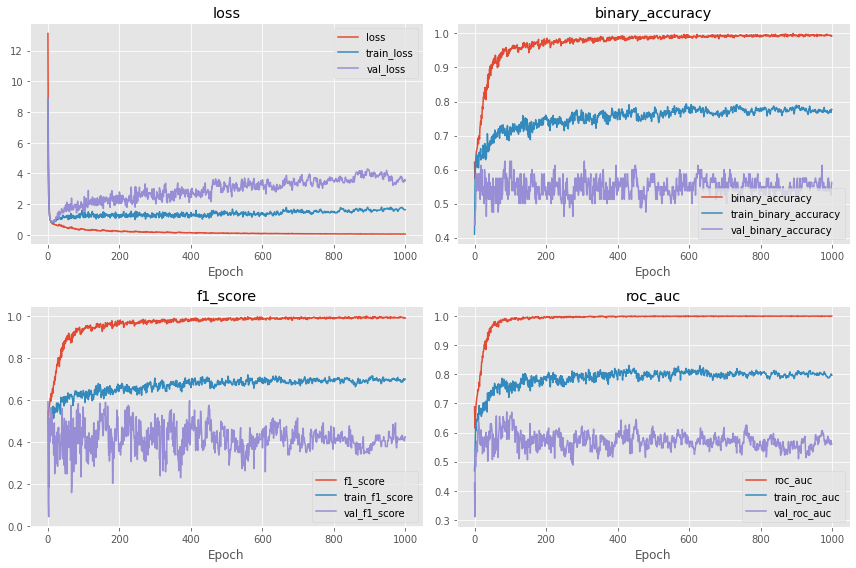

In [676]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
for i,val in enumerate(['loss','binary_accuracy','f1_score','roc_auc']):
    row = i//2
    col = i%2
    ax[row][col].plot(history.history[val],label=val)
    ax[row][col].plot(history.history['train_'+val],label='train_'+val)
    ax[row][col].plot(history.history['val_'+val],label='val_'+val)
    ax[row][col].set_title(val)
    ax[row][col].set_xlabel('Epoch')
    ax[row][col].legend()
plt.tight_layout()

In [184]:
# Loading the best saved model
lstm_best_model_fitted = keras.models.load_model('./Model Outputs/LSTM_best_model_2')

In [185]:
full_valid_X = pd.concat([pd.DataFrame(train_features_imp.iloc[-1:]),valid_features_imp])
full_valid_Y = pd.concat([train_Y.iloc[-1:],valid_Y])
full_valid_data = time_step_generation(full_valid_X,full_valid_Y,time_step=2)

In [186]:
lstm_best_prediction = (lstm_best_model_fitted.predict(full_valid_data[0]).ravel()>0.5)*1

3/3 [==============================] - 1s 3ms/step


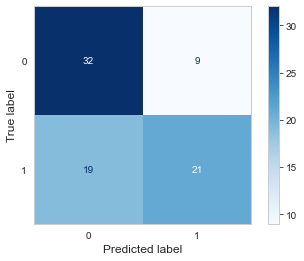

In [187]:
ConfusionMatrixDisplay.from_predictions(valid_Y,lstm_best_prediction,cmap='Blues')
plt.grid()

In [188]:
print(classification_report(valid_Y,lstm_best_prediction))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70        41
           1       0.70      0.53      0.60        40

    accuracy                           0.65        81
   macro avg       0.66      0.65      0.65        81
weighted avg       0.66      0.65      0.65        81



In [189]:
print(f'ROC AUC:{roc_auc_score(valid_Y,lstm_best_model_fitted.predict(full_valid_data[0]).ravel()):.3f}')

3/3 [==============================] - 0s 4ms/step
ROC AUC:0.673


### 5.5 XGBoost

In [190]:
from xgboost import XGBClassifier

#### 5.5.1 Preliminary XGBoost Model

In [165]:
xgbclf = XGBClassifier(n_estimators =1000,learning_rate =0.01,early_stopping_rounds = 50,eval_metric ='error'
                       ,scale_pos_weight=1.5,random_state=42)

xgbclf.fit(X =train_features_imp.values,y=train_Y.values,verbose=1,eval_set = [(valid_features_imp.values,valid_Y.values)])

[0]	validation_0-error:0.44444
[1]	validation_0-error:0.44444
[2]	validation_0-error:0.43210
[3]	validation_0-error:0.43210
[4]	validation_0-error:0.40741
[5]	validation_0-error:0.41975
[6]	validation_0-error:0.39506
[7]	validation_0-error:0.48148
[8]	validation_0-error:0.46914
[9]	validation_0-error:0.46914
[10]	validation_0-error:0.44444
[11]	validation_0-error:0.46914
[12]	validation_0-error:0.45679
[13]	validation_0-error:0.46914
[14]	validation_0-error:0.48148
[15]	validation_0-error:0.46914
[16]	validation_0-error:0.46914
[17]	validation_0-error:0.46914
[18]	validation_0-error:0.49383
[19]	validation_0-error:0.49383
[20]	validation_0-error:0.46914
[21]	validation_0-error:0.49383
[22]	validation_0-error:0.48148
[23]	validation_0-error:0.48148
[24]	validation_0-error:0.45679
[25]	validation_0-error:0.45679
[26]	validation_0-error:0.45679
[27]	validation_0-error:0.46914
[28]	validation_0-error:0.46914
[29]	validation_0-error:0.46914
[30]	validation_0-error:0.45679
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [191]:
#pickle.dump(xgbclf, open('./Model Outputs/XGBoost/XGBoost Prelim Model', 'wb'))
xgbclf = pickle.load(open('./Model Outputs/XGBoost/XGBoost Prelim Model', 'rb'))

In [192]:
xgb_prelim_pred = xgbclf.predict(valid_features_imp)

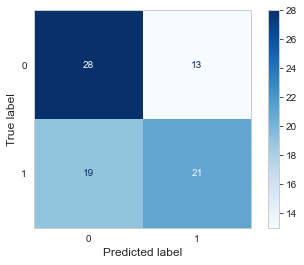

In [193]:
ConfusionMatrixDisplay.from_predictions(valid_Y,xgb_prelim_pred,cmap='Blues')
plt.grid()

In [194]:
print(classification_report(valid_Y,xgb_prelim_pred))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64        41
           1       0.62      0.53      0.57        40

    accuracy                           0.60        81
   macro avg       0.61      0.60      0.60        81
weighted avg       0.61      0.60      0.60        81



#### 5.5.2 HyperParameter Tuning

In [195]:
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV

In [196]:
params_grid = {'learning_rate':st.loguniform(0.001,0.1),
               'max_depth': st.randint(1,10),
               'min_child_weight': st.uniform(0,10),
               'colsample_bytree': st.uniform(0,1),
               'reg_lambda':st.uniform(0,100)
              }

In [197]:
train_valid_features_imp = pd.concat([train_features_imp,valid_features_imp])
train_valid_Y = pd.concat([train_Y,valid_Y])
train_valid_split = (np.arange(train_features_imp.shape[0]),
                     np.arange(valid_features_imp.shape[0])+train_features_imp.shape[0])

random_search_xgb = RandomizedSearchCV(xgbclf,params_grid,cv=[train_valid_split],return_train_score=True,
                                       scoring=make_scorer(f1_score),n_iter=10000,refit=False)

In [198]:
fit_params ={'eval_set':[(valid_features_imp.values,valid_Y.values)],'verbose':0}
#random_search_xgb.fit(train_valid_features_imp.values,train_valid_Y.values,**fit_params)

In [199]:
#pickle.dump(random_search_xgb,open('./Model Outputs/XGBoost/XGBoost_random_search','wb'))
random_search_xgb = pickle.load(open('./Model Outputs/XGBoost/XGBoost_random_search','rb'))
random_search_xgb_results = pd.DataFrame(random_search_xgb.cv_results_)

#### 5.5.3 Choosing the best Model

From the list of models, there may be models that have high test score due to chance. We try to eliminate them by checking the train score. If the train score is not higher than the test score, then the model may not be trained properly.

In [200]:
random_search_xgb_results['train_test_comp'] = (random_search_xgb_results['mean_train_score']>=random_search_xgb_results['mean_test_score'])*1

In [201]:
random_search_xgb_results[random_search_xgb_results['train_test_comp']==1].sort_values('mean_test_score',ascending=False).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8084       0.143033           0.0         0.005000             0.0   
6503       0.250056           0.0         0.005001             0.0   
3177       0.142033           0.0         0.005001             0.0   
195        0.154034           0.0         0.006002             0.0   
6046       0.198045           0.0         0.005001             0.0   

     param_colsample_bytree param_learning_rate param_max_depth  \
8084                0.23213            0.028334               6   
6503               0.788966            0.003234               9   
3177               0.094417            0.055803               9   
195                0.156596            0.010823               9   
6046               0.879493            0.002343               6   

     param_min_child_weight param_reg_lambda  \
8084               4.586118         5.540593   
6503                3.20809         2.285467   
3177               9.399505         4.180337   
195                3.590184         6.390977   
6046               6.444036         1.600275   

                                                 params  split0_test_score  \
8084  {'colsample_bytree': 0.23212994368416118, 'lea...           0.641026   
6503  {'colsample_bytree': 0.7889657273764966, 'lear...           0.617647   
3177  {'colsample_bytree': 0.09441703971743931, 'lea...           0.617284   
195   {'colsample_bytree': 0.15659643482170993, 'lea...           0.611765   
6046  {'colsample_bytree': 0.879492928101532, 'learn...           0.602410   

      mean_test_score  std_test_score  rank_test_score  split0_train_score  \
8084         0.641026             0.0               48            0.650538   
6503         0.617647             0.0               60            0.819113   
3177         0.617284             0.0               61            0.648649   
195          0.611765             0.0               65            0.655765   
6046         0.602410             0.0               71            0.626840   

      mean_train_score  std_train_score  train_test_comp  
8084          0.650538              0.0                1  
6503          0.819113              0.0                1  
3177          0.648649              0.0                1  
195           0.655765              0.0                1  
6046          0.626840              0.0                1

The model which meets the condition and has the best score is taken as the best model. Though it has lower score than the first model, the chosen model might fit better to unseen data.

In [202]:
xgb_best_model_params = random_search_xgb_results.loc[8084]['params']
#xgb_best_model = xgbclf.set_params(**xgb_best_model_params)
#xgb_best_model.fit(train_features_imp.values,train_Y.values,**fit_params)

#pickle.dump(xgb_best_model,open('./Model Outputs/XGBoost/XGBoost_best_model','wb'))
xgb_best_model = pickle.load(open('./Model Outputs/XGBoost/XGBoost_best_model','rb'))

In [203]:
xgb_best_pred = xgb_best_model.predict(valid_features_imp)

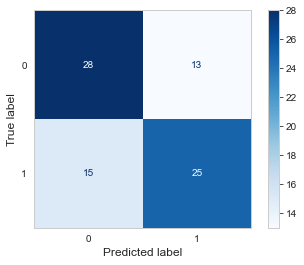

In [204]:
ConfusionMatrixDisplay.from_predictions(valid_Y,xgb_best_pred,cmap='Blues')
plt.grid()

In [205]:
print(classification_report(valid_Y,xgb_best_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67        41
           1       0.66      0.62      0.64        40

    accuracy                           0.65        81
   macro avg       0.65      0.65      0.65        81
weighted avg       0.65      0.65      0.65        81



### 5.6 Voting Classifier

We create a classifier that computes weighted average probabilities based on other estimates. Instead of using scikit learn's ```VotingClassifier```, We optimize the weights based on scipy optimization function separately.

In [206]:
from scipy import optimize as opt

In [207]:
def voting_classifier(prob_estimates,weights):
    return np.dot(prob_estimates,weights)

First we compute the predictions based on all the models

In [208]:
#Prelim Model
prelim_train_probs = best_prelim_model.predict_proba(train_features_imp)[:,-1]

In [209]:
# LSTM Prleim Model
lstm_prelim_train_probs = np.ravel(lstm_prelim_model_fitted.predict(train_data[0]))

#LSTM Best model
lstm_best_train_probs = np.ravel(lstm_best_model_fitted.predict(train_data[0]))

47/47 [==============================] - 0s 3ms/step


In [210]:
#XGBoost Prelim
xgb_prelim_train_probs = xgbclf.predict_proba(train_features_imp)[:,-1]

#XGBoost Best 
xgb_best_train_probs = xgb_best_model.predict_proba(train_features_imp)[:,-1]

We optimize the weights of the voting classifier using convex optimization. 

In [211]:
train_probs =  np.vstack([prelim_train_probs[1:],
                          lstm_prelim_train_probs,
                          lstm_best_train_probs,
                          xgb_prelim_train_probs[1:],
                          xgb_best_train_probs[1:],
                         ]).T

In [407]:
def objective_fn(w):
    weighted_probs = voting_classifier(train_probs,w)
    return -np.sum(train_Y[1:]*np.log(weighted_probs)*class_weights[1]+(1-train_Y[1:])*np.log(1-weighted_probs)*class_weights[0])

In [408]:
opt_weights = opt.minimize(objective_fn,x0=np.ones(train_probs.shape[1]).reshape(-1,1)/train_probs.shape[1],
             constraints=({'type': 'eq', 'fun': lambda x: sum(x) - 1}),bounds=[(0,1)]*train_probs.shape[1])

The optimum weights are given below:

In [409]:
print(tabulate(np.hstack([np.array(['Prelim Model (L2 Logistic Regression)',
                                    'LSTM Prelim Model','LSTM Best Model',
                                    'XGBoost Prelim Model','XGBoost Best Model']).reshape(-1,1),
                          np.round(np.array(opt_weights.x),3).reshape(-1,1)]),
               headers=['Model','Weights']))

Model                                    Weights
-------------------------------------  ---------
Prelim Model (L2 Logistic Regression)      0.397
LSTM Prelim Model                          0.09
LSTM Best Model                            0.453
XGBoost Prelim Model                       0.06
XGBoost Best Model                         0


Highest weight is provided for LSTM best model and XGBoost prelim model. XGBoost best model is not allocated any weight.

We use the optimal classifer to make prediction on the validation data set.

In [410]:
#Prelim Model
prelim_valid_probs = best_prelim_model.predict_proba(valid_features_imp)[:,-1]

In [411]:
# LSTM Prleim Model
lstm_prelim_valid_probs = np.ravel(lstm_prelim_model_fitted.predict(full_valid_data[0]))

#LSTM Best model
lstm_best_valid_probs = np.ravel(lstm_best_model_fitted.predict(full_valid_data[0]))

3/3 [==============================] - 0s 4ms/step


In [412]:
#XGBoost Prelim
xgb_prelim_valid_probs = xgbclf.predict_proba(valid_features_imp)[:,-1]

#XGBoost Best 
xgb_best_valid_probs = xgb_best_model.predict_proba(valid_features_imp)[:,-1]

In [413]:
valid_probs =  np.vstack([prelim_valid_probs,
                          lstm_prelim_valid_probs,
                          lstm_best_valid_probs,
                          xgb_prelim_valid_probs,
                          xgb_best_valid_probs
                         ]).T

In [414]:
voting_classifer_valid_probs = voting_classifier(valid_probs,opt_weights.x)

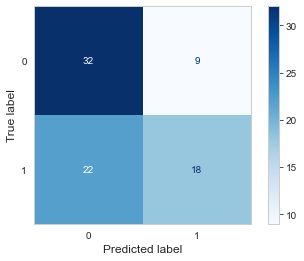

In [415]:
ConfusionMatrixDisplay.from_predictions(valid_Y,voting_classifer_valid_probs>0.5,cmap='Blues')
plt.grid()

In [416]:
print(classification_report(valid_Y,voting_classifer_valid_probs>0.5))

              precision    recall  f1-score   support

           0       0.59      0.78      0.67        41
           1       0.67      0.45      0.54        40

    accuracy                           0.62        81
   macro avg       0.63      0.62      0.61        81
weighted avg       0.63      0.62      0.61        81



### 5.6 Summary of all Models

In [417]:
def summary_models(y_test, probs):
    accuracy  = []
    precision  = [] 
    recall  = []
    f1 = []
    roc_auc = []
    
    for i,prob in enumerate(probs):
        accuracy.append(np.round(accuracy_score(y_test,prob>0.5),3))
        precision.append(np.round(precision_score(y_test,prob>0.5),3))
        recall.append(np.round(recall_score(y_test,prob>0.5),3))
        f1.append(np.round(f1_score(y_test,prob>0.5),3))
        roc_auc.append(np.round(roc_auc_score(y_test,prob),3))
        
    return accuracy,precision,recall,f1,roc_auc

In [418]:
scores = summary_models(valid_Y,[prelim_valid_probs,
                                lstm_prelim_valid_probs,lstm_best_valid_probs,
                                xgb_prelim_valid_probs,xgb_best_valid_probs,
                                voting_classifer_valid_probs])

In [419]:
print(tabulate(np.hstack([np.array(['Prelim Model (L2 Logistic Regression)',
                                    'LSTM Prelim Model','LSTM Best Model',
                                    'XGBoost Prelim Model','XGBoost Best Model',
                                    'Voting Classifer'
                                   ]).reshape(-1,1),
                          np.array(scores).T]),
               headers=['Accuracy','Precision','Recall','F1 Score','ROC AUC']))

                                         Accuracy    Precision    Recall    F1 Score    ROC AUC
-------------------------------------  ----------  -----------  --------  ----------  ---------
Prelim Model (L2 Logistic Regression)       0.543        0.667     0.15        0.245      0.576
LSTM Prelim Model                           0.617        0.645     0.5         0.563      0.632
LSTM Best Model                             0.654        0.7       0.525       0.6        0.673
XGBoost Prelim Model                        0.605        0.618     0.525       0.568      0.578
XGBoost Best Model                          0.654        0.658     0.625       0.641      0.619
Voting Classifer                            0.617        0.667     0.45        0.537      0.654


## 6. Evaluation of models in Test Data

### 6.1 Summary of predictions

In [420]:
#Prelim Model
prelim_test_probs = best_prelim_model.predict_proba(test_features_imp)[:,-1]

In [421]:
full_test_X = pd.concat([pd.DataFrame([valid_features_imp.iloc[-2]]),test_features_imp])
full_test_Y = pd.concat([valid_Y.iloc[-2:-1],test_Y])
full_test_data = time_step_generation(full_test_X,full_test_Y,time_step=2)

# LSTM Prleim Model
lstm_prelim_test_probs = np.ravel(lstm_prelim_model_fitted.predict(full_test_data[0]))

#LSTM Best model
lstm_best_test_probs = np.ravel(lstm_best_model_fitted.predict(full_test_data[0]))

3/3 [==============================] - 0s 4ms/step


In [422]:
#XGBoost Prelim
xgb_prelim_test_probs = xgbclf.predict_proba(test_features_imp)[:,-1]

#XGBoost Best 
xgb_best_test_probs = xgb_best_model.predict_proba(test_features_imp)[:,-1]

In [423]:
test_probs =  np.vstack([prelim_test_probs,
                          lstm_prelim_test_probs,
                          lstm_best_test_probs,
                          xgb_prelim_test_probs,
                          xgb_best_test_probs,
                         ]).T

voting_classifer_test_probs = voting_classifier(test_probs,opt_weights.x)

In [424]:
test_scores = summary_models(test_Y,[prelim_test_probs,
                                    lstm_prelim_test_probs,lstm_best_test_probs,
                                    xgb_prelim_test_probs,xgb_best_test_probs,
                                     voting_classifer_test_probs
                                    ])

In [425]:
print(tabulate(np.hstack([np.array(['Prelim Model (L2 Logistic Regression)',
                                    'LSTM Prelim Model','LSTM Best Model',
                                    'XGBoost Prelim Model','XGBoost Best Model',
                                    'Voting Classifier']).reshape(-1,1),
                          np.array(test_scores).T]),
               headers=['Model','Accuracy','Precision','Recall','F1 Score','ROC AUC']))

Model                                    Accuracy    Precision    Recall    F1 Score    ROC AUC
-------------------------------------  ----------  -----------  --------  ----------  ---------
Prelim Model (L2 Logistic Regression)       0.595        0.44      0.355       0.393      0.558
LSTM Prelim Model                           0.595        0.444     0.387       0.414      0.57
LSTM Best Model                             0.488        0.393     0.71        0.506      0.617
XGBoost Prelim Model                        0.619        0.484     0.484       0.484      0.572
XGBoost Best Model                          0.619        0.483     0.452       0.467      0.578
Voting Classifier                           0.5          0.4       0.71        0.512      0.59


We can see that the LSTM Best model has the highest accuracy and precision but less recall. This is mitigated by using the voting classifier which has a better accuracy, precision and recall than the best lstm model.

### 6.2 Investigating the quality of predictions

In [426]:
test_pred_quality = np.round(test_Y.values.reshape(-1,1) - np.hstack([test_probs,voting_classifer_test_probs.reshape(-1,1)]),3)

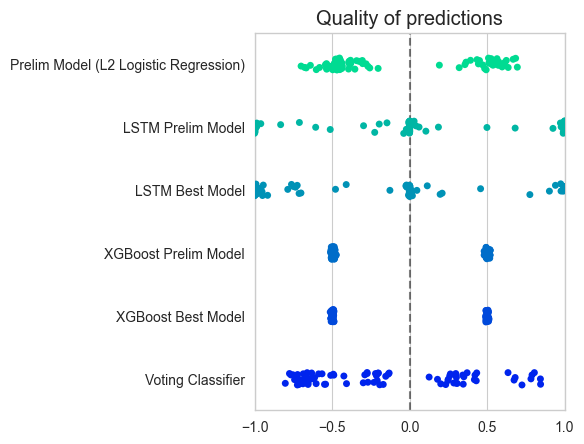

In [427]:
plt.figure(figsize=(4,5),dpi=100)
sns.stripplot(data=test_pred_quality,orient='h',palette='winter_r')
plt.axvline(x=0,c='k',ls='--',alpha=0.5)
plt.yticks(ticks=[0,1,2,3,4,5],labels=['Prelim Model (L2 Logistic Regression)',
                                    'LSTM Prelim Model','LSTM Best Model',
                                    'XGBoost Prelim Model','XGBoost Best Model',
                                    'Voting Classifier'])
plt.title('Quality of predictions')
plt.xlim((-1,1))
plt.show()

The above graph shows the quality of predictions from the predicted probabilities for each classifier. If the prediction is very close to zero, then it is an almost perfect prediction. If the prediction is between -0.5 to 0.5, then the model has correctly classified but the probability of correctly classifying is low. If the predictions are outside the range of -0.5 and +0.5, then the model has misclassified the observation.

The logistic regression produces estimates which are spread out in the region of acceptance or rejection. The classifier is not able to conform the prediction for most of the predictions and for some observations it predicts that there is a higher probability of being correctly classified. This is the base line expectation. 

The LSTM models show similar patterns. They are either perfectly correct or completely wrong. This is slightly dangerous since we assume higher probability output means the probability of being wrong is less. But for LSTM models it doesn't seem to be the case.

The XGBoost models produce estimates that exactly fall in the line of acceptance or rejection. The prediction quality is very low since it means the model is not able to predict any observation with good certainity.

The voting classifier predicts most of the observations correctly with good accuracy and some wrongly. It does not give perfectly correct or wrong answers like the LSTM models but the predictions have better certianity than XGBoost models.

## 7. Backtesting

Based on the predictions from the ML/DL model, we take positions in the market on the day opening. The strategy is we buy the stock if the predicted probability of class 1 is greater than a entry threshold. After taking a position, we stay invested if the predicted probability is greater than the hold threshold. Else, we close the position. The thresholds are chosen based on the performance on the validation set. 

We create a custom class for backtesting this strategy. The backtester is an event based backtester that takes into account transaction costs and slippage. The strategy will be better if we are able to execute trades during any time of the day. But for this backtest, we execute the trade only during the opening of the next day. The backtest should also give the performance metrics of the strategy along with charts.

### 7.1 Custom Event Backtester

In [906]:
class ml_backtester():
    
    def __init__(self, stock_data, classifier_predictions,entry_threshold=0.5,exit_threshold = 0.5,init_amount=1000000):
        self.stock_data = self.stock_data_prep(stock_data)
        self.classifier_predictions = classifier_predictions
        self.position = 0
        self.signal =0
        self.amt = init_amount
        self.stock_amt = 0
        self.cash_amt = self.amt
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        
        self.output = pd.DataFrame(columns=['Open','Close','Dividend','Probability',
                                   'Signal','Transaction','Begining Position','Ending Position',
                                   'Begining Stock Amount','Ending Stock Amount',
                                    'Transaction Cost',
                                   'Begining Cash', 'Ending Cash',
                                   'Begining Total Amount','Ending Total Amount',
                                   'P&L','Return'],index = stock_data.index)
        
        self.main()
        self.calc_metrics()
        
    def stock_data_prep(self,stock_data):
        df = stock_data.sort_index(ascending=False)
        df['Dividend'] = -np.round((df['Adj Close']/df['Close']-1).diff().fillna(0),4)*df["Close"]
        return df.sort_index()
    
    def generate_signal(self,bar):
        prediction = self.classifier_predictions[bar-1] if bar > 0 else 0
        if self.position ==0:
            if prediction >=self.entry_threshold:
                self.signal = 1
            else:
                self.signal = 0
        else:
            if prediction <= self.exit_threshold:
                self.signal = 0
            else:
                self.signal = 1
                
    def get_transaction(self):
        self.transaction = self.signal-(self.position>0)*1
        
    def get_position(self,bar):
        
        if self.transaction == 1:
            self.position = int((self.cash_amt)/self.stock_data['Open'].iloc[bar])
            
        elif self.transaction == -1:
            self.position = 0
                    
    def tc_cost(self,amt_invested,transaction):
        slippage = amt_invested *0.001
        tc = 0.00325/100*amt_invested
        stt = 0.1/100*amt_invested
        regulatory_charge = 1e-6*amt_invested
        gst = 0.18*(regulatory_charge+tc)
        stamp_charge = 0.015/100*amt_invested if transaction == 1 else 0
        
        return slippage+tc+stt+regulatory_charge+gst+stamp_charge
    
    def main(self):
        for bar,date in enumerate(self.stock_data.index):
            
            # Populating begining values
            self.output.loc[date]['Begining Position'] = self.output.iloc[bar-1]['Ending Position'] if bar >0 else 0
            self.output.loc[date]['Begining Stock Amount'] = self.output.iloc[bar-1]['Ending Stock Amount'] if bar >0 else 0
            self.output.loc[date]['Begining Cash']= self.output.iloc[bar-1]['Ending Cash'] if bar >0 else self.cash_amt
            self.output.loc[date]['Begining Total Amount'] = self.output.iloc[bar-1]['Ending Total Amount'] if bar >0 else self.amt
            self.output.loc[date]['Open'] = self.stock_data.iloc[bar]['Open']
            
            # Getting Trade directions for the day
            self.generate_signal(bar)
            self.get_transaction()
            self.get_position(bar)
            self.output.loc[date][['Probability','Signal','Transaction']] = [self.classifier_predictions[bar-1] if bar>0 else 0,
                                                                             self.signal,self.transaction]
            # Buy Transaction
            if self.transaction ==1:
                self.stock_amt = self.position * self.stock_data.iloc[bar]['Open']
                self.cash_amt = self.amt - self.stock_amt
                self.output.loc[date]['Transaction Cost'] = self.tc_cost(self.stock_amt,self.transaction)
                self.cash_amt = self.cash_amt - self.output.loc[date]['Transaction Cost']
                
            # Sell Transaction    
            elif self.transaction == -1:
                self.stock_amt = self.output.loc[date]['Begining Position'] * self.stock_data.iloc[bar]['Open']
                self.output.loc[date]['Transaction Cost'] = self.tc_cost(self.stock_amt,self.transaction)
                self.cash_amt = self.cash_amt + self.stock_amt-self.output.loc[date]['Transaction Cost']
                self.stock_amt = 0
            
            else:
                self.output.loc[date]['Transaction Cost'] = 0
            
            # Populating Ending Values
            self.output.loc[date]['Ending Position'] = self.position
            self.output.loc[date][['Close','Dividend']] = [self.stock_data.iloc[bar]['Close'],
                                                           self.stock_data.iloc[bar]['Dividend']]
            self.output.loc[date]['Ending Stock Amount'] = self.position * self.stock_data.iloc[bar]['Close']
            self.cash_amt = self.cash_amt + self.output.loc[date]['Dividend'] if self.position >0 else self.cash_amt
            self.output.loc[date]['Ending Cash'] = self.cash_amt
            
            self.output.loc[date]['Ending Total Amount'] = self.output.loc[date]['Ending Stock Amount'] + self.output.loc[date]['Ending Cash']
            self.amt = self.output.loc[date]['Ending Total Amount'] 
            
            # P&L calculation
            self.output.loc[date]['P&L'] = self.output.loc[date]['Ending Total Amount'] -  self.output.loc[date]['Begining Total Amount']
            self.output.loc[date]['Return'] = self.output.loc[date]['P&L']/self.output.loc[date]['Begining Total Amount']
            
    def calc_metrics(self):
        self.buy_hold_returns = np.cumprod(1+self.stock_data['Adj Close'].pct_change().fillna(0))
        self.strategy_cum_returns = np.cumprod(1+self.output['Return'])
        self.strategy_sharpe_ratio = self.calc_sharpe_ratio(self.output['Return'])
        self.buy_hold_sharpe_ratio = self.calc_sharpe_ratio(self.stock_data['Adj Close'].pct_change().fillna(0))
        
        self.information_ratio = self.calc_information_ratio(self.output['Return'],
                                                             self.stock_data['Adj Close'].pct_change().fillna(0))
        
        self.strategy_max_drawdown = np.max(self.calc_drawdown(self.strategy_cum_returns))
        self.buy_hold_max_drawdown = np.max(self.calc_drawdown(self.buy_hold_returns))
          
    def print_metrics(self):
        self.calc_metrics()
        print('Backtest Results'.center(60))
        print('='*60)
        print('Start Date'.ljust(30,' '),':',self.stock_data.index[0])
        print('End Date'.ljust(30,' '),':',self.stock_data.index[-1])
        print('='*60)
        
        print('Cumulative returns (%)'.ljust(30,' '),':',f'{(self.strategy_cum_returns[-1]-1)*100:.2f}%'.rjust(6,' '))
        print('Buy and Hold Returns (%)'.ljust(30,' '),':',f'{(self.buy_hold_returns[-1]-1)*100:.2f}%'.rjust(6,' '))
        print('Sharpe Ratio - Strategy'.ljust(30,' '),':',f'{self.strategy_sharpe_ratio:.2f}'.rjust(6,' '))
        print('Sharpe Ratio - Buy Hold'.ljust(30,' '),':',f'{self.buy_hold_sharpe_ratio:.2f}'.rjust(6,' '))
        print('Information Ratio'.ljust(30,' '),':',f'{self.information_ratio:.2f}'.rjust(6,' '))
        print('Max Draw Down - Strategy (%)'.ljust(30,' '),':',f'{self.strategy_max_drawdown*100:.2f}%'.rjust(6,' '))
        print('Max Draw Down - Buy Hold (%)'.ljust(30,' '),':',f'{self.buy_hold_max_drawdown*100:.2f}%'.rjust(6,' '))
        print('='*60)
        
    def calc_sharpe_ratio(self,returns):
        mean_strategy_return = np.mean(returns)*252
        std_strategy_return = np.std(returns)*(252**0.5)
        sharpe_ratio = (mean_strategy_return-0.04)/std_strategy_return
        return sharpe_ratio
    
    def calc_information_ratio(self,return_1,return_2):
        diff = return_1 - return_2
        alpha = np.mean(diff)*252
        tracking_error = np.std(diff)*(252**0.5)
        information_ratio = alpha/tracking_error
        return information_ratio
    
    def calc_drawdown(self,returns):
        max_idx = 0
        max_val = returns[0]
        drawdown = returns.copy()
        for bar,val in enumerate(returns):
            if val >= max_val:
                max_val = val
                max_idx = bar
            drawdown.iloc[bar] = max_val-val
        return drawdown     

### 7.2 Evaluating the trading strategy on validation data

The strategy is evaluated for prelim logistic model, LSTM best model, XGBoost Model and Voting classifier. The entry threshold is kept at 0.65 and exit threshold is kept at 0.6. These levels are chosen arbitrarly and may not be the optimum values. The idea is to enter the trade when the probability is high and exit when it goes below a certain level. The XGBoost and logistic model do not have probabilities more than 0.65. Hence they are evaluated at 0.5 prob.

In [930]:
prelim_model_valid_bt = ml_backtester(stock_data[valid_start:valid_end],prelim_valid_probs,entry_threshold=0.5,exit_threshold=0.5)
lstm_model_valid_bt = ml_backtester(stock_data[valid_start:valid_end],lstm_best_valid_probs,entry_threshold=0.65,exit_threshold=0.6)
xgb_model_valid_bt = ml_backtester(stock_data[valid_start:valid_end],xgb_best_valid_probs,entry_threshold=0.5,exit_threshold=0.5)
voting_classifier_valid_bt = ml_backtester(stock_data[valid_start:valid_end],voting_classifer_valid_probs,entry_threshold=0.65,exit_threshold=0.6)

In [931]:
pd.DataFrame({'Total Returns':[prelim_model_valid_bt.buy_hold_returns[-1]-1,
                              prelim_model_valid_bt.strategy_cum_returns[-1]-1,
                              lstm_model_valid_bt.strategy_cum_returns[-1]-1,
                              xgb_model_valid_bt.strategy_cum_returns[-1]-1,
                              voting_classifier_valid_bt.strategy_cum_returns[-1]-1],
              'Sharpe Ratio':[prelim_model_valid_bt.buy_hold_sharpe_ratio,
                              prelim_model_valid_bt.strategy_sharpe_ratio,
                              lstm_model_valid_bt.strategy_sharpe_ratio,
                              xgb_model_valid_bt.strategy_sharpe_ratio,
                              voting_classifier_valid_bt.strategy_sharpe_ratio
                             ],
             'Max Drawdown':[prelim_model_valid_bt.buy_hold_max_drawdown,
                              prelim_model_valid_bt.strategy_max_drawdown,
                              lstm_model_valid_bt.strategy_max_drawdown,
                              xgb_model_valid_bt.strategy_max_drawdown,
                              voting_classifier_valid_bt.strategy_max_drawdown
                             ]
             },index = ['Buy Hold Strategy','Logistic Regression','LSTM','XGBoost','Voting Classifier'])

Total Returns  Sharpe Ratio  Max Drawdown
Buy Hold Strategy         0.255341      2.934228      0.096660
Logistic Regression       0.034596      1.009053      0.035741
LSTM                      0.156980      3.219138      0.035287
XGBoost                   0.130617      2.153672      0.070423
Voting Classifier         0.129493      3.299688      0.024315

In terms of Sharpe Ratio and Drawdown, LSTM and Voting Classifier are superior to other models and better than buy hold strategy.

### 7.3 Evaluating the strategy on Testing Data

In [932]:
prelim_model_test_bt = ml_backtester(stock_data[test_start:test_end],prelim_test_probs,entry_threshold=0.5,exit_threshold=0.5)
lstm_model_test_bt = ml_backtester(stock_data[test_start:test_end],lstm_best_test_probs,entry_threshold=0.65,exit_threshold=0.6)
xgb_model_test_bt = ml_backtester(stock_data[test_start:test_end],xgb_best_test_probs,entry_threshold=0.5,exit_threshold=0.5)
voting_classifier_test_bt = ml_backtester(stock_data[test_start:test_end],voting_classifer_test_probs,entry_threshold=0.65,exit_threshold=0.6)

In [933]:
pd.DataFrame({'Total Returns':[prelim_model_test_bt.buy_hold_returns[-1]-1,
                              prelim_model_test_bt.strategy_cum_returns[-1]-1,
                              lstm_model_test_bt.strategy_cum_returns[-1]-1,
                              xgb_model_test_bt.strategy_cum_returns[-1]-1,
                              voting_classifier_test_bt.strategy_cum_returns[-1]-1],
              'Sharpe Ratio':[prelim_model_test_bt.buy_hold_sharpe_ratio,
                              prelim_model_test_bt.strategy_sharpe_ratio,
                              lstm_model_test_bt.strategy_sharpe_ratio,
                              xgb_model_test_bt.strategy_sharpe_ratio,
                              voting_classifier_test_bt.strategy_sharpe_ratio
                             ],
             'Max Drawdown':[prelim_model_test_bt.buy_hold_max_drawdown,
                              prelim_model_test_bt.strategy_max_drawdown,
                              lstm_model_test_bt.strategy_max_drawdown,
                              xgb_model_test_bt.strategy_max_drawdown,
                              voting_classifier_test_bt.strategy_max_drawdown
                             ]
             },index = ['Buy Hold Strategy','Logistic Regression','LSTM','XGBoost','Voting Classifier'])

Total Returns  Sharpe Ratio  Max Drawdown
Buy Hold Strategy         0.196290      2.513249      0.049131
Logistic Regression       0.055465      1.250815      0.046986
LSTM                      0.160230      2.376713      0.036009
XGBoost                   0.072382      1.101696      0.081632
Voting Classifier         0.198054      3.156796      0.033043

The voting classifier outperforms the buyhold strategy in terms of all metrics.

In [935]:
voting_classifier_test_bt.print_metrics()

                      Backtest Results                      
Start Date                     : 2023-06-01 00:00:00
End Date                       : 2023-09-29 00:00:00
Cumulative returns (%)         : 19.81%
Buy and Hold Returns (%)       : 19.63%
Sharpe Ratio - Strategy        :   3.16
Sharpe Ratio - Buy Hold        :   2.51
Information Ratio              :  -0.03
Max Draw Down - Strategy (%)   :  3.30%
Max Draw Down - Buy Hold (%)   :  4.91%


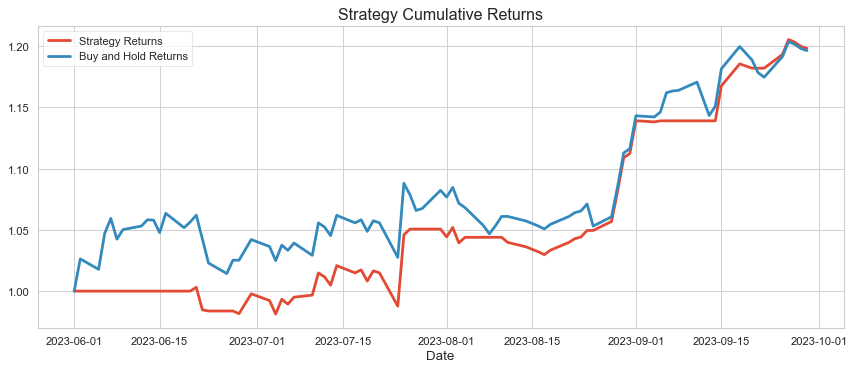

In [937]:
plt.figure(figsize=(13,5),dpi=80)
plt.plot(voting_classifier_test_bt.strategy_cum_returns,lw=2.5,label='Strategy Returns')
plt.plot(voting_classifier_test_bt.buy_hold_returns,lw=2.5,label='Buy and Hold Returns')
plt.legend()
plt.title('Strategy Cumulative Returns')
plt.xlabel('Date')
plt.show()